In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader,TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import time
from torch.nn import init
from thop import profile

In [2]:
# Remember to install CUDA and cuDNN
# Determine if your system supports CUDA.
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
#%% Read FallAllD data
data=pd.read_hdf("D:/conda/FallAllD.h5") #
data = data.drop(columns = ['Gyr','Mag','Bar'])

#%% Read SisFull
data_Sis_pash="D:/conda/111_1117/SisFall_DL-master/SisFall_dataset/"
df=pd.read_csv(data_Sis_pash+"SisFall_DataNameList.csv",header=0)
df_r=df[1:]

df_v=df['DataName'].values[:]

#%% Label
testmin=[]
test_waist = []
data_waist = []
label_waist = []
subject_waist = []
# for i in range(len(data)):
for i in range (len(df_r)):

#     if(data['Device'][i] == 'Waist'):
#         a = data['Acc'][i]*0.000244        
        C_df = pd.read_csv(data_Sis_pash+df['DataName'][i])
        testmin.append(len(C_df))
        C_df = C_df[:].values[:2393].astype('float64')
        a= C_df
        # Normalize each data between 0 and 1
        b = b = (a-np.amin(a))/(np.amax(a)-np.amin(a))
        data_waist.append(b)        
        subject_waist.append(df['Subject'][i])
        # Class: fall = 0 ,ADL = 1 
        if (df['FALL(1)_ADL(0)'][i]): 
                label_waist.append(1)
        else:
                label_waist.append(0)

#extend

# Change list to array
data_waist = np.array(data_waist, dtype=object)            
label_waist = np.array(label_waist, dtype=object)
subject_waist = np.array(subject_waist, dtype=object)
print(data_waist.shape)
# Downsampling 1/128
down_data = []
# (start:size:step)
# def down_data_SisADD(data_waist):
#down_data = data_waist[::1,::128,::1]
# data_waist = data_waist.reshape((len(data_waist), 1, 1))
down_data = data_waist[::1, ::62, ::1]
down_data = np.array(down_data, dtype=object)
print(down_data.shape)
#%% Sliding_window
sliding_waist_data =[]
sliding_waist_label =[]
sliding_waist_subject =[]  
# The signal of each second 
per_sec = 38/20
sec = 7

(3233, 2393, 3)
(3233, 39, 3)


In [3]:
for num in range(len(down_data)):
    if label_waist[num] ==1:
        # Data[index][start:end,axis]
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5)+1),:])
        # Label each window with class and subject
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(1)
        sliding_waist_subject.append(subject_waist[num])
        
    else:
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.5)):int(np.uint(sec*per_sec*1.5))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*0.75)):int(np.uint(sec*per_sec*1.75-1))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1)):int(np.uint(sec*per_sec*2))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        sliding_waist_data.append(down_data[num][int(np.uint(sec*per_sec*1.25)):int(np.uint(sec*per_sec*2.25))+1,:])
        sliding_waist_label.append(0)
        sliding_waist_subject.append(subject_waist[num])
        
sliding_waist_data = np.array(sliding_waist_data)
sliding_waist_label = np.array(sliding_waist_label)
sliding_waist_subject = np.array(sliding_waist_subject) 

np.save('FallALLD_SW_data',sliding_waist_data)
np.save('FallALLD_SW_label',sliding_waist_label)
np.save('FallALLD_SW_subject',sliding_waist_subject)

In [4]:
#%% Show Teacher confusion matrix
def show_CM_teacher(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher) SubjectID' + str(sub) + '.png')

#%% Show Student confusion matrix
def show_CM_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Student) SubjectID' + str(sub) + '.png')
    
#%% Show Teacher-Student confusion matrix
def show_CM_teacher_student(validation,prediction):     
    matrix = metrics.confusion_matrix(validation,prediction)
    plt.figure(figsize = (6,4))
    sns.heatmap(matrix,cmap = 'coolwarm',linecolor= 'white',
                linewidths= 1,annot= True,fmt = 'd')
    plt.title('SubjectID' + str(sub))
    plt.ylabel('True')
    plt.xlabel('Prediction')
    plt.show()
    plt.savefig('Prediction (Teacher-Student) SubjectID' + str(sub) + '.png')
def show_loss_teacher(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher) SubjectID' + str(sub) + '.png')
def show_Acc_teacher(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher) SubjectID' + str(sub) + '.png')
#Loss_student
def show_loss_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (Student) SubjectID' + str(sub) + '.png')   
def show_Acc_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (student) SubjectID' + str(sub) + '.png')
def show_loss_teacher_student(loss_train,loss_test):     
    plt.plot(loss_train, label = 'trian_loss')
    plt.plot(loss_test, label = 'test_loss')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(["Train Loss","Test Loss"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Loss (teacher_Student) SubjectID' + str(sub) + '.png')   
def show_Acc_teacher_student(train_acc, test_acc):     
    plt.plot(train_acc, label = 'trian_Acc')
    plt.plot(test_acc, label = 'test_Acc')    
    plt.title('SubjectID' + str(sub))
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend(["Train Acc","Test Acc"],loc = 'upper right')
    plt.show()
    #plt.savefig('Train_Test Acc (teacher_student) SubjectID' + str(sub) + '.png')

In [5]:
def loss_fn_kd(outputs, labels, teacher_outputs, T=20, alpha=0.5):
    # 一般的Cross Entropy
    labels=labels.type(torch.cuda.LongTensor)
    hard_loss = F.cross_entropy(outputs, labels) * (1. - alpha)
    # 讓logits的log_softmax對目標機率(teacher的logits/T後softmax)做KL Divergence。
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T)
    return hard_loss + soft_loss

In [6]:
class hswish(nn.Module):
    def forward(self, x):
        out = x * F.relu6(x + 3, inplace=True) / 6
        return out


class hsigmoid(nn.Module):
    def forward(self, x):
        out = F.relu6(x + 3, inplace=True) / 6
        return out


class SeModule(nn.Module):
    def __init__(self, in_size, reduction=4):
        super(SeModule, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_size, in_size // reduction, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size // reduction),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_size // reduction, in_size, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_size),
            hsigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, kernel_size, in_size, expand_size, out_size, nolinear, semodule, stride):
        super(Block, self).__init__()
        self.stride = stride
        self.se = semodule

        self.conv1 = nn.Conv2d(in_size, expand_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(expand_size)
        self.nolinear1 = nolinear
        self.conv2 = nn.Conv2d(expand_size, expand_size, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, groups=expand_size, bias=False)
        self.bn2 = nn.BatchNorm2d(expand_size)
        self.nolinear2 = nolinear
        self.conv3 = nn.Conv2d(expand_size, out_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_size)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_size != out_size:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_size, out_size, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_size),
            )

    def forward(self, x):
        out = self.nolinear1(self.bn1(self.conv1(x)))
        out = self.nolinear2(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.se != None:
            out = self.se(out)
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


In [7]:
#%% This is the config object which contains all relevant settings.    
config = {
    'nb_filters': 64,
    'filter_width': 1,
    'drop_prob': 0.5,
    'epochs': 200,#200
    'batch_size': 64,
    'learning_rate': 1e-3,#1e-3
    'weight_decay': 2e-6,
    'gpu_name': 'cuda:0',
    'print_counts': False,
    'lr_factor' : 2,
    'lr_warmup' : 40
}

In [8]:
#%% Define teacher neural network
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
      super(block, self).__init__()
      self.expansion = 4
      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)
      self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
      self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
      self.relu = nn.ReLU()
      self.identity_downsample = identity_downsample
      self.stride = stride

  def forward(self, x):
      identity = x.clone()
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.bn3(x)

      if self.identity_downsample is not None:
          identity = self.identity_downsample(identity)

      x += identity
      x = self.relu(x)
      return x

class Net_Teacher(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

#%% Define student neural network
class Net_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        print("device:", device)
        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


class Net_Teacher_Student(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes): 
        # Return a proxy object that delegates method calls to a parent or sibling class of type, which is nn.Module in this case
        super(Net_Teacher_Student, self).__init__()
        self.in_channels = 64        
        # This way can print out every layers output in forward propagation, which is more convenient to adjust. nn.Sequential(nn.Conv2d(1, self.nb_filters, 3),nn.MaxPool2d([2,1]),...) is more visibility 
        # Output shape after convolution layer = (input shape – filter shape + 1) + (2*padding/stride)
        # nn.Conv2d(input channel, output channel, kernel size(x,x),stride,padding)
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x            
        # The loss function, nn.CrossEntropyLoss(), combines LogSoftmax and NLLLoss, so we should use softmax after loss calculation
    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [9]:
class MobileNetV3_Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out


In [10]:
class MobileNetV3_Large(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Large, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), None, 1),
            Block(3, 16, 64, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 72, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 72, 40, nn.ReLU(inplace=True), SeModule(40), 2),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(5, 40, 120, 40, nn.ReLU(inplace=True), SeModule(40), 1),
            Block(3, 40, 240, 80, hswish(), None, 2),
            Block(3, 80, 200, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 184, 80, hswish(), None, 1),
            Block(3, 80, 480, 112, hswish(), SeModule(112), 1),
            Block(3, 112, 672, 112, hswish(), SeModule(112), 1),
            Block(5, 112, 672, 160, hswish(), SeModule(160), 1),
            Block(5, 160, 672, 160, hswish(), SeModule(160), 2),
            Block(5, 160, 960, 160, hswish(), SeModule(160), 1),
        )


        self.conv2 = nn.Conv2d(160, 960, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(960)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(960, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [11]:
class MobileNetV3_Small_KD(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3_Small_KD, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.hs1 = hswish()

        self.bneck = nn.Sequential(
            Block(3, 64, 64, 16, nn.ReLU(inplace=True), SeModule(16), 2),
            Block(3, 16, 72, 24, nn.ReLU(inplace=True), None, 2),
            Block(3, 24, 88, 24, nn.ReLU(inplace=True), None, 1),
            Block(5, 24, 96, 40, hswish(), SeModule(40), 2),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 240, 40, hswish(), SeModule(40), 1),
            Block(5, 40, 120, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 144, 48, hswish(), SeModule(48), 1),
            Block(5, 48, 288, 96, hswish(), SeModule(96), 2),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
            Block(5, 96, 576, 96, hswish(), SeModule(96), 1),
        )


        self.conv2 = nn.Conv2d(96, 576, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(576)
        self.hs2 = hswish()
        self.linear3 = nn.Linear(576, 1280)
        self.bn3 = nn.BatchNorm1d(1280)
        self.hs3 = hswish()
        self.linear4 = nn.Linear(1280, num_classes)
        self.init_params()

    def init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.hs1(self.bn1(self.conv1(x)))
        out = self.bneck(out)
        out = self.hs2(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.hs3(self.bn3(self.linear3(out)))
        out = self.linear4(out)
        return out

In [12]:
#%% Define teacher training loop
def training_teacher(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []

        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        train_acc.append(100 * (correct_train / total_train).cpu())
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)

    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

#%% Define teacher testing loop
#def testing_teacher(testloader,optimizer,criterion,model):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)

                test_output = model(inputs)
                
                optimizer.zero_grad()

                # Compute loss
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step() 
                test_losses.append(loss.item())        
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)                

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher.append(eval_table[0])
#         Recall_teacher.append(eval_table[1])
#         Precision_teacher.append(eval_table[2])
#         F1score_teacher.append(eval_table[3])
    #Plot train_loss
        teacher_train_preds.extend(test_preds)
        teacher_train_gt.extend(test_gt)

    show_loss_teacher(loss_train, loss_test)
    show_Acc_teacher(train_acc, test_acc)
    #return Accuracy_teacher, Recall_teacher, Precision_teacher, F1score_teacher
    return teacher_train_preds, teacher_train_gt

In [13]:
#%% Define student training loop
def training_student(trainloader,optimizer,criterion,model,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()
            # Forward pass (compute output)
            pred = model(inputs) 
            # Compute loss
            loss = criterion(pred, labels.long())
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            _, predicted = torch.max(pred.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum()
            # Use softmax to normalize the output to a probability distribution over predicted output classes
            train_output = F.softmax(pred, dim =1)
            y_preds = np.argmax(train_output.cpu().detach().numpy(), axis=-1)
            y_true = labels.cpu().numpy().flatten()
            train_preds = np.concatenate((np.array(train_preds, int), np.array(y_preds, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(100 * (correct_train / total_train).cpu())
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')

    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_test=0
    correct_test=0
    # Sets network to eval mod
    model.eval()
    #start_time = time.time()
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):
            for i, (x, y) in enumerate(testloader):            
                inputs ,labels = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                labels = labels.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()                
                # Compute loss                

                test_output = model(inputs)
                
                loss = criterion(test_output, labels.long())
                # Backpropagaton
                #loss.backward()
                # Update parameter
                optimizer.step()
                test_losses.append(loss.item())                
                
                _, predicted = torch.max(test_output.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum()
                
                test_output = F.softmax(test_output, dim=1)

                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = labels.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))
                
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            test_acc.append(100 * (correct_test / total_test).cpu())
            elapsed = time.time() - start_time
            #print('| epoch {:3d} | {:5.4f} s/epoch | test loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))    
#         eval_table = evaluation(test_preds,test_gt)
#         print('\nTest Val Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_student(test_gt, test_preds)
        #Store each result
#         Accuracy_student.append(eval_table[0])
#         Recall_student.append(eval_table[1])
#         Precision_student.append(eval_table[2])
#         F1score_student.append(eval_table[3])
        
        student_train_preds.extend(test_preds)
        student_train_gt.extend(test_gt)
    #Plot train_loss
    show_loss_student(loss_train, loss_test)
    show_Acc_student(train_acc, test_acc)
    
    #return Accuracy_student, Recall_student, Precision_student, F1score_student
    return student_train_preds, student_train_gt

In [14]:
def training_teacher_student(trainloader,optimizer,criterion,model_teacher,model_student,alpha,testloader):
    loss_train =[]
    train_acc = []
    total_train=0
    correct_train=0
    total_num, total_hit = 0, 0
    # Freeze the Teacher model
    model_teacher.eval()
    for epoch in range(config['epochs']):
        train_losses = []
        train_preds_student = []
        train_preds_teacher = []
        train_gt = []
        # Set start time to count the calaulated time of each epoch
        start_time = time.time()
        # Iterate the trainloader 
        for i, (x,y) in enumerate(trainloader):
            
            # Send data to GPU
            inputs,labels = x.to(device), y.to(device)
            inputs = inputs.to(torch.float32)
            labels = labels.to(torch.float32)
            # Sets the gradients of all optimized torch.Tensors to zero.
            optimizer.zero_grad()

            # Forward pass (compute output)
            output_student = model_student(inputs)
            output_teacher = model_teacher(inputs)

            # Use softmax to normalize the output to a probability distribution over predicted output classes
            output_student_soft = F.softmax(output_student, dim =1)
            y_preds_student = np.argmax(output_student_soft.cpu().detach().numpy(), axis=-1)

            output_teacher_soft = F.softmax(output_teacher, dim =1)
            y_preds_teacher = np.argmax(output_teacher_soft.cpu().detach().numpy(), axis=-1)

            # Compute loss
            loss = loss_fn_kd(output_student, labels, output_teacher, 20, alpha)
            # Backpropagaton
            loss.backward() 
            # Update parameter
            optimizer.step() 
            
            train_losses.append(loss.item())
            total_hit += torch.sum(torch.argmax(output_student, dim=1) == labels).item()
            total_num += len(inputs)
            y_true = labels.cpu().numpy().flatten()
            train_preds_student = np.concatenate((np.array(train_preds_student, int), np.array(y_preds_student, int)))
            train_preds_teacher = np.concatenate((np.array(train_preds_teacher, int), np.array(y_preds_teacher, int)))
            train_gt = np.concatenate((np.array(train_gt, int), np.array(y_true, int)))
        
        cur_loss = np.mean(train_losses)
        loss_train.append(cur_loss)
        train_acc.append(total_hit/total_num)
        # Get the time this epoch used
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5.4f} s/epoch | train loss {:5.4f}'.format(epoch, elapsed/60, cur_loss))
    
    eval_table = evaluation(train_preds_student, train_gt)
    print('Train Acc:{:.5f}'.format(eval_table[0]), end='')
    print(' Train Rec:{:.5f}'.format(eval_table[1]), end='')
    print(' Train Precis:{:.5f}'.format(eval_table[2]), end='')
    print(' Train F1-score:{:.5f}'.format(eval_table[3]), end='')
#%% Define Teacher-Student testing loop
#def testing_teacher_student(testloader,optimizer,criterion,model_teacher,model_student):
    test_preds = []
    test_gt = []
    loss_test =[]
    test_losses = []
    test_acc = []
    total_num, total_hit = 0, 0
    # Sets network to eval mod
    model_teacher.eval()
    model_student.eval() 
    # Disable gradient calculation for efficiency    
    with torch.no_grad():
        for epoch in range(config['epochs']):            
            for i, (x, y) in enumerate(testloader):
                inputs ,targets = x.to(device) ,y.to(device)
                inputs = inputs.to(torch.float32)
                targets = targets.to(torch.float32)
                # Sets the gradients of all optimized torch.Tensors to zero.
                optimizer.zero_grad()
                
                test_output = model_student(inputs)
                test_teacher = model_teacher(inputs)
                # Compute loss
                #loss = loss_fn_kd(test_output, labels, output_teacher, 20, alpha)                
                loss = loss_fn_kd(test_output, targets, test_teacher, 20, alpha)                
                # Backpropagaton
                #loss.backward() 
                # Update parameter
                #optimizer.step() 
                test_losses.append(loss.item())     
                
                test_output = F.softmax(test_output, dim=1)                
                total_hit += torch.sum(torch.argmax(test_output, dim=1) == targets).item()
                total_num += len(inputs)
                
                y_preds = np.argmax(test_output.cpu().numpy(), axis=-1)
                y_true = targets.cpu().numpy().flatten()
                test_preds = np.concatenate((np.array(test_preds, int), np.array(y_preds, int)))
                test_gt = np.concatenate((np.array(test_gt, int), np.array(y_true, int)))            
            
            cur_loss = np.mean(test_losses)
            loss_test.append(cur_loss)
            #eval_table = evaluation(test_preds,test_gt)
            test_acc.append(total_hit/total_num)
#         print('\nVal Acc:{:.5f}'.format(eval_table[0]), end='')
#         print(' Val Rec:{:.5f}'.format(eval_table[1]), end='')
#         print(' Val Precis:{:.5f}'.format(eval_table[2]), end='')
#         print(' Val F1-score:{:.5f}\n'.format(eval_table[3]), end='')
        #show_CM_teacher_student(test_gt, test_preds)
        #Store each result
#         Accuracy_teacher_student.append(eval_table[0])
#         Recall_teacher_student.append(eval_table[1])
#         Precision_teacher_student.append(eval_table[2])
#         F1score_teacher_student.append(eval_table[3])      
        teacher_student_train_preds.extend(test_preds)
        teacher_student_train_gt.extend(test_gt)
    show_loss_teacher_student(loss_train, loss_test)
    show_Acc_teacher_student(train_acc,test_acc)
    #return Accuracy_teacher_student, Recall_teacher_student, Precision_teacher_student, F1score_teacher_student
    return teacher_student_train_preds, teacher_student_train_gt


Subject 1
| epoch   0 | 0.4179 s/epoch | train loss 0.3345
| epoch   1 | 0.3514 s/epoch | train loss 0.2443
| epoch   2 | 0.3353 s/epoch | train loss 0.2244
| epoch   3 | 0.3475 s/epoch | train loss 0.2090
| epoch   4 | 0.3582 s/epoch | train loss 0.2025
| epoch   5 | 0.3426 s/epoch | train loss 0.1846
| epoch   6 | 0.3886 s/epoch | train loss 0.1944
| epoch   7 | 0.3569 s/epoch | train loss 0.1845
| epoch   8 | 0.3455 s/epoch | train loss 0.1701
| epoch   9 | 0.3575 s/epoch | train loss 0.1601
| epoch  10 | 0.3476 s/epoch | train loss 0.1593
| epoch  11 | 0.3569 s/epoch | train loss 0.1578
| epoch  12 | 0.3512 s/epoch | train loss 0.1475
| epoch  13 | 0.3550 s/epoch | train loss 0.1466
| epoch  14 | 0.3418 s/epoch | train loss 0.1476
| epoch  15 | 0.3547 s/epoch | train loss 0.1408
| epoch  16 | 0.3512 s/epoch | train loss 0.1321
| epoch  17 | 0.3558 s/epoch | train loss 0.1401
| epoch  18 | 0.3542 s/epoch | train loss 0.1765
| epoch  19 | 0.3549 s/epoch | train loss 0.1853
| epoch  

| epoch 167 | 0.3434 s/epoch | train loss 0.0115
| epoch 168 | 0.3414 s/epoch | train loss 0.0201
| epoch 169 | 0.3351 s/epoch | train loss 0.0182
| epoch 170 | 0.3358 s/epoch | train loss 0.0185
| epoch 171 | 0.3440 s/epoch | train loss 0.0258
| epoch 172 | 0.3378 s/epoch | train loss 0.0199
| epoch 173 | 0.3512 s/epoch | train loss 0.0154
| epoch 174 | 0.3448 s/epoch | train loss 0.0183
| epoch 175 | 0.3438 s/epoch | train loss 0.0180
| epoch 176 | 0.3386 s/epoch | train loss 0.0125
| epoch 177 | 0.3524 s/epoch | train loss 0.0183
| epoch 178 | 0.3422 s/epoch | train loss 0.0126
| epoch 179 | 0.3559 s/epoch | train loss 0.0135
| epoch 180 | 0.3358 s/epoch | train loss 0.0626
| epoch 181 | 0.3428 s/epoch | train loss 0.0453
| epoch 182 | 0.3504 s/epoch | train loss 0.0204
| epoch 183 | 0.3522 s/epoch | train loss 0.0143
| epoch 184 | 0.3454 s/epoch | train loss 0.0147
| epoch 185 | 0.3420 s/epoch | train loss 0.0118
| epoch 186 | 0.3331 s/epoch | train loss 0.0155
| epoch 187 | 0.3472

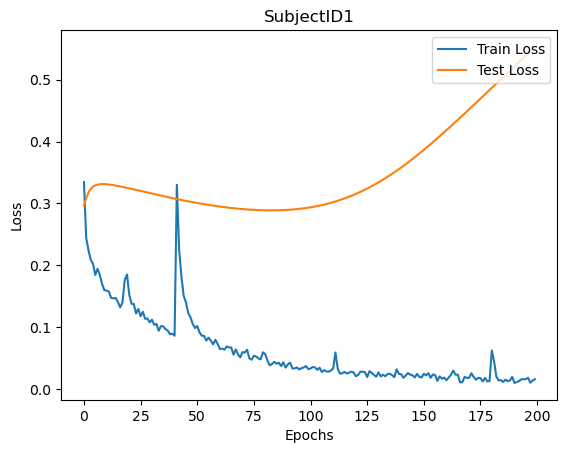

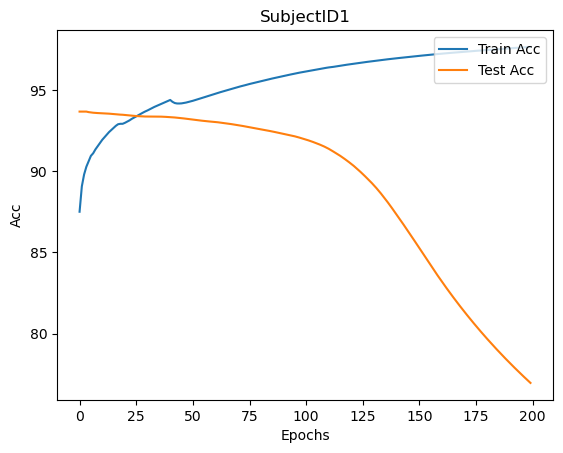

| epoch   0 | 0.1985 s/epoch | train loss 0.3863
| epoch   1 | 0.1984 s/epoch | train loss 0.2849
| epoch   2 | 0.2010 s/epoch | train loss 0.2622
| epoch   3 | 0.1972 s/epoch | train loss 0.2394
| epoch   4 | 0.1931 s/epoch | train loss 0.2320
| epoch   5 | 0.1890 s/epoch | train loss 0.2308
| epoch   6 | 0.1946 s/epoch | train loss 0.2139
| epoch   7 | 0.1879 s/epoch | train loss 0.2028
| epoch   8 | 0.1931 s/epoch | train loss 0.2024
| epoch   9 | 0.1953 s/epoch | train loss 0.1935
| epoch  10 | 0.1925 s/epoch | train loss 0.1889
| epoch  11 | 0.1983 s/epoch | train loss 0.1815
| epoch  12 | 0.1854 s/epoch | train loss 0.1838
| epoch  13 | 0.1931 s/epoch | train loss 0.1775
| epoch  14 | 0.1920 s/epoch | train loss 0.1707
| epoch  15 | 0.1950 s/epoch | train loss 0.1695
| epoch  16 | 0.1938 s/epoch | train loss 0.1667
| epoch  17 | 0.1937 s/epoch | train loss 0.1609
| epoch  18 | 0.1831 s/epoch | train loss 0.1529
| epoch  19 | 0.1931 s/epoch | train loss 0.1505
| epoch  20 | 0.1968

| epoch 168 | 0.2073 s/epoch | train loss 0.0426
| epoch 169 | 0.2033 s/epoch | train loss 0.0372
| epoch 170 | 0.2011 s/epoch | train loss 0.0367
| epoch 171 | 0.2062 s/epoch | train loss 0.0367
| epoch 172 | 0.2014 s/epoch | train loss 0.0374
| epoch 173 | 0.2073 s/epoch | train loss 0.0350
| epoch 174 | 0.2142 s/epoch | train loss 0.0395
| epoch 175 | 0.2075 s/epoch | train loss 0.0386
| epoch 176 | 0.1835 s/epoch | train loss 0.0417
| epoch 177 | 0.1994 s/epoch | train loss 0.0359
| epoch 178 | 0.2017 s/epoch | train loss 0.0391
| epoch 179 | 0.2169 s/epoch | train loss 0.0413
| epoch 180 | 0.1945 s/epoch | train loss 0.0363
| epoch 181 | 0.1902 s/epoch | train loss 0.0391
| epoch 182 | 0.1942 s/epoch | train loss 0.0371
| epoch 183 | 0.1885 s/epoch | train loss 0.0361
| epoch 184 | 0.1883 s/epoch | train loss 0.0320
| epoch 185 | 0.1892 s/epoch | train loss 0.0341
| epoch 186 | 0.1915 s/epoch | train loss 0.0375
| epoch 187 | 0.1946 s/epoch | train loss 0.0388
| epoch 188 | 0.1850

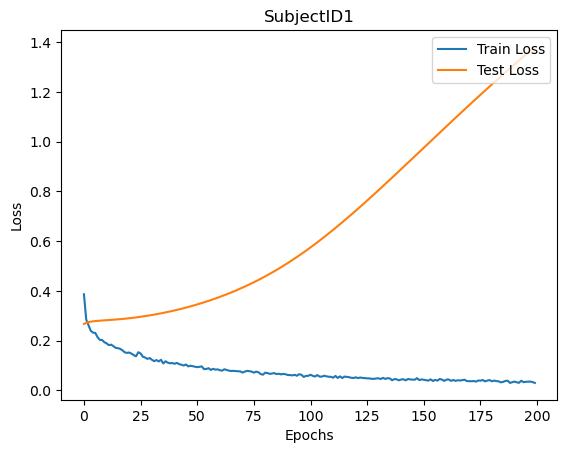

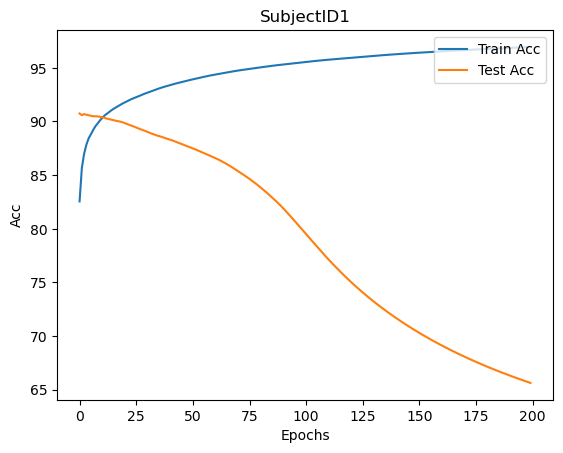


Subject 2
| epoch   0 | 0.3687 s/epoch | train loss 0.3216
| epoch   1 | 0.3780 s/epoch | train loss 0.2400
| epoch   2 | 0.3758 s/epoch | train loss 0.2124
| epoch   3 | 0.3684 s/epoch | train loss 0.2087
| epoch   4 | 0.3541 s/epoch | train loss 0.1946
| epoch   5 | 0.3659 s/epoch | train loss 0.1822
| epoch   6 | 0.3618 s/epoch | train loss 0.1827
| epoch   7 | 0.3712 s/epoch | train loss 0.1712
| epoch   8 | 0.3541 s/epoch | train loss 0.1615
| epoch   9 | 0.3652 s/epoch | train loss 0.1618
| epoch  10 | 0.3595 s/epoch | train loss 0.1558
| epoch  11 | 0.3530 s/epoch | train loss 0.1621
| epoch  12 | 0.3421 s/epoch | train loss 0.1574
| epoch  13 | 0.3619 s/epoch | train loss 0.1567
| epoch  14 | 0.3644 s/epoch | train loss 0.1415
| epoch  15 | 0.3494 s/epoch | train loss 0.1384
| epoch  16 | 0.3551 s/epoch | train loss 0.1388
| epoch  17 | 0.3584 s/epoch | train loss 0.1276
| epoch  18 | 0.3404 s/epoch | train loss 0.1367
| epoch  19 | 0.3485 s/epoch | train loss 0.1346
| epoch  

| epoch 167 | 0.3589 s/epoch | train loss 0.0159
| epoch 168 | 0.3327 s/epoch | train loss 0.0200
| epoch 169 | 0.3563 s/epoch | train loss 0.0152
| epoch 170 | 0.3500 s/epoch | train loss 0.0230
| epoch 171 | 0.3479 s/epoch | train loss 0.0152
| epoch 172 | 0.3707 s/epoch | train loss 0.0184
| epoch 173 | 0.3927 s/epoch | train loss 0.0261
| epoch 174 | 0.3709 s/epoch | train loss 0.0192
| epoch 175 | 0.3719 s/epoch | train loss 0.0158
| epoch 176 | 0.3722 s/epoch | train loss 0.0148
| epoch 177 | 0.3717 s/epoch | train loss 0.0207
| epoch 178 | 0.3747 s/epoch | train loss 0.0273
| epoch 179 | 0.3782 s/epoch | train loss 0.0144
| epoch 180 | 0.3742 s/epoch | train loss 0.0180
| epoch 181 | 0.3497 s/epoch | train loss 0.0277
| epoch 182 | 0.3682 s/epoch | train loss 0.0284
| epoch 183 | 0.3695 s/epoch | train loss 0.0114
| epoch 184 | 0.3760 s/epoch | train loss 0.0171
| epoch 185 | 0.3757 s/epoch | train loss 0.0177
| epoch 186 | 0.3783 s/epoch | train loss 0.0134
| epoch 187 | 0.3700

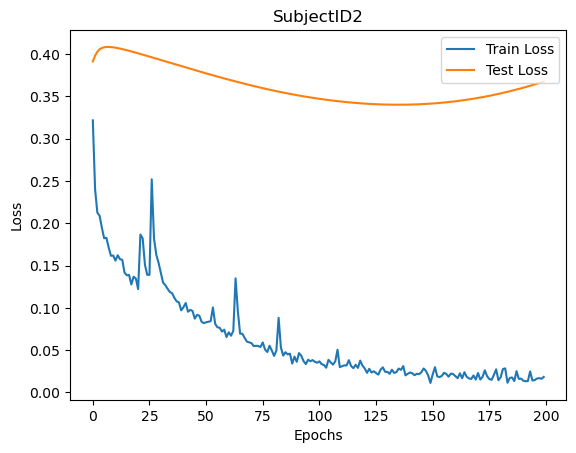

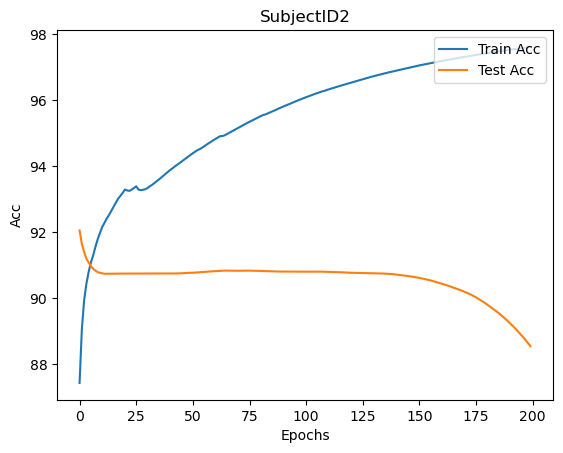

| epoch   0 | 0.1988 s/epoch | train loss 0.3877
| epoch   1 | 0.2073 s/epoch | train loss 0.2716
| epoch   2 | 0.2044 s/epoch | train loss 0.2436
| epoch   3 | 0.2102 s/epoch | train loss 0.2315
| epoch   4 | 0.2030 s/epoch | train loss 0.2220
| epoch   5 | 0.2090 s/epoch | train loss 0.2178
| epoch   6 | 0.2055 s/epoch | train loss 0.2099
| epoch   7 | 0.2047 s/epoch | train loss 0.2055
| epoch   8 | 0.2075 s/epoch | train loss 0.1953
| epoch   9 | 0.2066 s/epoch | train loss 0.1818
| epoch  10 | 0.2090 s/epoch | train loss 0.1850
| epoch  11 | 0.2092 s/epoch | train loss 0.1767
| epoch  12 | 0.2072 s/epoch | train loss 0.1727
| epoch  13 | 0.2062 s/epoch | train loss 0.1675
| epoch  14 | 0.2153 s/epoch | train loss 0.1610
| epoch  15 | 0.2052 s/epoch | train loss 0.1704
| epoch  16 | 0.2055 s/epoch | train loss 0.1544
| epoch  17 | 0.2020 s/epoch | train loss 0.1540
| epoch  18 | 0.2154 s/epoch | train loss 0.1531
| epoch  19 | 0.2045 s/epoch | train loss 0.1510
| epoch  20 | 0.2112

| epoch 168 | 0.1975 s/epoch | train loss 0.0370
| epoch 169 | 0.1986 s/epoch | train loss 0.0411
| epoch 170 | 0.1977 s/epoch | train loss 0.0401
| epoch 171 | 0.1968 s/epoch | train loss 0.0363
| epoch 172 | 0.1970 s/epoch | train loss 0.0350
| epoch 173 | 0.1992 s/epoch | train loss 0.0349
| epoch 174 | 0.1941 s/epoch | train loss 0.0344
| epoch 175 | 0.1993 s/epoch | train loss 0.0389
| epoch 176 | 0.2039 s/epoch | train loss 0.0380
| epoch 177 | 0.2065 s/epoch | train loss 0.0411
| epoch 178 | 0.2086 s/epoch | train loss 0.0374
| epoch 179 | 0.2120 s/epoch | train loss 0.0452
| epoch 180 | 0.2045 s/epoch | train loss 0.0352
| epoch 181 | 0.1751 s/epoch | train loss 0.0346
| epoch 182 | 0.1803 s/epoch | train loss 0.0373
| epoch 183 | 0.1850 s/epoch | train loss 0.0367
| epoch 184 | 0.1962 s/epoch | train loss 0.0421
| epoch 185 | 0.1915 s/epoch | train loss 0.0367
| epoch 186 | 0.1686 s/epoch | train loss 0.0370
| epoch 187 | 0.1691 s/epoch | train loss 0.0352
| epoch 188 | 0.1733

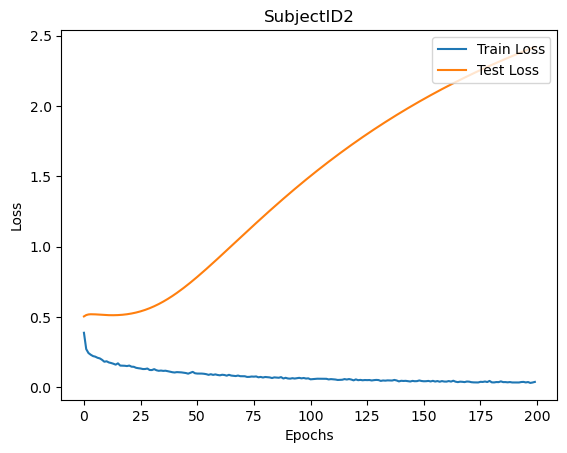

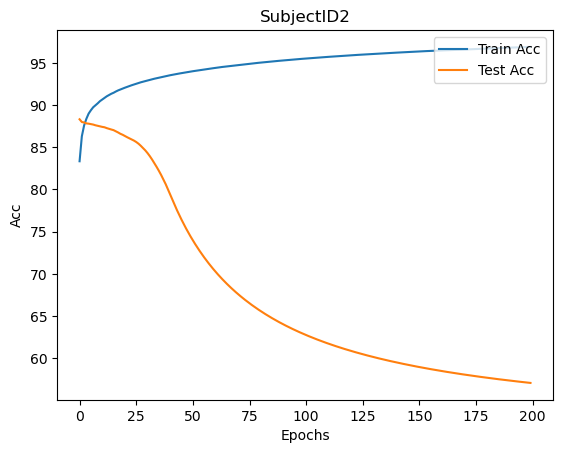


Subject 3
| epoch   0 | 0.2932 s/epoch | train loss 0.3601
| epoch   1 | 0.2916 s/epoch | train loss 0.3597
| epoch   2 | 0.2929 s/epoch | train loss 0.2490
| epoch   3 | 0.2916 s/epoch | train loss 0.3182
| epoch   4 | 0.2927 s/epoch | train loss 0.2350
| epoch   5 | 0.2939 s/epoch | train loss 0.2124
| epoch   6 | 0.2932 s/epoch | train loss 0.1980
| epoch   7 | 0.3224 s/epoch | train loss 0.1856
| epoch   8 | 0.3038 s/epoch | train loss 0.1764
| epoch   9 | 0.3097 s/epoch | train loss 0.1774
| epoch  10 | 0.3062 s/epoch | train loss 0.2562
| epoch  11 | 0.3026 s/epoch | train loss 0.2394
| epoch  12 | 0.2821 s/epoch | train loss 0.2118
| epoch  13 | 0.2530 s/epoch | train loss 0.1924
| epoch  14 | 0.2495 s/epoch | train loss 0.1895
| epoch  15 | 0.2461 s/epoch | train loss 0.1762
| epoch  16 | 0.2470 s/epoch | train loss 0.1676
| epoch  17 | 0.2507 s/epoch | train loss 0.1497
| epoch  18 | 0.2515 s/epoch | train loss 0.1509
| epoch  19 | 0.2486 s/epoch | train loss 0.1480
| epoch  

| epoch 167 | 0.2993 s/epoch | train loss 0.0207
| epoch 168 | 0.2987 s/epoch | train loss 0.0291
| epoch 169 | 0.2969 s/epoch | train loss 0.0241
| epoch 170 | 0.3008 s/epoch | train loss 0.0164
| epoch 171 | 0.2995 s/epoch | train loss 0.0260
| epoch 172 | 0.3002 s/epoch | train loss 0.0165
| epoch 173 | 0.3020 s/epoch | train loss 0.0170
| epoch 174 | 0.2958 s/epoch | train loss 0.0132
| epoch 175 | 0.2987 s/epoch | train loss 0.0208
| epoch 176 | 0.2995 s/epoch | train loss 0.0242
| epoch 177 | 0.3004 s/epoch | train loss 0.0140
| epoch 178 | 0.2979 s/epoch | train loss 0.0175
| epoch 179 | 0.3002 s/epoch | train loss 0.0318
| epoch 180 | 0.2991 s/epoch | train loss 0.0235
| epoch 181 | 0.2996 s/epoch | train loss 0.0173
| epoch 182 | 0.2977 s/epoch | train loss 0.0215
| epoch 183 | 0.2984 s/epoch | train loss 0.0235
| epoch 184 | 0.2980 s/epoch | train loss 0.0193
| epoch 185 | 0.2990 s/epoch | train loss 0.0168
| epoch 186 | 0.2986 s/epoch | train loss 0.0166
| epoch 187 | 0.2996

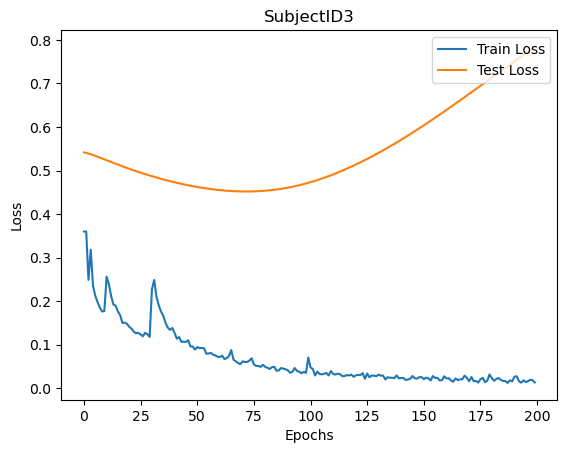

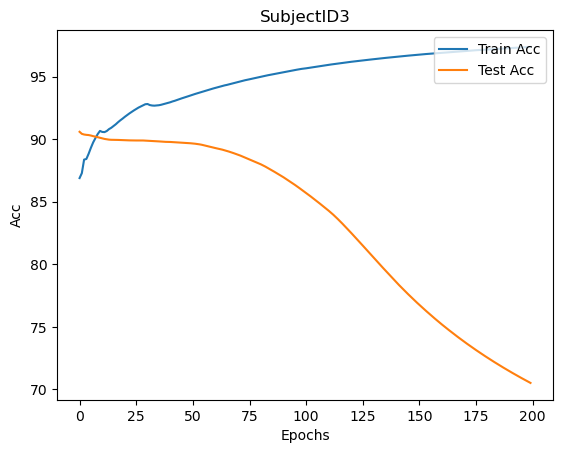

| epoch   0 | 0.1614 s/epoch | train loss 0.3660
| epoch   1 | 0.1610 s/epoch | train loss 0.2765
| epoch   2 | 0.1615 s/epoch | train loss 0.2460
| epoch   3 | 0.1604 s/epoch | train loss 0.2335
| epoch   4 | 0.1645 s/epoch | train loss 0.2269
| epoch   5 | 0.1614 s/epoch | train loss 0.2207
| epoch   6 | 0.1610 s/epoch | train loss 0.2100
| epoch   7 | 0.1605 s/epoch | train loss 0.2145
| epoch   8 | 0.1568 s/epoch | train loss 0.2037
| epoch   9 | 0.1609 s/epoch | train loss 0.1881
| epoch  10 | 0.1606 s/epoch | train loss 0.1954
| epoch  11 | 0.1617 s/epoch | train loss 0.1829
| epoch  12 | 0.1589 s/epoch | train loss 0.1756
| epoch  13 | 0.1625 s/epoch | train loss 0.1734
| epoch  14 | 0.1581 s/epoch | train loss 0.1695
| epoch  15 | 0.1615 s/epoch | train loss 0.1699
| epoch  16 | 0.1593 s/epoch | train loss 0.1591
| epoch  17 | 0.1646 s/epoch | train loss 0.1537
| epoch  18 | 0.1578 s/epoch | train loss 0.1528
| epoch  19 | 0.1598 s/epoch | train loss 0.1448
| epoch  20 | 0.1596

| epoch 168 | 0.1636 s/epoch | train loss 0.0382
| epoch 169 | 0.1649 s/epoch | train loss 0.0402
| epoch 170 | 0.1616 s/epoch | train loss 0.0384
| epoch 171 | 0.1633 s/epoch | train loss 0.0361
| epoch 172 | 0.1630 s/epoch | train loss 0.0408
| epoch 173 | 0.1641 s/epoch | train loss 0.0396
| epoch 174 | 0.1597 s/epoch | train loss 0.0392
| epoch 175 | 0.1621 s/epoch | train loss 0.0357
| epoch 176 | 0.1625 s/epoch | train loss 0.0412
| epoch 177 | 0.1595 s/epoch | train loss 0.0342
| epoch 178 | 0.1623 s/epoch | train loss 0.0349
| epoch 179 | 0.1591 s/epoch | train loss 0.0368
| epoch 180 | 0.1607 s/epoch | train loss 0.0388
| epoch 181 | 0.1615 s/epoch | train loss 0.0369
| epoch 182 | 0.1594 s/epoch | train loss 0.0376
| epoch 183 | 0.1610 s/epoch | train loss 0.0370
| epoch 184 | 0.1621 s/epoch | train loss 0.0382
| epoch 185 | 0.1598 s/epoch | train loss 0.0364
| epoch 186 | 0.1608 s/epoch | train loss 0.0371
| epoch 187 | 0.1617 s/epoch | train loss 0.0412
| epoch 188 | 0.1630

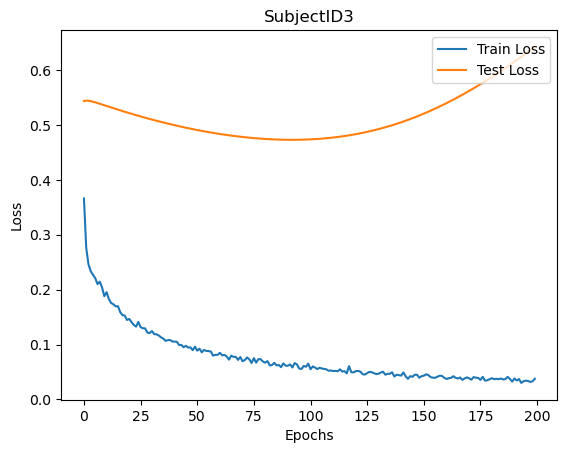

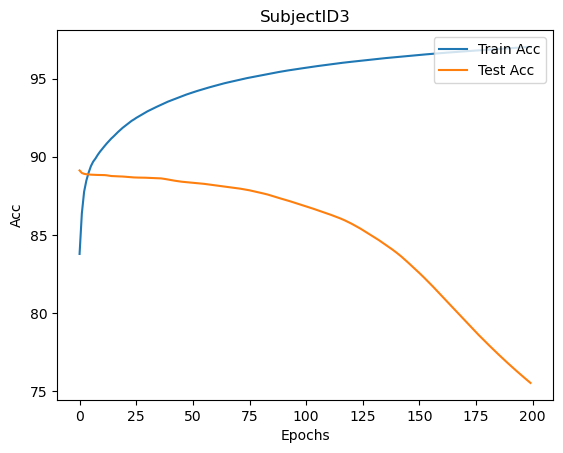


Subject 4
| epoch   0 | 0.2930 s/epoch | train loss 0.3809
| epoch   1 | 0.2965 s/epoch | train loss 0.2993
| epoch   2 | 0.2980 s/epoch | train loss 0.2880
| epoch   3 | 0.2953 s/epoch | train loss 0.2329
| epoch   4 | 0.2923 s/epoch | train loss 0.2270
| epoch   5 | 0.2981 s/epoch | train loss 0.2623
| epoch   6 | 0.2976 s/epoch | train loss 0.3194
| epoch   7 | 0.2955 s/epoch | train loss 0.3177
| epoch   8 | 0.2981 s/epoch | train loss 0.2859
| epoch   9 | 0.2959 s/epoch | train loss 0.2249
| epoch  10 | 0.2976 s/epoch | train loss 0.2715
| epoch  11 | 0.2975 s/epoch | train loss 0.2550
| epoch  12 | 0.2960 s/epoch | train loss 0.2320
| epoch  13 | 0.2982 s/epoch | train loss 0.2167
| epoch  14 | 0.2972 s/epoch | train loss 0.2010
| epoch  15 | 0.2944 s/epoch | train loss 0.1825
| epoch  16 | 0.2945 s/epoch | train loss 0.1756
| epoch  17 | 0.2977 s/epoch | train loss 0.1733
| epoch  18 | 0.2979 s/epoch | train loss 0.1672
| epoch  19 | 0.2966 s/epoch | train loss 0.1653
| epoch  

| epoch 167 | 0.2940 s/epoch | train loss 0.0137
| epoch 168 | 0.2907 s/epoch | train loss 0.0194
| epoch 169 | 0.2933 s/epoch | train loss 0.0225
| epoch 170 | 0.2966 s/epoch | train loss 0.0171
| epoch 171 | 0.3005 s/epoch | train loss 0.0174
| epoch 172 | 0.3017 s/epoch | train loss 0.0183
| epoch 173 | 0.3038 s/epoch | train loss 0.0218
| epoch 174 | 0.3000 s/epoch | train loss 0.0148
| epoch 175 | 0.3011 s/epoch | train loss 0.0209
| epoch 176 | 0.2984 s/epoch | train loss 0.0157
| epoch 177 | 0.3016 s/epoch | train loss 0.0192
| epoch 178 | 0.2992 s/epoch | train loss 0.0215
| epoch 179 | 0.3406 s/epoch | train loss 0.0163
| epoch 180 | 0.3401 s/epoch | train loss 0.0236
| epoch 181 | 0.3422 s/epoch | train loss 0.0198
| epoch 182 | 0.3443 s/epoch | train loss 0.0226
| epoch 183 | 0.3453 s/epoch | train loss 0.0146
| epoch 184 | 0.3447 s/epoch | train loss 0.0167
| epoch 185 | 0.3517 s/epoch | train loss 0.0161
| epoch 186 | 0.3459 s/epoch | train loss 0.0213
| epoch 187 | 0.3519

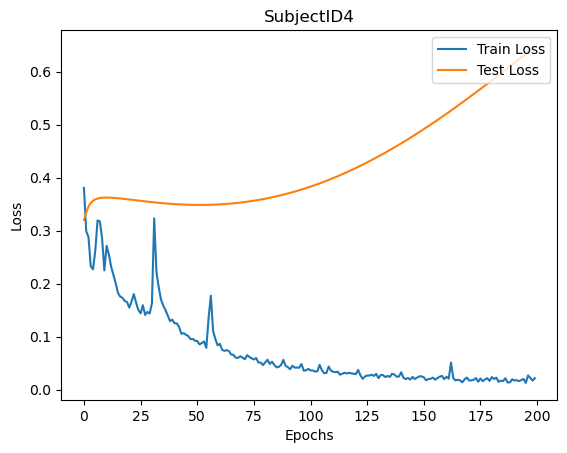

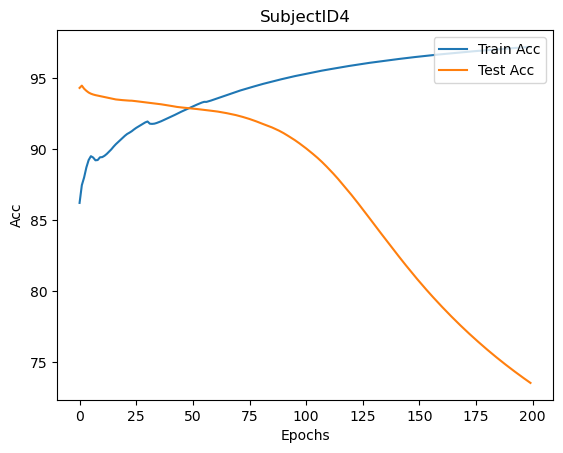

| epoch   0 | 0.1807 s/epoch | train loss 0.3773
| epoch   1 | 0.1844 s/epoch | train loss 0.2844
| epoch   2 | 0.1831 s/epoch | train loss 0.2592
| epoch   3 | 0.1888 s/epoch | train loss 0.2456
| epoch   4 | 0.1848 s/epoch | train loss 0.2368
| epoch   5 | 0.1849 s/epoch | train loss 0.2341
| epoch   6 | 0.1902 s/epoch | train loss 0.2210
| epoch   7 | 0.1842 s/epoch | train loss 0.2116
| epoch   8 | 0.1889 s/epoch | train loss 0.2028
| epoch   9 | 0.1871 s/epoch | train loss 0.1979
| epoch  10 | 0.1932 s/epoch | train loss 0.1945
| epoch  11 | 0.1916 s/epoch | train loss 0.1977
| epoch  12 | 0.1927 s/epoch | train loss 0.1859
| epoch  13 | 0.1841 s/epoch | train loss 0.1768
| epoch  14 | 0.1810 s/epoch | train loss 0.1745
| epoch  15 | 0.1851 s/epoch | train loss 0.1722
| epoch  16 | 0.1883 s/epoch | train loss 0.1659
| epoch  17 | 0.1841 s/epoch | train loss 0.1611
| epoch  18 | 0.1962 s/epoch | train loss 0.1604
| epoch  19 | 0.1914 s/epoch | train loss 0.1566
| epoch  20 | 0.1908

| epoch 168 | 0.1828 s/epoch | train loss 0.0381
| epoch 169 | 0.1856 s/epoch | train loss 0.0363
| epoch 170 | 0.1824 s/epoch | train loss 0.0399
| epoch 171 | 0.1826 s/epoch | train loss 0.0390
| epoch 172 | 0.1859 s/epoch | train loss 0.0415
| epoch 173 | 0.1852 s/epoch | train loss 0.0391
| epoch 174 | 0.1848 s/epoch | train loss 0.0371
| epoch 175 | 0.1852 s/epoch | train loss 0.0366
| epoch 176 | 0.1881 s/epoch | train loss 0.0390
| epoch 177 | 0.1821 s/epoch | train loss 0.0338
| epoch 178 | 0.1861 s/epoch | train loss 0.0402
| epoch 179 | 0.1828 s/epoch | train loss 0.0380
| epoch 180 | 0.1874 s/epoch | train loss 0.0343
| epoch 181 | 0.1892 s/epoch | train loss 0.0411
| epoch 182 | 0.1814 s/epoch | train loss 0.0352
| epoch 183 | 0.1602 s/epoch | train loss 0.0353
| epoch 184 | 0.1593 s/epoch | train loss 0.0385
| epoch 185 | 0.1602 s/epoch | train loss 0.0327
| epoch 186 | 0.1560 s/epoch | train loss 0.0329
| epoch 187 | 0.1553 s/epoch | train loss 0.0395
| epoch 188 | 0.1554

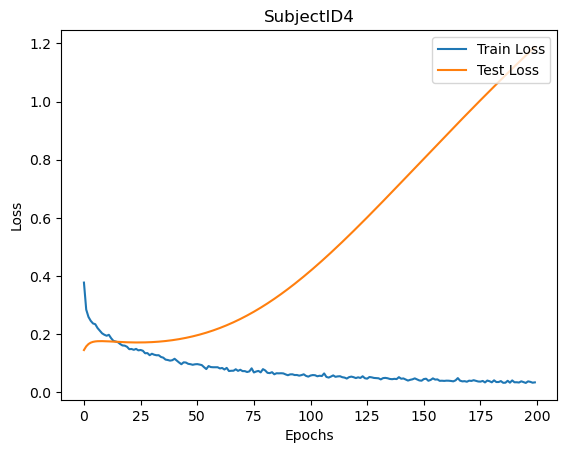

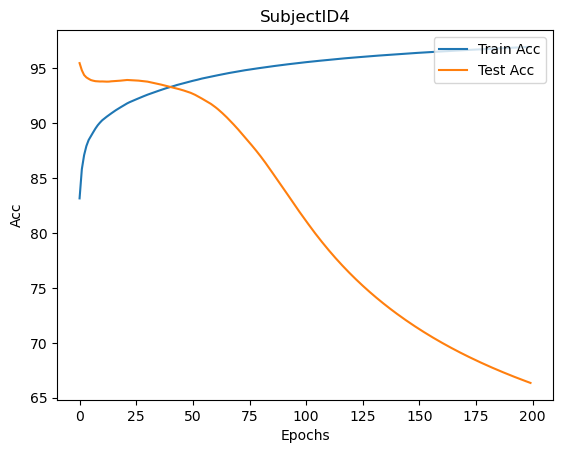


Subject 5
| epoch   0 | 0.2945 s/epoch | train loss 0.3969
| epoch   1 | 0.2970 s/epoch | train loss 0.3141
| epoch   2 | 0.2968 s/epoch | train loss 0.2718
| epoch   3 | 0.2942 s/epoch | train loss 0.3123
| epoch   4 | 0.2954 s/epoch | train loss 0.3155
| epoch   5 | 0.2948 s/epoch | train loss 0.3238
| epoch   6 | 0.2950 s/epoch | train loss 0.3381
| epoch   7 | 0.2972 s/epoch | train loss 0.2654
| epoch   8 | 0.2954 s/epoch | train loss 0.2274
| epoch   9 | 0.2958 s/epoch | train loss 0.2121
| epoch  10 | 0.2997 s/epoch | train loss 0.1973
| epoch  11 | 0.2956 s/epoch | train loss 0.2099
| epoch  12 | 0.2954 s/epoch | train loss 0.2065
| epoch  13 | 0.2935 s/epoch | train loss 0.1874
| epoch  14 | 0.2974 s/epoch | train loss 0.1836
| epoch  15 | 0.2965 s/epoch | train loss 0.1589
| epoch  16 | 0.2960 s/epoch | train loss 0.1599
| epoch  17 | 0.2948 s/epoch | train loss 0.1485
| epoch  18 | 0.2958 s/epoch | train loss 0.1414
| epoch  19 | 0.2960 s/epoch | train loss 0.1433
| epoch  

| epoch 167 | 0.2972 s/epoch | train loss 0.0347
| epoch 168 | 0.2957 s/epoch | train loss 0.0298
| epoch 169 | 0.3034 s/epoch | train loss 0.0253
| epoch 170 | 0.2988 s/epoch | train loss 0.0192
| epoch 171 | 0.3003 s/epoch | train loss 0.0198
| epoch 172 | 0.2966 s/epoch | train loss 0.0231
| epoch 173 | 0.2956 s/epoch | train loss 0.0212
| epoch 174 | 0.2980 s/epoch | train loss 0.0234
| epoch 175 | 0.2972 s/epoch | train loss 0.0220
| epoch 176 | 0.2993 s/epoch | train loss 0.0218
| epoch 177 | 0.2964 s/epoch | train loss 0.0192
| epoch 178 | 0.2999 s/epoch | train loss 0.0268
| epoch 179 | 0.2978 s/epoch | train loss 0.0202
| epoch 180 | 0.2990 s/epoch | train loss 0.0197
| epoch 181 | 0.3070 s/epoch | train loss 0.0180
| epoch 182 | 0.3103 s/epoch | train loss 0.0219
| epoch 183 | 0.3099 s/epoch | train loss 0.0185
| epoch 184 | 0.3063 s/epoch | train loss 0.0250
| epoch 185 | 0.3093 s/epoch | train loss 0.0220
| epoch 186 | 0.3122 s/epoch | train loss 0.0213
| epoch 187 | 0.3114

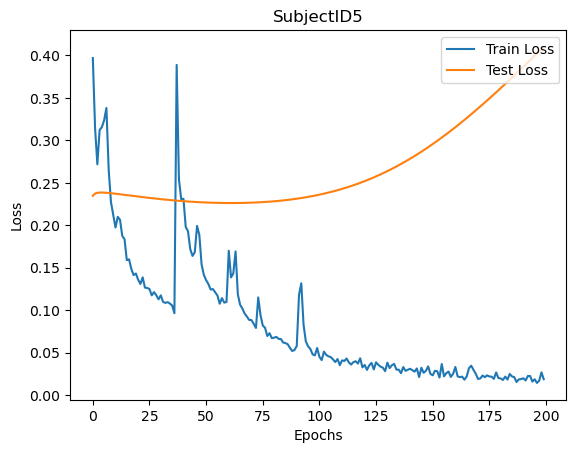

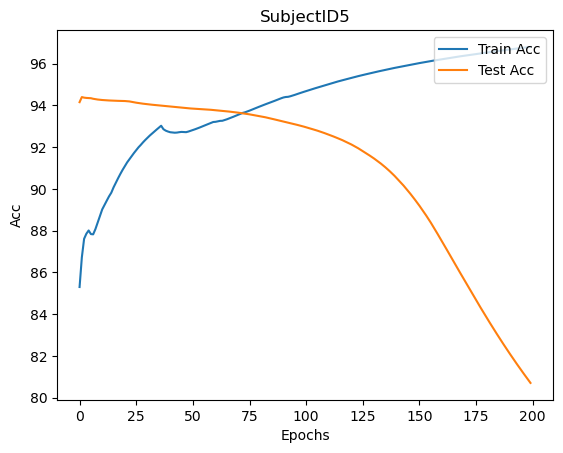

| epoch   0 | 0.1681 s/epoch | train loss 0.3806
| epoch   1 | 0.1670 s/epoch | train loss 0.2944
| epoch   2 | 0.1635 s/epoch | train loss 0.2665
| epoch   3 | 0.1637 s/epoch | train loss 0.2418
| epoch   4 | 0.1639 s/epoch | train loss 0.2331
| epoch   5 | 0.1622 s/epoch | train loss 0.2238
| epoch   6 | 0.1659 s/epoch | train loss 0.2183
| epoch   7 | 0.1635 s/epoch | train loss 0.2077
| epoch   8 | 0.1669 s/epoch | train loss 0.2102
| epoch   9 | 0.1680 s/epoch | train loss 0.2000
| epoch  10 | 0.1656 s/epoch | train loss 0.1932
| epoch  11 | 0.1662 s/epoch | train loss 0.1888
| epoch  12 | 0.1671 s/epoch | train loss 0.1816
| epoch  13 | 0.1648 s/epoch | train loss 0.1770
| epoch  14 | 0.1671 s/epoch | train loss 0.1689
| epoch  15 | 0.1634 s/epoch | train loss 0.1634
| epoch  16 | 0.1656 s/epoch | train loss 0.1661
| epoch  17 | 0.1686 s/epoch | train loss 0.1618
| epoch  18 | 0.1659 s/epoch | train loss 0.1522
| epoch  19 | 0.1661 s/epoch | train loss 0.1535
| epoch  20 | 0.1693

| epoch 168 | 0.1667 s/epoch | train loss 0.0321
| epoch 169 | 0.1626 s/epoch | train loss 0.0379
| epoch 170 | 0.1609 s/epoch | train loss 0.0337
| epoch 171 | 0.1615 s/epoch | train loss 0.0400
| epoch 172 | 0.1657 s/epoch | train loss 0.0392
| epoch 173 | 0.1656 s/epoch | train loss 0.0353
| epoch 174 | 0.1647 s/epoch | train loss 0.0392
| epoch 175 | 0.1641 s/epoch | train loss 0.0347
| epoch 176 | 0.1655 s/epoch | train loss 0.0367
| epoch 177 | 0.1636 s/epoch | train loss 0.0402
| epoch 178 | 0.1642 s/epoch | train loss 0.0415
| epoch 179 | 0.1625 s/epoch | train loss 0.0387
| epoch 180 | 0.1633 s/epoch | train loss 0.0386
| epoch 181 | 0.1652 s/epoch | train loss 0.0391
| epoch 182 | 0.1614 s/epoch | train loss 0.0388
| epoch 183 | 0.1646 s/epoch | train loss 0.0317
| epoch 184 | 0.1646 s/epoch | train loss 0.0365
| epoch 185 | 0.1629 s/epoch | train loss 0.0341
| epoch 186 | 0.1651 s/epoch | train loss 0.0382
| epoch 187 | 0.1639 s/epoch | train loss 0.0383
| epoch 188 | 0.1674

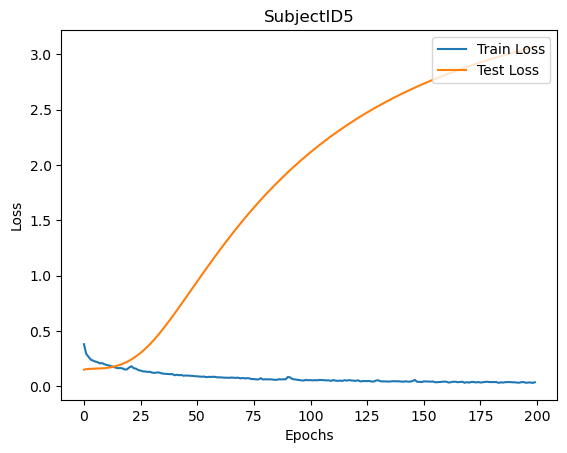

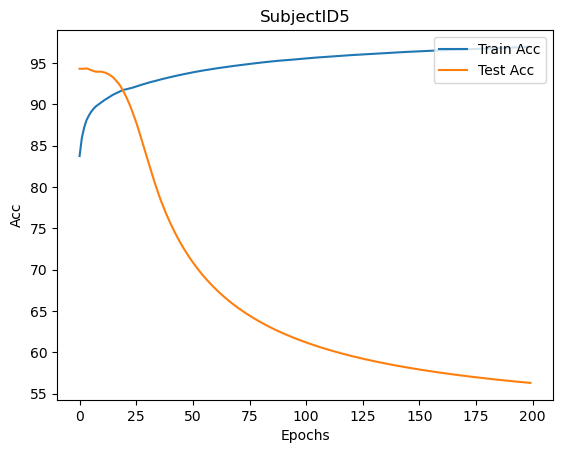


Subject 7
| epoch   0 | 0.3009 s/epoch | train loss 0.3620
| epoch   1 | 0.3051 s/epoch | train loss 0.2985
| epoch   2 | 0.3037 s/epoch | train loss 0.2884
| epoch   3 | 0.3068 s/epoch | train loss 0.2487
| epoch   4 | 0.3029 s/epoch | train loss 0.2747
| epoch   5 | 0.3037 s/epoch | train loss 0.2249
| epoch   6 | 0.3028 s/epoch | train loss 0.2082
| epoch   7 | 0.3044 s/epoch | train loss 0.1929
| epoch   8 | 0.3042 s/epoch | train loss 0.1844
| epoch   9 | 0.3045 s/epoch | train loss 0.1811
| epoch  10 | 0.3011 s/epoch | train loss 0.1747
| epoch  11 | 0.3004 s/epoch | train loss 0.1704
| epoch  12 | 0.3035 s/epoch | train loss 0.1688
| epoch  13 | 0.3009 s/epoch | train loss 0.1624
| epoch  14 | 0.3020 s/epoch | train loss 0.1552
| epoch  15 | 0.3015 s/epoch | train loss 0.1580
| epoch  16 | 0.2995 s/epoch | train loss 0.1509
| epoch  17 | 0.3033 s/epoch | train loss 0.1534
| epoch  18 | 0.3005 s/epoch | train loss 0.2168
| epoch  19 | 0.3012 s/epoch | train loss 0.2079
| epoch  

| epoch 167 | 0.3278 s/epoch | train loss 0.0175
| epoch 168 | 0.3756 s/epoch | train loss 0.0180
| epoch 169 | 0.3757 s/epoch | train loss 0.0231
| epoch 170 | 0.3988 s/epoch | train loss 0.0305
| epoch 171 | 0.3775 s/epoch | train loss 0.0217
| epoch 172 | 0.3746 s/epoch | train loss 0.0176
| epoch 173 | 0.3765 s/epoch | train loss 0.0200
| epoch 174 | 0.3665 s/epoch | train loss 0.0202
| epoch 175 | 0.3585 s/epoch | train loss 0.0165
| epoch 176 | 0.3605 s/epoch | train loss 0.0193
| epoch 177 | 0.3571 s/epoch | train loss 0.0206
| epoch 178 | 0.3528 s/epoch | train loss 0.0183
| epoch 179 | 0.3563 s/epoch | train loss 0.0217
| epoch 180 | 0.3601 s/epoch | train loss 0.0215
| epoch 181 | 0.3353 s/epoch | train loss 0.0212
| epoch 182 | 0.2940 s/epoch | train loss 0.0232
| epoch 183 | 0.2961 s/epoch | train loss 0.0932
| epoch 184 | 0.2957 s/epoch | train loss 0.0458
| epoch 185 | 0.2992 s/epoch | train loss 0.0246
| epoch 186 | 0.2937 s/epoch | train loss 0.0208
| epoch 187 | 0.3051

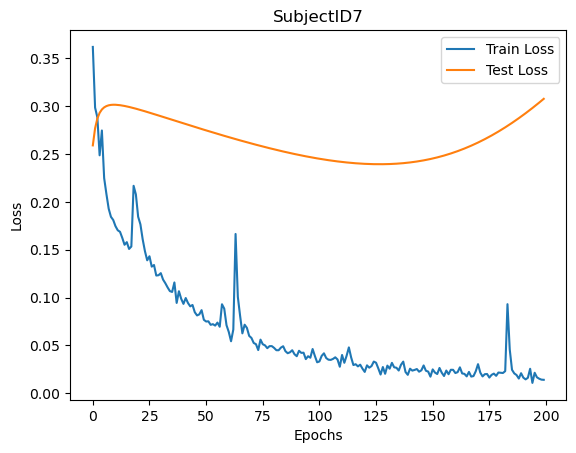

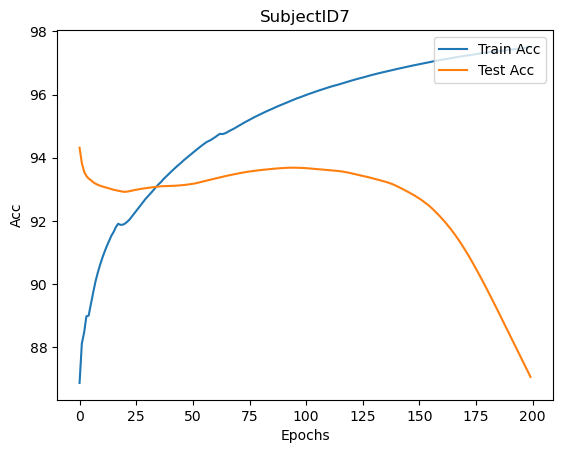

| epoch   0 | 0.2091 s/epoch | train loss 0.3961
| epoch   1 | 0.1651 s/epoch | train loss 0.2862
| epoch   2 | 0.1652 s/epoch | train loss 0.2608
| epoch   3 | 0.1653 s/epoch | train loss 0.2415
| epoch   4 | 0.1651 s/epoch | train loss 0.2306
| epoch   5 | 0.1629 s/epoch | train loss 0.2222
| epoch   6 | 0.1668 s/epoch | train loss 0.2165
| epoch   7 | 0.1663 s/epoch | train loss 0.2075
| epoch   8 | 0.1627 s/epoch | train loss 0.1992
| epoch   9 | 0.1628 s/epoch | train loss 0.2073
| epoch  10 | 0.1630 s/epoch | train loss 0.2039
| epoch  11 | 0.1657 s/epoch | train loss 0.1949
| epoch  12 | 0.1646 s/epoch | train loss 0.1841
| epoch  13 | 0.1638 s/epoch | train loss 0.1774
| epoch  14 | 0.1655 s/epoch | train loss 0.1730
| epoch  15 | 0.1672 s/epoch | train loss 0.1679
| epoch  16 | 0.1663 s/epoch | train loss 0.1675
| epoch  17 | 0.1639 s/epoch | train loss 0.1593
| epoch  18 | 0.1629 s/epoch | train loss 0.1604
| epoch  19 | 0.1640 s/epoch | train loss 0.1545
| epoch  20 | 0.1605

| epoch 168 | 0.1652 s/epoch | train loss 0.0388
| epoch 169 | 0.1648 s/epoch | train loss 0.0423
| epoch 170 | 0.1683 s/epoch | train loss 0.0430
| epoch 171 | 0.1680 s/epoch | train loss 0.0385
| epoch 172 | 0.1670 s/epoch | train loss 0.0357
| epoch 173 | 0.1686 s/epoch | train loss 0.0412
| epoch 174 | 0.1673 s/epoch | train loss 0.0378
| epoch 175 | 0.1648 s/epoch | train loss 0.0399
| epoch 176 | 0.1679 s/epoch | train loss 0.0412
| epoch 177 | 0.1671 s/epoch | train loss 0.0423
| epoch 178 | 0.1633 s/epoch | train loss 0.0426
| epoch 179 | 0.1660 s/epoch | train loss 0.0336
| epoch 180 | 0.1653 s/epoch | train loss 0.0348
| epoch 181 | 0.1641 s/epoch | train loss 0.0359
| epoch 182 | 0.1643 s/epoch | train loss 0.0408
| epoch 183 | 0.1634 s/epoch | train loss 0.0368
| epoch 184 | 0.1651 s/epoch | train loss 0.0343
| epoch 185 | 0.1621 s/epoch | train loss 0.0387
| epoch 186 | 0.1651 s/epoch | train loss 0.0355
| epoch 187 | 0.1645 s/epoch | train loss 0.0367
| epoch 188 | 0.1632

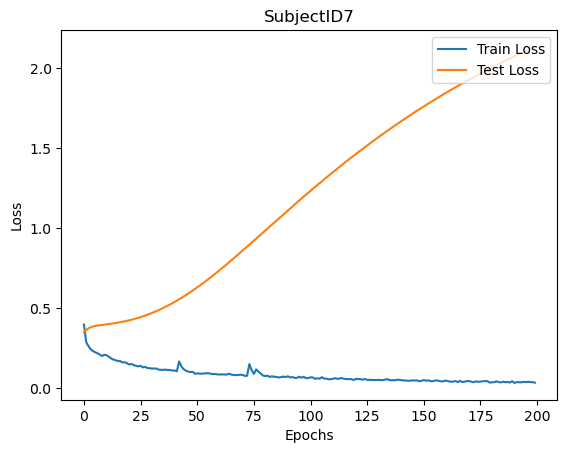

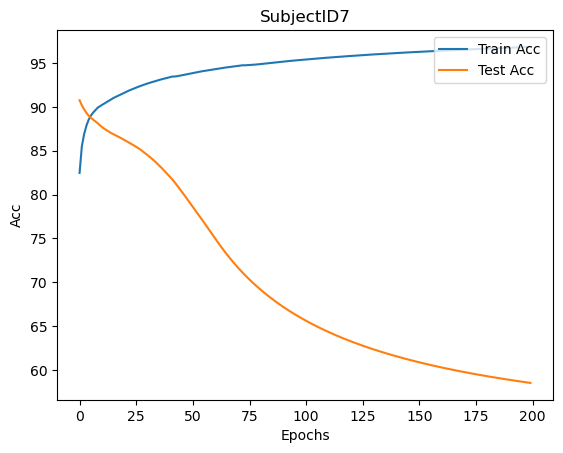


Subject 8
| epoch   0 | 0.3108 s/epoch | train loss 0.3745
| epoch   1 | 0.3057 s/epoch | train loss 0.2551
| epoch   2 | 0.3064 s/epoch | train loss 0.2374
| epoch   3 | 0.3092 s/epoch | train loss 0.2095
| epoch   4 | 0.3081 s/epoch | train loss 0.2212
| epoch   5 | 0.3068 s/epoch | train loss 0.2072
| epoch   6 | 0.3066 s/epoch | train loss 0.1861
| epoch   7 | 0.3071 s/epoch | train loss 0.1863
| epoch   8 | 0.3052 s/epoch | train loss 0.1748
| epoch   9 | 0.3060 s/epoch | train loss 0.1686
| epoch  10 | 0.3051 s/epoch | train loss 0.1635
| epoch  11 | 0.3079 s/epoch | train loss 0.1584
| epoch  12 | 0.3047 s/epoch | train loss 0.1539
| epoch  13 | 0.3061 s/epoch | train loss 0.1513
| epoch  14 | 0.3059 s/epoch | train loss 0.1432
| epoch  15 | 0.3056 s/epoch | train loss 0.1446
| epoch  16 | 0.3064 s/epoch | train loss 0.2079
| epoch  17 | 0.3063 s/epoch | train loss 0.1556
| epoch  18 | 0.3038 s/epoch | train loss 0.1518
| epoch  19 | 0.3058 s/epoch | train loss 0.1473
| epoch  

| epoch 167 | 0.3563 s/epoch | train loss 0.0180
| epoch 168 | 0.3619 s/epoch | train loss 0.0182
| epoch 169 | 0.3662 s/epoch | train loss 0.0178
| epoch 170 | 0.3513 s/epoch | train loss 0.0109
| epoch 171 | 0.3538 s/epoch | train loss 0.0142
| epoch 172 | 0.3560 s/epoch | train loss 0.0210
| epoch 173 | 0.3494 s/epoch | train loss 0.0187
| epoch 174 | 0.3522 s/epoch | train loss 0.0190
| epoch 175 | 0.3667 s/epoch | train loss 0.0165
| epoch 176 | 0.3700 s/epoch | train loss 0.0149
| epoch 177 | 0.3765 s/epoch | train loss 0.0170
| epoch 178 | 0.3658 s/epoch | train loss 0.0198
| epoch 179 | 0.3624 s/epoch | train loss 0.0209
| epoch 180 | 0.3629 s/epoch | train loss 0.0197
| epoch 181 | 0.3640 s/epoch | train loss 0.0186
| epoch 182 | 0.3694 s/epoch | train loss 0.0171
| epoch 183 | 0.3624 s/epoch | train loss 0.0166
| epoch 184 | 0.3741 s/epoch | train loss 0.0162
| epoch 185 | 0.3753 s/epoch | train loss 0.0200
| epoch 186 | 0.3636 s/epoch | train loss 0.0208
| epoch 187 | 0.3653

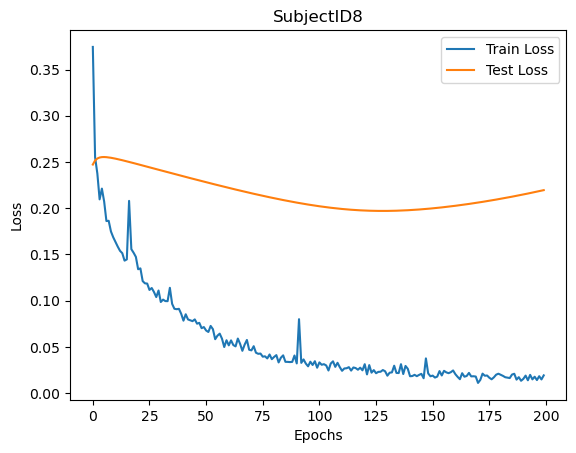

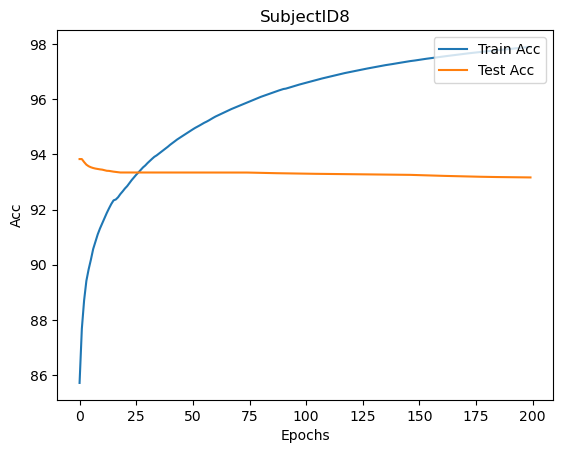

| epoch   0 | 0.1959 s/epoch | train loss 0.3938
| epoch   1 | 0.1942 s/epoch | train loss 0.2880
| epoch   2 | 0.1938 s/epoch | train loss 0.2590
| epoch   3 | 0.1919 s/epoch | train loss 0.2384
| epoch   4 | 0.1889 s/epoch | train loss 0.2283
| epoch   5 | 0.1931 s/epoch | train loss 0.2224
| epoch   6 | 0.1891 s/epoch | train loss 0.2107
| epoch   7 | 0.1918 s/epoch | train loss 0.2069
| epoch   8 | 0.1935 s/epoch | train loss 0.1975
| epoch   9 | 0.1717 s/epoch | train loss 0.1928
| epoch  10 | 0.1978 s/epoch | train loss 0.1965
| epoch  11 | 0.1633 s/epoch | train loss 0.1895
| epoch  12 | 0.1642 s/epoch | train loss 0.1820
| epoch  13 | 0.1594 s/epoch | train loss 0.1784
| epoch  14 | 0.1616 s/epoch | train loss 0.1695
| epoch  15 | 0.2533 s/epoch | train loss 0.1700
| epoch  16 | 0.1888 s/epoch | train loss 0.1643
| epoch  17 | 0.1654 s/epoch | train loss 0.1641
| epoch  18 | 0.1640 s/epoch | train loss 0.1610
| epoch  19 | 0.1648 s/epoch | train loss 0.1585
| epoch  20 | 0.1611

| epoch 168 | 0.1973 s/epoch | train loss 0.0428
| epoch 169 | 0.1952 s/epoch | train loss 0.0400
| epoch 170 | 0.2016 s/epoch | train loss 0.0445
| epoch 171 | 0.2040 s/epoch | train loss 0.0417
| epoch 172 | 0.1950 s/epoch | train loss 0.0508
| epoch 173 | 0.1932 s/epoch | train loss 0.0382
| epoch 174 | 0.1943 s/epoch | train loss 0.0411
| epoch 175 | 0.1953 s/epoch | train loss 0.0359
| epoch 176 | 0.1995 s/epoch | train loss 0.0408
| epoch 177 | 0.2008 s/epoch | train loss 0.0418
| epoch 178 | 0.1976 s/epoch | train loss 0.0409
| epoch 179 | 0.1986 s/epoch | train loss 0.0408
| epoch 180 | 0.1933 s/epoch | train loss 0.0405
| epoch 181 | 0.1958 s/epoch | train loss 0.0413
| epoch 182 | 0.1864 s/epoch | train loss 0.0366
| epoch 183 | 0.1901 s/epoch | train loss 0.0348
| epoch 184 | 0.1956 s/epoch | train loss 0.0427
| epoch 185 | 0.1951 s/epoch | train loss 0.0394
| epoch 186 | 0.1865 s/epoch | train loss 0.0428
| epoch 187 | 0.2009 s/epoch | train loss 0.0396
| epoch 188 | 0.2074

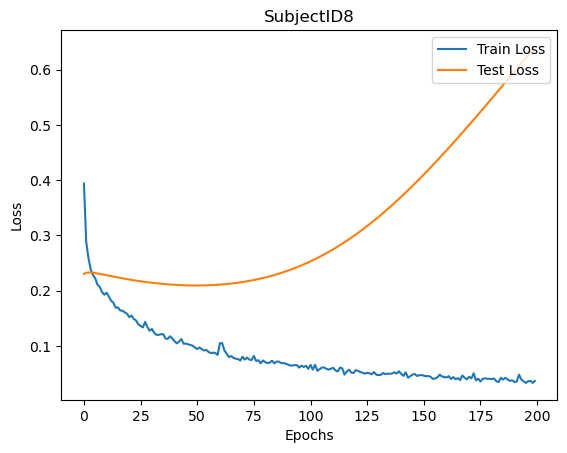

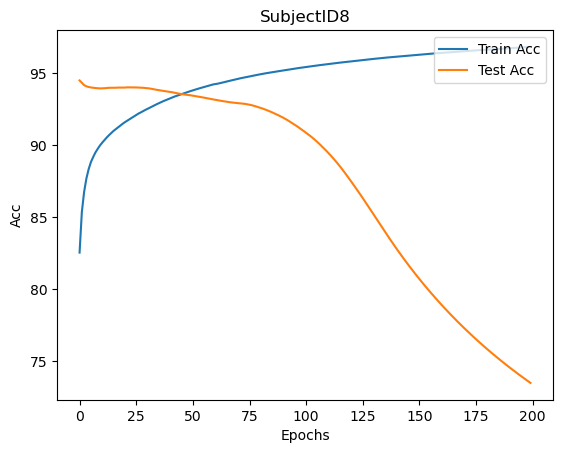


Subject 9
| epoch   0 | 0.3276 s/epoch | train loss 0.3559
| epoch   1 | 0.3080 s/epoch | train loss 0.2581
| epoch   2 | 0.3107 s/epoch | train loss 0.2310
| epoch   3 | 0.3040 s/epoch | train loss 0.2058
| epoch   4 | 0.3001 s/epoch | train loss 0.2024
| epoch   5 | 0.2993 s/epoch | train loss 0.1921
| epoch   6 | 0.2959 s/epoch | train loss 0.1880
| epoch   7 | 0.3064 s/epoch | train loss 0.1799
| epoch   8 | 0.3081 s/epoch | train loss 0.1768
| epoch   9 | 0.3157 s/epoch | train loss 0.1761
| epoch  10 | 0.3800 s/epoch | train loss 0.2780
| epoch  11 | 0.3702 s/epoch | train loss 0.2225
| epoch  12 | 0.3475 s/epoch | train loss 0.2065
| epoch  13 | 0.3563 s/epoch | train loss 0.1895
| epoch  14 | 0.3613 s/epoch | train loss 0.1783
| epoch  15 | 0.3563 s/epoch | train loss 0.1693
| epoch  16 | 0.3508 s/epoch | train loss 0.1581
| epoch  17 | 0.3445 s/epoch | train loss 0.1533
| epoch  18 | 0.3591 s/epoch | train loss 0.1471
| epoch  19 | 0.3609 s/epoch | train loss 0.1446
| epoch  

| epoch 167 | 0.3026 s/epoch | train loss 0.0147
| epoch 168 | 0.3017 s/epoch | train loss 0.0186
| epoch 169 | 0.3020 s/epoch | train loss 0.0148
| epoch 170 | 0.3025 s/epoch | train loss 0.0153
| epoch 171 | 0.3050 s/epoch | train loss 0.0195
| epoch 172 | 0.3033 s/epoch | train loss 0.0168
| epoch 173 | 0.3145 s/epoch | train loss 0.0265
| epoch 174 | 0.3050 s/epoch | train loss 0.0156
| epoch 175 | 0.3073 s/epoch | train loss 0.0233
| epoch 176 | 0.3076 s/epoch | train loss 0.0182
| epoch 177 | 0.3053 s/epoch | train loss 0.0152
| epoch 178 | 0.3062 s/epoch | train loss 0.0161
| epoch 179 | 0.3018 s/epoch | train loss 0.0225
| epoch 180 | 0.3067 s/epoch | train loss 0.0203
| epoch 181 | 0.3042 s/epoch | train loss 0.0147
| epoch 182 | 0.3047 s/epoch | train loss 0.0177
| epoch 183 | 0.3041 s/epoch | train loss 0.0171
| epoch 184 | 0.3044 s/epoch | train loss 0.0132
| epoch 185 | 0.3038 s/epoch | train loss 0.0158
| epoch 186 | 0.3056 s/epoch | train loss 0.0168
| epoch 187 | 0.3061

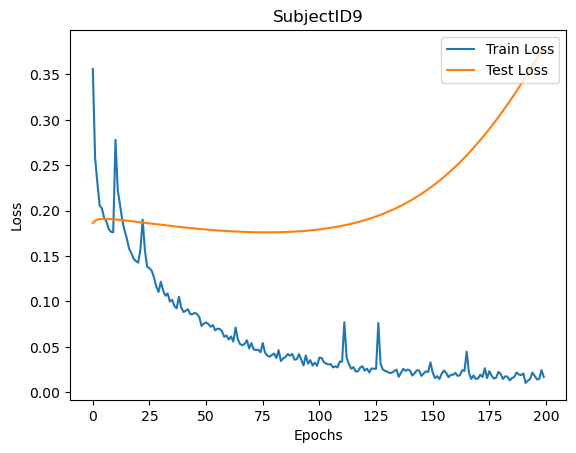

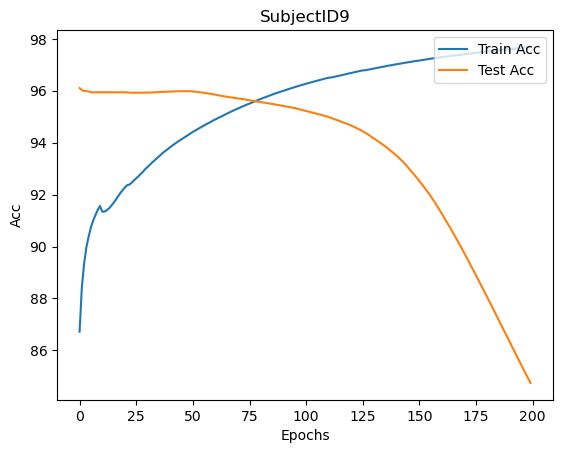

| epoch   0 | 0.1642 s/epoch | train loss 0.3996
| epoch   1 | 0.1650 s/epoch | train loss 0.2900
| epoch   2 | 0.1605 s/epoch | train loss 0.2673
| epoch   3 | 0.1617 s/epoch | train loss 0.2513
| epoch   4 | 0.1626 s/epoch | train loss 0.2384
| epoch   5 | 0.1942 s/epoch | train loss 0.2309
| epoch   6 | 0.1950 s/epoch | train loss 0.2196
| epoch   7 | 0.2068 s/epoch | train loss 0.2088
| epoch   8 | 0.1988 s/epoch | train loss 0.1987
| epoch   9 | 0.1952 s/epoch | train loss 0.1956
| epoch  10 | 0.2037 s/epoch | train loss 0.1968
| epoch  11 | 0.1970 s/epoch | train loss 0.1865
| epoch  12 | 0.2427 s/epoch | train loss 0.1844
| epoch  13 | 0.2152 s/epoch | train loss 0.1763
| epoch  14 | 0.2038 s/epoch | train loss 0.1739
| epoch  15 | 0.1945 s/epoch | train loss 0.1674
| epoch  16 | 0.1955 s/epoch | train loss 0.1656
| epoch  17 | 0.2061 s/epoch | train loss 0.1536
| epoch  18 | 0.2019 s/epoch | train loss 0.1591
| epoch  19 | 0.1952 s/epoch | train loss 0.1533
| epoch  20 | 0.1957

| epoch 168 | 0.1625 s/epoch | train loss 0.0360
| epoch 169 | 0.1648 s/epoch | train loss 0.0375
| epoch 170 | 0.1630 s/epoch | train loss 0.0428
| epoch 171 | 0.1630 s/epoch | train loss 0.0391
| epoch 172 | 0.1597 s/epoch | train loss 0.0342
| epoch 173 | 0.1634 s/epoch | train loss 0.0363
| epoch 174 | 0.1645 s/epoch | train loss 0.0373
| epoch 175 | 0.1616 s/epoch | train loss 0.0321
| epoch 176 | 0.1620 s/epoch | train loss 0.0338
| epoch 177 | 0.1610 s/epoch | train loss 0.0357
| epoch 178 | 0.1628 s/epoch | train loss 0.0371
| epoch 179 | 0.1625 s/epoch | train loss 0.0337
| epoch 180 | 0.1644 s/epoch | train loss 0.0369
| epoch 181 | 0.1653 s/epoch | train loss 0.0309
| epoch 182 | 0.1610 s/epoch | train loss 0.0354
| epoch 183 | 0.1635 s/epoch | train loss 0.0375
| epoch 184 | 0.1598 s/epoch | train loss 0.0363
| epoch 185 | 0.1600 s/epoch | train loss 0.0317
| epoch 186 | 0.1621 s/epoch | train loss 0.0346
| epoch 187 | 0.1611 s/epoch | train loss 0.0354
| epoch 188 | 0.1605

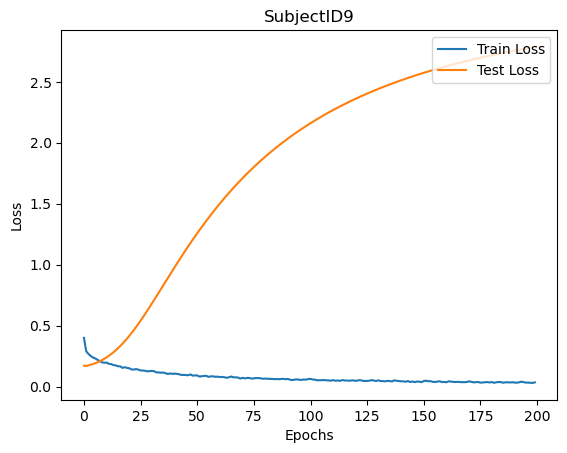

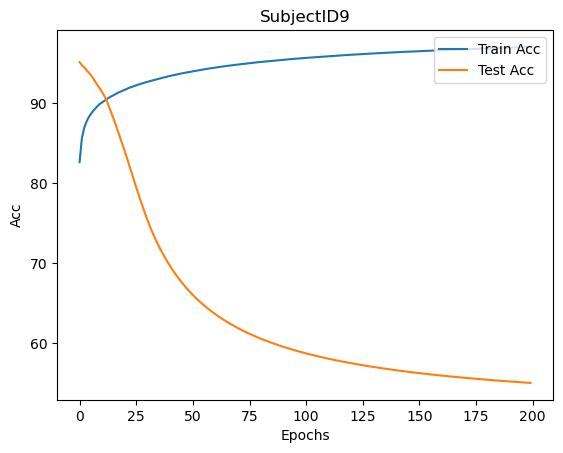


Subject 10
| epoch   0 | 0.2853 s/epoch | train loss 0.3734
| epoch   1 | 0.2884 s/epoch | train loss 0.3477
| epoch   2 | 0.2905 s/epoch | train loss 0.3768
| epoch   3 | 0.2871 s/epoch | train loss 0.3409
| epoch   4 | 0.2874 s/epoch | train loss 0.2815
| epoch   5 | 0.2874 s/epoch | train loss 0.2564
| epoch   6 | 0.2871 s/epoch | train loss 0.3213
| epoch   7 | 0.2869 s/epoch | train loss 0.3269
| epoch   8 | 0.2866 s/epoch | train loss 0.2593
| epoch   9 | 0.2966 s/epoch | train loss 0.3098
| epoch  10 | 0.2972 s/epoch | train loss 0.2621
| epoch  11 | 0.2965 s/epoch | train loss 0.2482
| epoch  12 | 0.2965 s/epoch | train loss 0.2195
| epoch  13 | 0.2970 s/epoch | train loss 0.2099
| epoch  14 | 0.2958 s/epoch | train loss 0.3037
| epoch  15 | 0.2941 s/epoch | train loss 0.2226
| epoch  16 | 0.2981 s/epoch | train loss 0.2544
| epoch  17 | 0.2953 s/epoch | train loss 0.2148
| epoch  18 | 0.2974 s/epoch | train loss 0.2044
| epoch  19 | 0.2968 s/epoch | train loss 0.1893
| epoch 

| epoch 167 | 0.2464 s/epoch | train loss 0.0303
| epoch 168 | 0.2478 s/epoch | train loss 0.0209
| epoch 169 | 0.2445 s/epoch | train loss 0.0187
| epoch 170 | 0.2484 s/epoch | train loss 0.0216
| epoch 171 | 0.2481 s/epoch | train loss 0.0204
| epoch 172 | 0.2449 s/epoch | train loss 0.0338
| epoch 173 | 0.2470 s/epoch | train loss 0.0191
| epoch 174 | 0.2464 s/epoch | train loss 0.0220
| epoch 175 | 0.2473 s/epoch | train loss 0.0272
| epoch 176 | 0.2465 s/epoch | train loss 0.0195
| epoch 177 | 0.2453 s/epoch | train loss 0.0202
| epoch 178 | 0.2464 s/epoch | train loss 0.0245
| epoch 179 | 0.2452 s/epoch | train loss 0.0184
| epoch 180 | 0.2466 s/epoch | train loss 0.0143
| epoch 181 | 0.2473 s/epoch | train loss 0.0331
| epoch 182 | 0.2486 s/epoch | train loss 0.0228
| epoch 183 | 0.2459 s/epoch | train loss 0.0213
| epoch 184 | 0.2449 s/epoch | train loss 0.0161
| epoch 185 | 0.2455 s/epoch | train loss 0.0172
| epoch 186 | 0.2455 s/epoch | train loss 0.0199
| epoch 187 | 0.2460

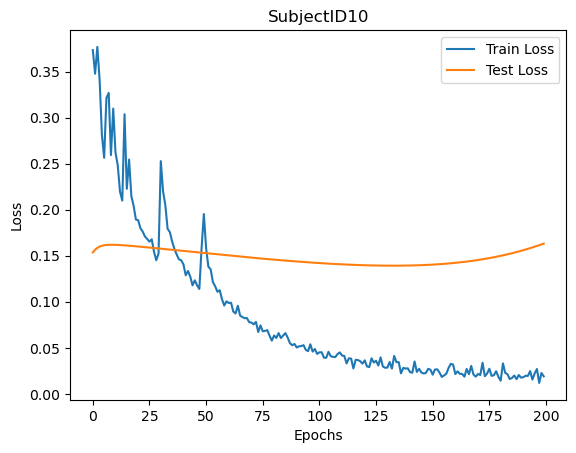

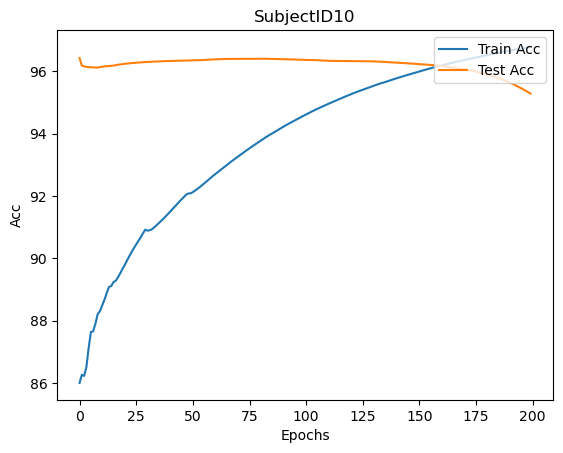

| epoch   0 | 0.1352 s/epoch | train loss 0.3684
| epoch   1 | 0.1326 s/epoch | train loss 0.2832
| epoch   2 | 0.1342 s/epoch | train loss 0.2551
| epoch   3 | 0.1375 s/epoch | train loss 0.2475
| epoch   4 | 0.1327 s/epoch | train loss 0.2327
| epoch   5 | 0.1371 s/epoch | train loss 0.2180
| epoch   6 | 0.1352 s/epoch | train loss 0.2133
| epoch   7 | 0.1334 s/epoch | train loss 0.2106
| epoch   8 | 0.1346 s/epoch | train loss 0.2007
| epoch   9 | 0.1326 s/epoch | train loss 0.1896
| epoch  10 | 0.1344 s/epoch | train loss 0.1918
| epoch  11 | 0.1354 s/epoch | train loss 0.1868
| epoch  12 | 0.1352 s/epoch | train loss 0.1749
| epoch  13 | 0.1330 s/epoch | train loss 0.1782
| epoch  14 | 0.1346 s/epoch | train loss 0.1729
| epoch  15 | 0.1347 s/epoch | train loss 0.1648
| epoch  16 | 0.1351 s/epoch | train loss 0.1639
| epoch  17 | 0.1346 s/epoch | train loss 0.1563
| epoch  18 | 0.1359 s/epoch | train loss 0.1562
| epoch  19 | 0.1360 s/epoch | train loss 0.1519
| epoch  20 | 0.1336

| epoch 168 | 0.1350 s/epoch | train loss 0.0371
| epoch 169 | 0.1344 s/epoch | train loss 0.0364
| epoch 170 | 0.1339 s/epoch | train loss 0.0339
| epoch 171 | 0.1339 s/epoch | train loss 0.0410
| epoch 172 | 0.1339 s/epoch | train loss 0.0379
| epoch 173 | 0.1339 s/epoch | train loss 0.0350
| epoch 174 | 0.1338 s/epoch | train loss 0.0364
| epoch 175 | 0.1351 s/epoch | train loss 0.0384
| epoch 176 | 0.1321 s/epoch | train loss 0.0338
| epoch 177 | 0.1367 s/epoch | train loss 0.0359
| epoch 178 | 0.1344 s/epoch | train loss 0.0407
| epoch 179 | 0.1359 s/epoch | train loss 0.0358
| epoch 180 | 0.1349 s/epoch | train loss 0.0352
| epoch 181 | 0.1352 s/epoch | train loss 0.0350
| epoch 182 | 0.1351 s/epoch | train loss 0.0413
| epoch 183 | 0.1352 s/epoch | train loss 0.0421
| epoch 184 | 0.1339 s/epoch | train loss 0.0366
| epoch 185 | 0.1344 s/epoch | train loss 0.0343
| epoch 186 | 0.1372 s/epoch | train loss 0.0347
| epoch 187 | 0.1338 s/epoch | train loss 0.0325
| epoch 188 | 0.1345

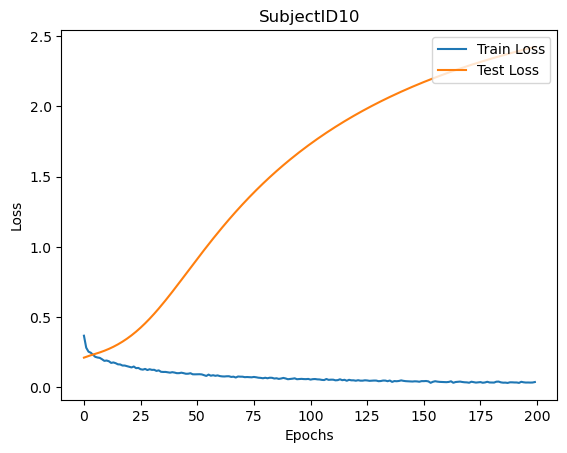

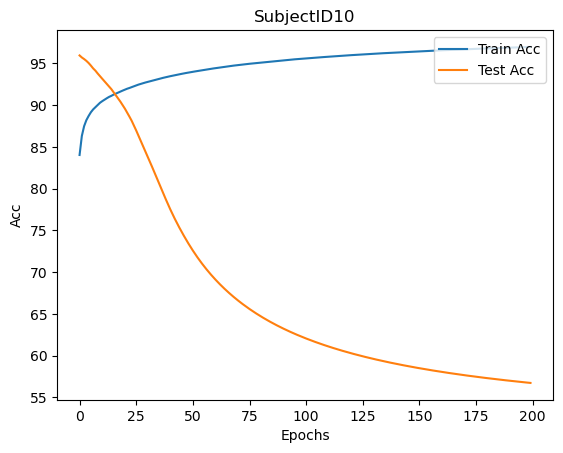


Subject 11
| epoch   0 | 0.2449 s/epoch | train loss 0.3278
| epoch   1 | 0.2466 s/epoch | train loss 0.2364
| epoch   2 | 0.2458 s/epoch | train loss 0.2122
| epoch   3 | 0.2455 s/epoch | train loss 0.2034
| epoch   4 | 0.2477 s/epoch | train loss 0.1945
| epoch   5 | 0.2439 s/epoch | train loss 0.1981
| epoch   6 | 0.2475 s/epoch | train loss 0.1893
| epoch   7 | 0.2447 s/epoch | train loss 0.1775
| epoch   8 | 0.2459 s/epoch | train loss 0.1660
| epoch   9 | 0.2444 s/epoch | train loss 0.1519
| epoch  10 | 0.2434 s/epoch | train loss 0.1587
| epoch  11 | 0.2438 s/epoch | train loss 0.1492
| epoch  12 | 0.2442 s/epoch | train loss 0.1458
| epoch  13 | 0.2444 s/epoch | train loss 0.1423
| epoch  14 | 0.2444 s/epoch | train loss 0.1387
| epoch  15 | 0.2455 s/epoch | train loss 0.1367
| epoch  16 | 0.2428 s/epoch | train loss 0.1305
| epoch  17 | 0.2458 s/epoch | train loss 0.1300
| epoch  18 | 0.2436 s/epoch | train loss 0.1271
| epoch  19 | 0.2455 s/epoch | train loss 0.1261
| epoch 

| epoch 167 | 0.1950 s/epoch | train loss 0.0201
| epoch 168 | 0.1948 s/epoch | train loss 0.0205
| epoch 169 | 0.1945 s/epoch | train loss 0.0197
| epoch 170 | 0.1951 s/epoch | train loss 0.0154
| epoch 171 | 0.1942 s/epoch | train loss 0.0212
| epoch 172 | 0.1972 s/epoch | train loss 0.0187
| epoch 173 | 0.1944 s/epoch | train loss 0.0178
| epoch 174 | 0.1952 s/epoch | train loss 0.0166
| epoch 175 | 0.1953 s/epoch | train loss 0.0251
| epoch 176 | 0.1962 s/epoch | train loss 0.0169
| epoch 177 | 0.1962 s/epoch | train loss 0.0180
| epoch 178 | 0.1973 s/epoch | train loss 0.0164
| epoch 179 | 0.1965 s/epoch | train loss 0.0191
| epoch 180 | 0.1948 s/epoch | train loss 0.0196
| epoch 181 | 0.1961 s/epoch | train loss 0.0185
| epoch 182 | 0.1955 s/epoch | train loss 0.0164
| epoch 183 | 0.1945 s/epoch | train loss 0.0272
| epoch 184 | 0.1959 s/epoch | train loss 0.0294
| epoch 185 | 0.1947 s/epoch | train loss 0.0209
| epoch 186 | 0.1950 s/epoch | train loss 0.0171
| epoch 187 | 0.1962

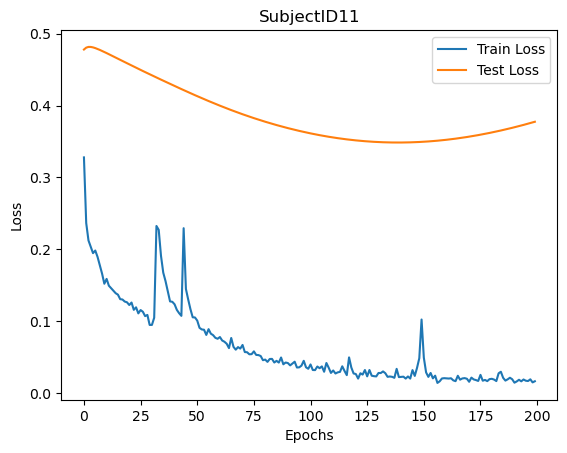

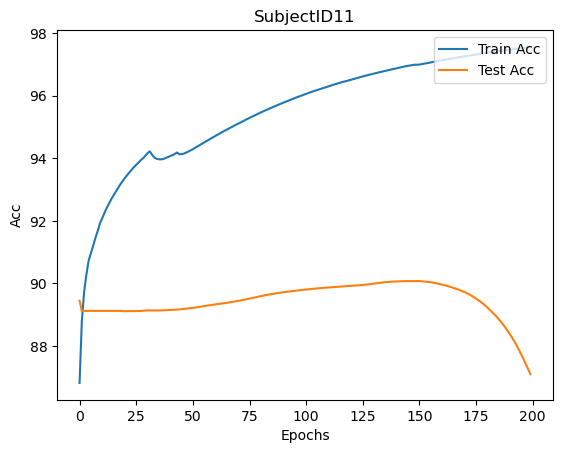

| epoch   0 | 0.1078 s/epoch | train loss 0.3904
| epoch   1 | 0.1080 s/epoch | train loss 0.2801
| epoch   2 | 0.1066 s/epoch | train loss 0.2570
| epoch   3 | 0.1101 s/epoch | train loss 0.2404
| epoch   4 | 0.1076 s/epoch | train loss 0.2249
| epoch   5 | 0.1087 s/epoch | train loss 0.2172
| epoch   6 | 0.1064 s/epoch | train loss 0.2131
| epoch   7 | 0.1081 s/epoch | train loss 0.1945
| epoch   8 | 0.1073 s/epoch | train loss 0.1929
| epoch   9 | 0.1070 s/epoch | train loss 0.1838
| epoch  10 | 0.1100 s/epoch | train loss 0.1782
| epoch  11 | 0.1068 s/epoch | train loss 0.1736
| epoch  12 | 0.1076 s/epoch | train loss 0.1750
| epoch  13 | 0.1073 s/epoch | train loss 0.1619
| epoch  14 | 0.1076 s/epoch | train loss 0.1642
| epoch  15 | 0.1093 s/epoch | train loss 0.1551
| epoch  16 | 0.1072 s/epoch | train loss 0.1572
| epoch  17 | 0.1101 s/epoch | train loss 0.1561
| epoch  18 | 0.1081 s/epoch | train loss 0.1450
| epoch  19 | 0.1085 s/epoch | train loss 0.1403
| epoch  20 | 0.1075

| epoch 168 | 0.1063 s/epoch | train loss 0.0393
| epoch 169 | 0.1104 s/epoch | train loss 0.0409
| epoch 170 | 0.1094 s/epoch | train loss 0.0342
| epoch 171 | 0.1059 s/epoch | train loss 0.0379
| epoch 172 | 0.1060 s/epoch | train loss 0.0371
| epoch 173 | 0.1069 s/epoch | train loss 0.0384
| epoch 174 | 0.1090 s/epoch | train loss 0.0358
| epoch 175 | 0.1097 s/epoch | train loss 0.0396
| epoch 176 | 0.1059 s/epoch | train loss 0.0346
| epoch 177 | 0.1075 s/epoch | train loss 0.0359
| epoch 178 | 0.1055 s/epoch | train loss 0.0340
| epoch 179 | 0.1073 s/epoch | train loss 0.0327
| epoch 180 | 0.1095 s/epoch | train loss 0.0391
| epoch 181 | 0.1080 s/epoch | train loss 0.0358
| epoch 182 | 0.1054 s/epoch | train loss 0.0325
| epoch 183 | 0.1069 s/epoch | train loss 0.0359
| epoch 184 | 0.1079 s/epoch | train loss 0.0358
| epoch 185 | 0.1104 s/epoch | train loss 0.0355
| epoch 186 | 0.1085 s/epoch | train loss 0.0376
| epoch 187 | 0.1083 s/epoch | train loss 0.0360
| epoch 188 | 0.1073

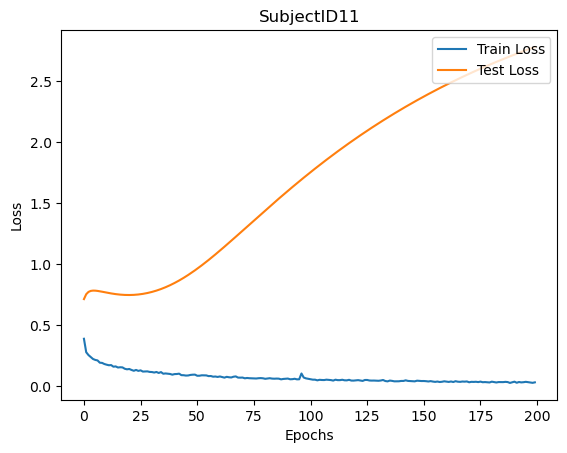

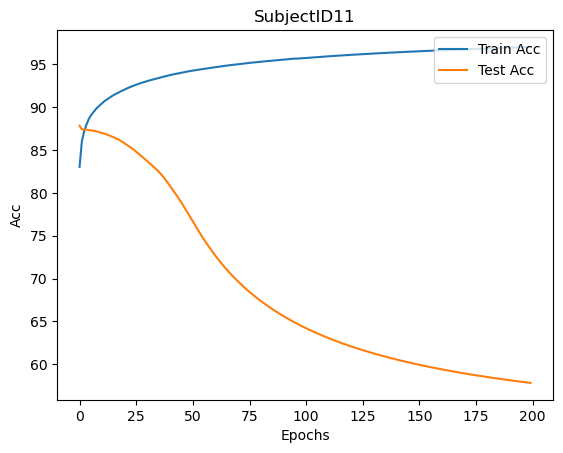


Subject 12
| epoch   0 | 0.1890 s/epoch | train loss 0.3725
| epoch   1 | 0.1891 s/epoch | train loss 0.3050
| epoch   2 | 0.1899 s/epoch | train loss 0.2924
| epoch   3 | 0.1894 s/epoch | train loss 0.2831
| epoch   4 | 0.1916 s/epoch | train loss 0.2449
| epoch   5 | 0.1898 s/epoch | train loss 0.2433
| epoch   6 | 0.1879 s/epoch | train loss 0.3184
| epoch   7 | 0.1886 s/epoch | train loss 0.3005
| epoch   8 | 0.1883 s/epoch | train loss 0.2807
| epoch   9 | 0.1881 s/epoch | train loss 0.3201
| epoch  10 | 0.1904 s/epoch | train loss 0.2394
| epoch  11 | 0.1857 s/epoch | train loss 0.2109
| epoch  12 | 0.1900 s/epoch | train loss 0.2014
| epoch  13 | 0.1884 s/epoch | train loss 0.1925
| epoch  14 | 0.1885 s/epoch | train loss 0.1851
| epoch  15 | 0.1863 s/epoch | train loss 0.1794
| epoch  16 | 0.1904 s/epoch | train loss 0.1779
| epoch  17 | 0.1889 s/epoch | train loss 0.1645
| epoch  18 | 0.1895 s/epoch | train loss 0.1591
| epoch  19 | 0.1896 s/epoch | train loss 0.1555
| epoch 

| epoch 167 | 0.1899 s/epoch | train loss 0.0201
| epoch 168 | 0.1877 s/epoch | train loss 0.0452
| epoch 169 | 0.1907 s/epoch | train loss 0.0287
| epoch 170 | 0.1887 s/epoch | train loss 0.0164
| epoch 171 | 0.1883 s/epoch | train loss 0.0198
| epoch 172 | 0.1908 s/epoch | train loss 0.0138
| epoch 173 | 0.1912 s/epoch | train loss 0.0237
| epoch 174 | 0.1896 s/epoch | train loss 0.0145
| epoch 175 | 0.1894 s/epoch | train loss 0.0218
| epoch 176 | 0.1902 s/epoch | train loss 0.0191
| epoch 177 | 0.1895 s/epoch | train loss 0.0216
| epoch 178 | 0.1891 s/epoch | train loss 0.0157
| epoch 179 | 0.1885 s/epoch | train loss 0.0165
| epoch 180 | 0.1888 s/epoch | train loss 0.0220
| epoch 181 | 0.1879 s/epoch | train loss 0.0191
| epoch 182 | 0.1887 s/epoch | train loss 0.0166
| epoch 183 | 0.1894 s/epoch | train loss 0.0119
| epoch 184 | 0.1914 s/epoch | train loss 0.0190
| epoch 185 | 0.1897 s/epoch | train loss 0.0177
| epoch 186 | 0.1883 s/epoch | train loss 0.0127
| epoch 187 | 0.1918

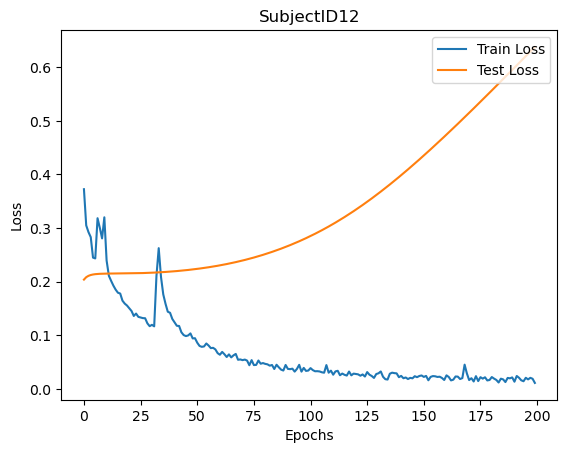

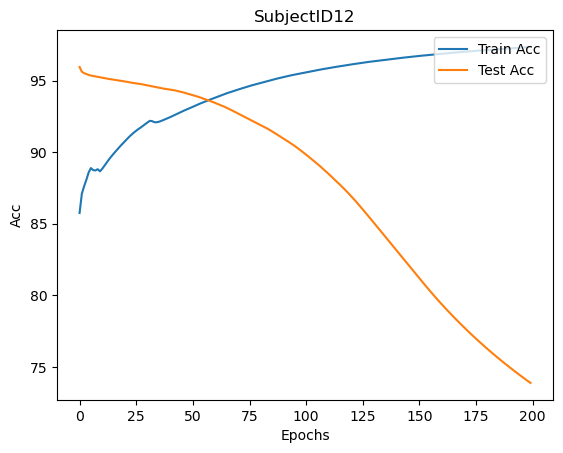

| epoch   0 | 0.1103 s/epoch | train loss 0.3840
| epoch   1 | 0.1074 s/epoch | train loss 0.2848
| epoch   2 | 0.1071 s/epoch | train loss 0.2654
| epoch   3 | 0.1091 s/epoch | train loss 0.2450
| epoch   4 | 0.1074 s/epoch | train loss 0.2359
| epoch   5 | 0.1082 s/epoch | train loss 0.2246
| epoch   6 | 0.1099 s/epoch | train loss 0.2140
| epoch   7 | 0.1075 s/epoch | train loss 0.2023
| epoch   8 | 0.1065 s/epoch | train loss 0.2050
| epoch   9 | 0.1095 s/epoch | train loss 0.1903
| epoch  10 | 0.1100 s/epoch | train loss 0.1855
| epoch  11 | 0.1096 s/epoch | train loss 0.1816
| epoch  12 | 0.1070 s/epoch | train loss 0.1765
| epoch  13 | 0.1086 s/epoch | train loss 0.1731
| epoch  14 | 0.1085 s/epoch | train loss 0.1675
| epoch  15 | 0.1070 s/epoch | train loss 0.1824
| epoch  16 | 0.1075 s/epoch | train loss 0.1737
| epoch  17 | 0.1067 s/epoch | train loss 0.1633
| epoch  18 | 0.1070 s/epoch | train loss 0.1582
| epoch  19 | 0.1071 s/epoch | train loss 0.1585
| epoch  20 | 0.1107

| epoch 168 | 0.1070 s/epoch | train loss 0.0390
| epoch 169 | 0.1089 s/epoch | train loss 0.0381
| epoch 170 | 0.1085 s/epoch | train loss 0.0410
| epoch 171 | 0.1062 s/epoch | train loss 0.0363
| epoch 172 | 0.1095 s/epoch | train loss 0.0396
| epoch 173 | 0.1083 s/epoch | train loss 0.0435
| epoch 174 | 0.1092 s/epoch | train loss 0.0363
| epoch 175 | 0.1065 s/epoch | train loss 0.0382
| epoch 176 | 0.1077 s/epoch | train loss 0.0383
| epoch 177 | 0.1081 s/epoch | train loss 0.0332
| epoch 178 | 0.1102 s/epoch | train loss 0.0389
| epoch 179 | 0.1084 s/epoch | train loss 0.0359
| epoch 180 | 0.1084 s/epoch | train loss 0.0373
| epoch 181 | 0.1095 s/epoch | train loss 0.0386
| epoch 182 | 0.1088 s/epoch | train loss 0.0349
| epoch 183 | 0.1086 s/epoch | train loss 0.0363
| epoch 184 | 0.1068 s/epoch | train loss 0.0379
| epoch 185 | 0.1076 s/epoch | train loss 0.0362
| epoch 186 | 0.1089 s/epoch | train loss 0.0354
| epoch 187 | 0.1080 s/epoch | train loss 0.0389
| epoch 188 | 0.1085

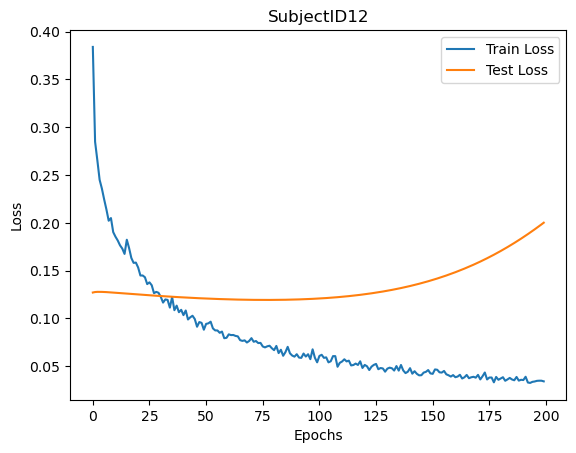

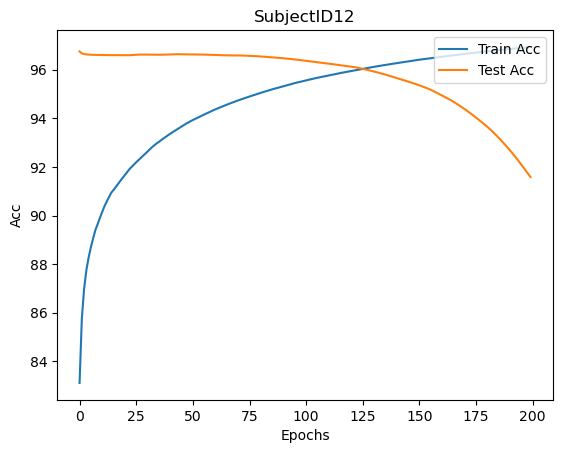


Subject 13
| epoch   0 | 0.1884 s/epoch | train loss 0.3452
| epoch   1 | 0.1903 s/epoch | train loss 0.2538
| epoch   2 | 0.1893 s/epoch | train loss 0.2440
| epoch   3 | 0.1850 s/epoch | train loss 0.2111
| epoch   4 | 0.1901 s/epoch | train loss 0.2052
| epoch   5 | 0.1875 s/epoch | train loss 0.1876
| epoch   6 | 0.1875 s/epoch | train loss 0.1858
| epoch   7 | 0.1894 s/epoch | train loss 0.1690
| epoch   8 | 0.1888 s/epoch | train loss 0.1755
| epoch   9 | 0.1910 s/epoch | train loss 0.1653
| epoch  10 | 0.1884 s/epoch | train loss 0.1559
| epoch  11 | 0.1899 s/epoch | train loss 0.1565
| epoch  12 | 0.1859 s/epoch | train loss 0.1477
| epoch  13 | 0.1853 s/epoch | train loss 0.1507
| epoch  14 | 0.1879 s/epoch | train loss 0.1476
| epoch  15 | 0.1911 s/epoch | train loss 0.1414
| epoch  16 | 0.1857 s/epoch | train loss 0.1356
| epoch  17 | 0.1884 s/epoch | train loss 0.1319
| epoch  18 | 0.1878 s/epoch | train loss 0.1323
| epoch  19 | 0.1890 s/epoch | train loss 0.1308
| epoch 

| epoch 167 | 0.1902 s/epoch | train loss 0.0195
| epoch 168 | 0.1866 s/epoch | train loss 0.0194
| epoch 169 | 0.1909 s/epoch | train loss 0.0171
| epoch 170 | 0.1929 s/epoch | train loss 0.0177
| epoch 171 | 0.1901 s/epoch | train loss 0.0197
| epoch 172 | 0.1891 s/epoch | train loss 0.0227
| epoch 173 | 0.1893 s/epoch | train loss 0.0212
| epoch 174 | 0.1898 s/epoch | train loss 0.0207
| epoch 175 | 0.1885 s/epoch | train loss 0.0211
| epoch 176 | 0.1912 s/epoch | train loss 0.0205
| epoch 177 | 0.1894 s/epoch | train loss 0.0183
| epoch 178 | 0.1902 s/epoch | train loss 0.0150
| epoch 179 | 0.1906 s/epoch | train loss 0.0090
| epoch 180 | 0.1887 s/epoch | train loss 0.0142
| epoch 181 | 0.1886 s/epoch | train loss 0.0241
| epoch 182 | 0.1905 s/epoch | train loss 0.0153
| epoch 183 | 0.1913 s/epoch | train loss 0.0179
| epoch 184 | 0.1916 s/epoch | train loss 0.0160
| epoch 185 | 0.1889 s/epoch | train loss 0.0214
| epoch 186 | 0.1905 s/epoch | train loss 0.0204
| epoch 187 | 0.1887

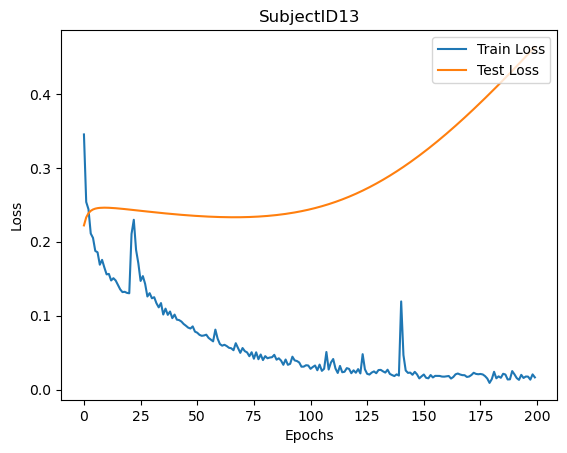

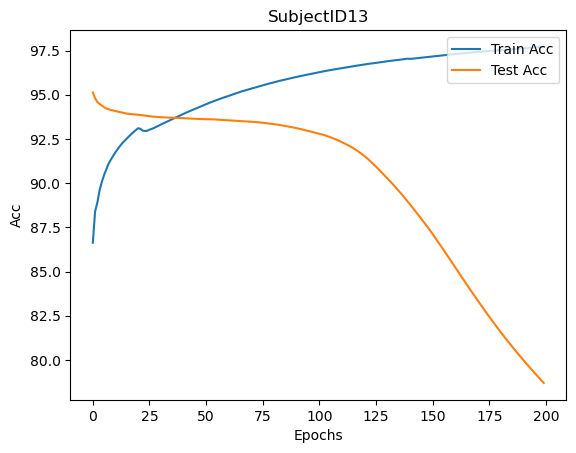

| epoch   0 | 0.1078 s/epoch | train loss 0.3932
| epoch   1 | 0.1077 s/epoch | train loss 0.2847
| epoch   2 | 0.1093 s/epoch | train loss 0.2597
| epoch   3 | 0.1067 s/epoch | train loss 0.2567
| epoch   4 | 0.1079 s/epoch | train loss 0.2310
| epoch   5 | 0.1081 s/epoch | train loss 0.2248
| epoch   6 | 0.1086 s/epoch | train loss 0.2148
| epoch   7 | 0.1063 s/epoch | train loss 0.2072
| epoch   8 | 0.1076 s/epoch | train loss 0.2069
| epoch   9 | 0.1090 s/epoch | train loss 0.2003
| epoch  10 | 0.1052 s/epoch | train loss 0.1871
| epoch  11 | 0.1089 s/epoch | train loss 0.1847
| epoch  12 | 0.1083 s/epoch | train loss 0.1819
| epoch  13 | 0.1075 s/epoch | train loss 0.1827
| epoch  14 | 0.1073 s/epoch | train loss 0.1718
| epoch  15 | 0.1075 s/epoch | train loss 0.1702
| epoch  16 | 0.1082 s/epoch | train loss 0.1667
| epoch  17 | 0.1068 s/epoch | train loss 0.1638
| epoch  18 | 0.1078 s/epoch | train loss 0.1616
| epoch  19 | 0.1095 s/epoch | train loss 0.1590
| epoch  20 | 0.1088

| epoch 168 | 0.0835 s/epoch | train loss 0.0358
| epoch 169 | 0.0842 s/epoch | train loss 0.0406
| epoch 170 | 0.0839 s/epoch | train loss 0.0386
| epoch 171 | 0.0835 s/epoch | train loss 0.0396
| epoch 172 | 0.0824 s/epoch | train loss 0.0367
| epoch 173 | 0.0827 s/epoch | train loss 0.0406
| epoch 174 | 0.0848 s/epoch | train loss 0.0415
| epoch 175 | 0.0844 s/epoch | train loss 0.0365
| epoch 176 | 0.0832 s/epoch | train loss 0.0321
| epoch 177 | 0.0853 s/epoch | train loss 0.0358
| epoch 178 | 0.0834 s/epoch | train loss 0.0383
| epoch 179 | 0.0843 s/epoch | train loss 0.0369
| epoch 180 | 0.0832 s/epoch | train loss 0.0375
| epoch 181 | 0.0835 s/epoch | train loss 0.0334
| epoch 182 | 0.0851 s/epoch | train loss 0.0385
| epoch 183 | 0.0829 s/epoch | train loss 0.0347
| epoch 184 | 0.0843 s/epoch | train loss 0.0367
| epoch 185 | 0.0837 s/epoch | train loss 0.0403
| epoch 186 | 0.0843 s/epoch | train loss 0.0398
| epoch 187 | 0.0839 s/epoch | train loss 0.0360
| epoch 188 | 0.0831

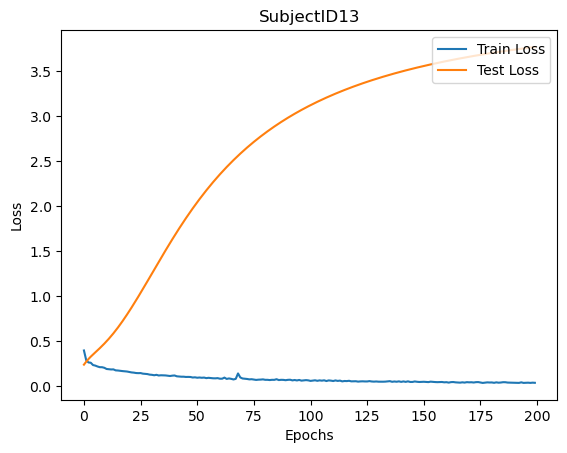

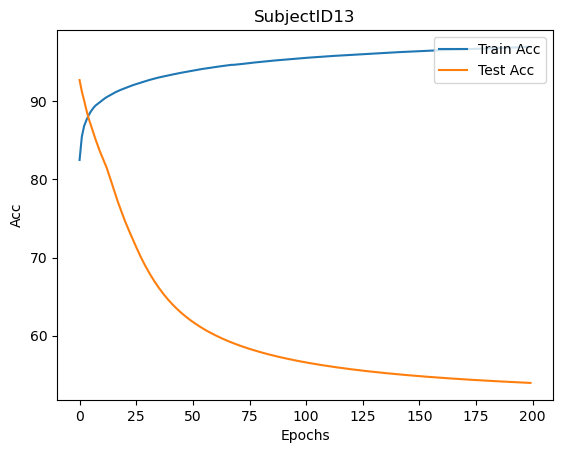


Subject 14
| epoch   0 | 0.1428 s/epoch | train loss 0.3240
| epoch   1 | 0.1444 s/epoch | train loss 0.2493
| epoch   2 | 0.1438 s/epoch | train loss 0.2728
| epoch   3 | 0.1432 s/epoch | train loss 0.2283
| epoch   4 | 0.1426 s/epoch | train loss 0.2123
| epoch   5 | 0.1428 s/epoch | train loss 0.1892
| epoch   6 | 0.1442 s/epoch | train loss 0.1827
| epoch   7 | 0.1438 s/epoch | train loss 0.1806
| epoch   8 | 0.1440 s/epoch | train loss 0.1730
| epoch   9 | 0.1437 s/epoch | train loss 0.1713
| epoch  10 | 0.1432 s/epoch | train loss 0.1693
| epoch  11 | 0.1444 s/epoch | train loss 0.1539
| epoch  12 | 0.1423 s/epoch | train loss 0.1480
| epoch  13 | 0.1445 s/epoch | train loss 0.1415
| epoch  14 | 0.1451 s/epoch | train loss 0.1402
| epoch  15 | 0.1423 s/epoch | train loss 0.1546
| epoch  16 | 0.1450 s/epoch | train loss 0.1371
| epoch  17 | 0.1438 s/epoch | train loss 0.1336
| epoch  18 | 0.1437 s/epoch | train loss 0.1406
| epoch  19 | 0.1442 s/epoch | train loss 0.3154
| epoch 

| epoch 167 | 0.1439 s/epoch | train loss 0.0218
| epoch 168 | 0.1454 s/epoch | train loss 0.0210
| epoch 169 | 0.1446 s/epoch | train loss 0.0225
| epoch 170 | 0.1448 s/epoch | train loss 0.0211
| epoch 171 | 0.1436 s/epoch | train loss 0.0272
| epoch 172 | 0.1434 s/epoch | train loss 0.0212
| epoch 173 | 0.1444 s/epoch | train loss 0.0215
| epoch 174 | 0.1439 s/epoch | train loss 0.0208
| epoch 175 | 0.1441 s/epoch | train loss 0.0205
| epoch 176 | 0.1454 s/epoch | train loss 0.0161
| epoch 177 | 0.1439 s/epoch | train loss 0.0191
| epoch 178 | 0.1436 s/epoch | train loss 0.0169
| epoch 179 | 0.1445 s/epoch | train loss 0.0209
| epoch 180 | 0.1439 s/epoch | train loss 0.0165
| epoch 181 | 0.1439 s/epoch | train loss 0.0182
| epoch 182 | 0.1442 s/epoch | train loss 0.0163
| epoch 183 | 0.1441 s/epoch | train loss 0.0202
| epoch 184 | 0.1435 s/epoch | train loss 0.0208
| epoch 185 | 0.1444 s/epoch | train loss 0.0159
| epoch 186 | 0.1449 s/epoch | train loss 0.0145
| epoch 187 | 0.1429

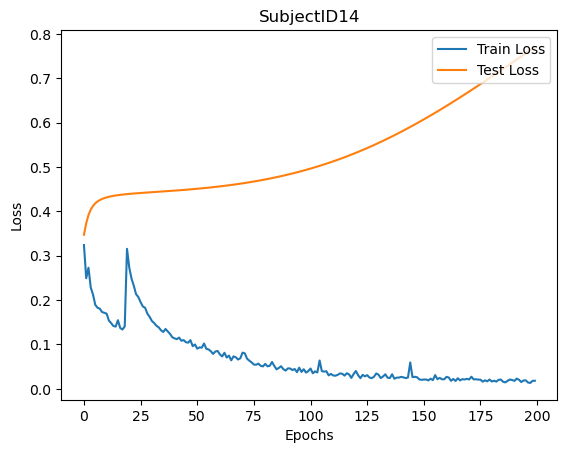

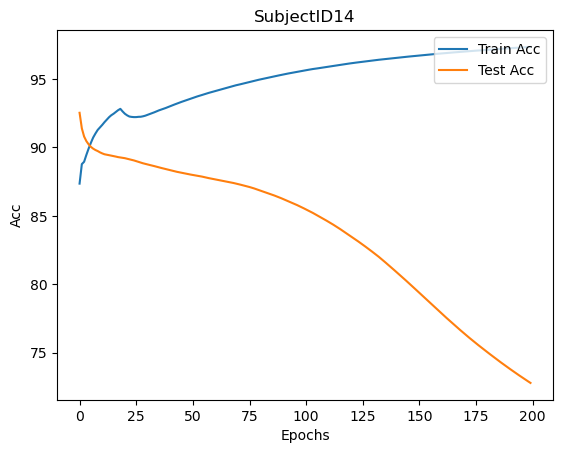

| epoch   0 | 0.0836 s/epoch | train loss 0.3857
| epoch   1 | 0.0831 s/epoch | train loss 0.2812
| epoch   2 | 0.0845 s/epoch | train loss 0.2494
| epoch   3 | 0.0842 s/epoch | train loss 0.2386
| epoch   4 | 0.0849 s/epoch | train loss 0.2290
| epoch   5 | 0.0831 s/epoch | train loss 0.2140
| epoch   6 | 0.0849 s/epoch | train loss 0.2032
| epoch   7 | 0.0840 s/epoch | train loss 0.2046
| epoch   8 | 0.0841 s/epoch | train loss 0.1895
| epoch   9 | 0.0836 s/epoch | train loss 0.1923
| epoch  10 | 0.0848 s/epoch | train loss 0.1888
| epoch  11 | 0.0837 s/epoch | train loss 0.1774
| epoch  12 | 0.0835 s/epoch | train loss 0.1793
| epoch  13 | 0.0831 s/epoch | train loss 0.1710
| epoch  14 | 0.0852 s/epoch | train loss 0.1715
| epoch  15 | 0.0843 s/epoch | train loss 0.1651
| epoch  16 | 0.0845 s/epoch | train loss 0.1606
| epoch  17 | 0.0839 s/epoch | train loss 0.1671
| epoch  18 | 0.0851 s/epoch | train loss 0.1588
| epoch  19 | 0.0840 s/epoch | train loss 0.1546
| epoch  20 | 0.0856

| epoch 168 | 0.0653 s/epoch | train loss 0.0410
| epoch 169 | 0.0648 s/epoch | train loss 0.0382
| epoch 170 | 0.0665 s/epoch | train loss 0.0379
| epoch 171 | 0.0655 s/epoch | train loss 0.0387
| epoch 172 | 0.0650 s/epoch | train loss 0.0406
| epoch 173 | 0.0649 s/epoch | train loss 0.0378
| epoch 174 | 0.0665 s/epoch | train loss 0.0388
| epoch 175 | 0.0648 s/epoch | train loss 0.0376
| epoch 176 | 0.0661 s/epoch | train loss 0.0366
| epoch 177 | 0.0646 s/epoch | train loss 0.0414
| epoch 178 | 0.0649 s/epoch | train loss 0.0404
| epoch 179 | 0.0648 s/epoch | train loss 0.0381
| epoch 180 | 0.0650 s/epoch | train loss 0.0367
| epoch 181 | 0.0643 s/epoch | train loss 0.0435
| epoch 182 | 0.0640 s/epoch | train loss 0.0346
| epoch 183 | 0.0640 s/epoch | train loss 0.0370
| epoch 184 | 0.0645 s/epoch | train loss 0.0386
| epoch 185 | 0.0646 s/epoch | train loss 0.0398
| epoch 186 | 0.0637 s/epoch | train loss 0.0372
| epoch 187 | 0.0645 s/epoch | train loss 0.0364
| epoch 188 | 0.0644

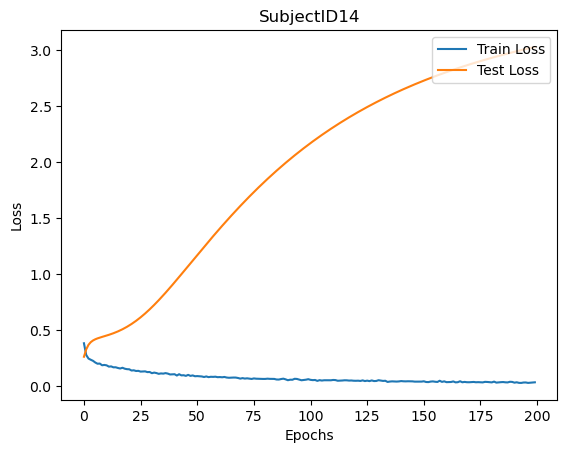

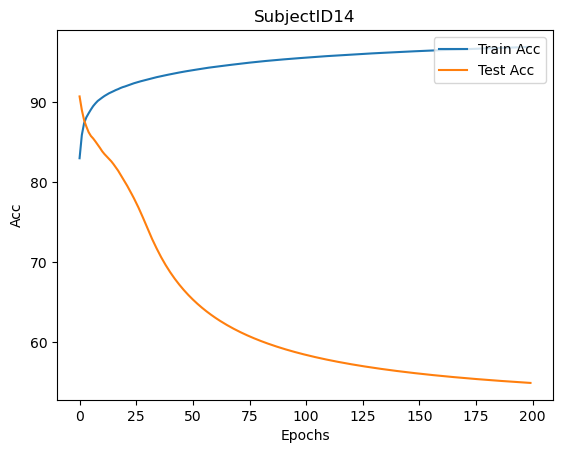


Subject 15
| epoch   0 | 0.0903 s/epoch | train loss 0.3446
| epoch   1 | 0.0894 s/epoch | train loss 0.2566
| epoch   2 | 0.0887 s/epoch | train loss 0.2327
| epoch   3 | 0.0900 s/epoch | train loss 0.2135
| epoch   4 | 0.0898 s/epoch | train loss 0.2031
| epoch   5 | 0.0899 s/epoch | train loss 0.1956
| epoch   6 | 0.0899 s/epoch | train loss 0.2032
| epoch   7 | 0.0901 s/epoch | train loss 0.1768
| epoch   8 | 0.0894 s/epoch | train loss 0.6052
| epoch   9 | 0.0898 s/epoch | train loss 0.3506
| epoch  10 | 0.0902 s/epoch | train loss 0.3351
| epoch  11 | 0.0905 s/epoch | train loss 0.2841
| epoch  12 | 0.0905 s/epoch | train loss 0.2368
| epoch  13 | 0.0904 s/epoch | train loss 0.2389
| epoch  14 | 0.0890 s/epoch | train loss 0.3723
| epoch  15 | 0.0899 s/epoch | train loss 0.3067
| epoch  16 | 0.0892 s/epoch | train loss 0.2844
| epoch  17 | 0.0905 s/epoch | train loss 0.2578
| epoch  18 | 0.0900 s/epoch | train loss 0.2418
| epoch  19 | 0.0898 s/epoch | train loss 0.2301
| epoch 

| epoch 167 | 0.0903 s/epoch | train loss 0.0312
| epoch 168 | 0.0900 s/epoch | train loss 0.0386
| epoch 169 | 0.0900 s/epoch | train loss 0.0245
| epoch 170 | 0.0899 s/epoch | train loss 0.0290
| epoch 171 | 0.0898 s/epoch | train loss 0.0274
| epoch 172 | 0.0916 s/epoch | train loss 0.0288
| epoch 173 | 0.0906 s/epoch | train loss 0.0338
| epoch 174 | 0.0899 s/epoch | train loss 0.0349
| epoch 175 | 0.0905 s/epoch | train loss 0.0248
| epoch 176 | 0.0903 s/epoch | train loss 0.0374
| epoch 177 | 0.0896 s/epoch | train loss 0.0268
| epoch 178 | 0.0894 s/epoch | train loss 0.0258
| epoch 179 | 0.0910 s/epoch | train loss 0.0277
| epoch 180 | 0.0897 s/epoch | train loss 0.0262
| epoch 181 | 0.0897 s/epoch | train loss 0.0330
| epoch 182 | 0.0908 s/epoch | train loss 0.0357
| epoch 183 | 0.0903 s/epoch | train loss 0.0262
| epoch 184 | 0.0903 s/epoch | train loss 0.0256
| epoch 185 | 0.0894 s/epoch | train loss 0.0279
| epoch 186 | 0.0897 s/epoch | train loss 0.0245
| epoch 187 | 0.0914

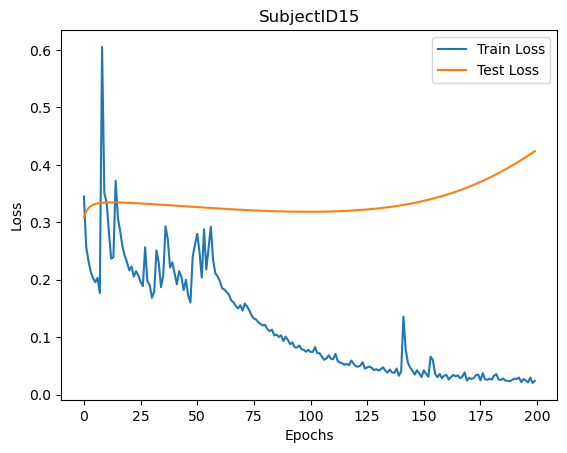

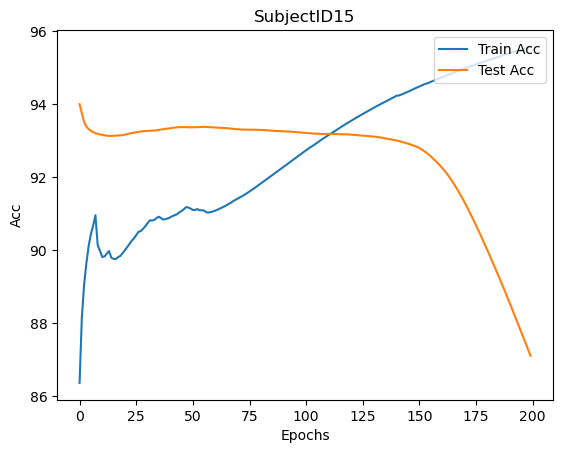

| epoch   0 | 0.0647 s/epoch | train loss 0.3949
| epoch   1 | 0.0652 s/epoch | train loss 0.2875
| epoch   2 | 0.0652 s/epoch | train loss 0.2721
| epoch   3 | 0.0657 s/epoch | train loss 0.2582
| epoch   4 | 0.0649 s/epoch | train loss 0.2374
| epoch   5 | 0.0652 s/epoch | train loss 0.2275
| epoch   6 | 0.0629 s/epoch | train loss 0.2130
| epoch   7 | 0.0644 s/epoch | train loss 0.2106
| epoch   8 | 0.0658 s/epoch | train loss 0.2847
| epoch   9 | 0.0643 s/epoch | train loss 0.2272
| epoch  10 | 0.0657 s/epoch | train loss 0.2194
| epoch  11 | 0.0632 s/epoch | train loss 0.1997
| epoch  12 | 0.0644 s/epoch | train loss 0.1915
| epoch  13 | 0.0637 s/epoch | train loss 0.1916
| epoch  14 | 0.0652 s/epoch | train loss 0.1817
| epoch  15 | 0.0653 s/epoch | train loss 0.1801
| epoch  16 | 0.0654 s/epoch | train loss 0.1755
| epoch  17 | 0.0648 s/epoch | train loss 0.1745
| epoch  18 | 0.0647 s/epoch | train loss 0.1678
| epoch  19 | 0.0646 s/epoch | train loss 0.2135
| epoch  20 | 0.0666

| epoch 168 | 0.0646 s/epoch | train loss 0.0395
| epoch 169 | 0.0638 s/epoch | train loss 0.0357
| epoch 170 | 0.0657 s/epoch | train loss 0.0364
| epoch 171 | 0.0640 s/epoch | train loss 0.0375
| epoch 172 | 0.0648 s/epoch | train loss 0.0377
| epoch 173 | 0.0656 s/epoch | train loss 0.0340
| epoch 174 | 0.0644 s/epoch | train loss 0.0368
| epoch 175 | 0.0633 s/epoch | train loss 0.0384
| epoch 176 | 0.0635 s/epoch | train loss 0.0352
| epoch 177 | 0.0636 s/epoch | train loss 0.0319
| epoch 178 | 0.0646 s/epoch | train loss 0.0396
| epoch 179 | 0.0656 s/epoch | train loss 0.0350
| epoch 180 | 0.0664 s/epoch | train loss 0.0362
| epoch 181 | 0.0649 s/epoch | train loss 0.0371
| epoch 182 | 0.0647 s/epoch | train loss 0.0333
| epoch 183 | 0.0653 s/epoch | train loss 0.0373
| epoch 184 | 0.0649 s/epoch | train loss 0.0332
| epoch 185 | 0.0645 s/epoch | train loss 0.0364
| epoch 186 | 0.0643 s/epoch | train loss 0.0334
| epoch 187 | 0.0644 s/epoch | train loss 0.0380
| epoch 188 | 0.0644

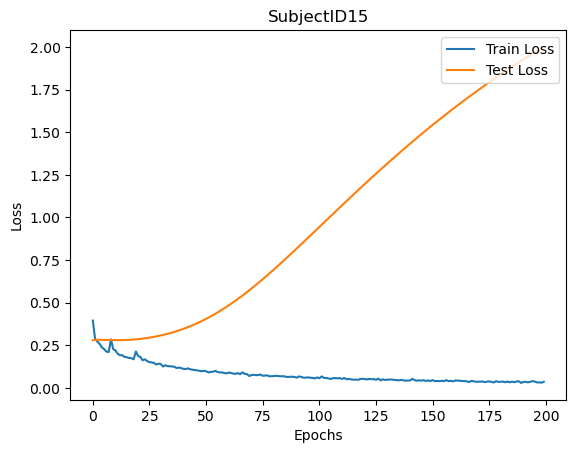

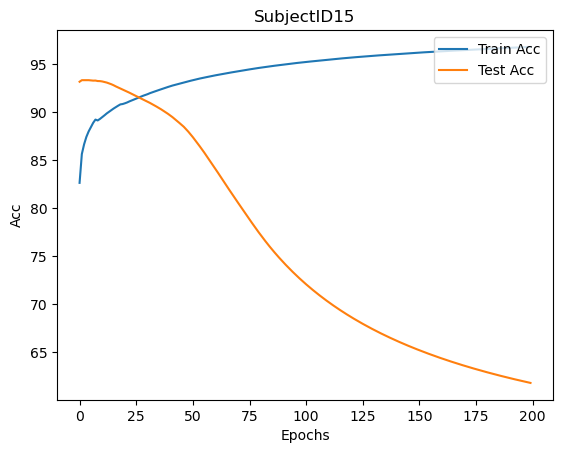


Subject 16
| epoch   0 | 0.0906 s/epoch | train loss 0.3391
| epoch   1 | 0.0899 s/epoch | train loss 0.2738
| epoch   2 | 0.0904 s/epoch | train loss 0.2522
| epoch   3 | 0.0903 s/epoch | train loss 0.2231
| epoch   4 | 0.0901 s/epoch | train loss 0.2141
| epoch   5 | 0.0898 s/epoch | train loss 0.1991
| epoch   6 | 0.0897 s/epoch | train loss 0.1963
| epoch   7 | 0.0903 s/epoch | train loss 0.1889
| epoch   8 | 0.0889 s/epoch | train loss 0.1788
| epoch   9 | 0.0896 s/epoch | train loss 0.1797
| epoch  10 | 0.0889 s/epoch | train loss 0.1775
| epoch  11 | 0.0890 s/epoch | train loss 0.1682
| epoch  12 | 0.0897 s/epoch | train loss 0.1649
| epoch  13 | 0.0906 s/epoch | train loss 0.1664
| epoch  14 | 0.0896 s/epoch | train loss 0.1525
| epoch  15 | 0.0901 s/epoch | train loss 0.1491
| epoch  16 | 0.0884 s/epoch | train loss 0.1398
| epoch  17 | 0.0903 s/epoch | train loss 0.1422
| epoch  18 | 0.0902 s/epoch | train loss 0.1389
| epoch  19 | 0.0895 s/epoch | train loss 0.1357
| epoch 

| epoch 167 | 0.0902 s/epoch | train loss 0.0158
| epoch 168 | 0.0904 s/epoch | train loss 0.0472
| epoch 169 | 0.0904 s/epoch | train loss 0.0355
| epoch 170 | 0.0903 s/epoch | train loss 0.0223
| epoch 171 | 0.0895 s/epoch | train loss 0.0150
| epoch 172 | 0.0902 s/epoch | train loss 0.0180
| epoch 173 | 0.0904 s/epoch | train loss 0.0259
| epoch 174 | 0.0910 s/epoch | train loss 0.0155
| epoch 175 | 0.0903 s/epoch | train loss 0.0146
| epoch 176 | 0.0907 s/epoch | train loss 0.0196
| epoch 177 | 0.0911 s/epoch | train loss 0.0170
| epoch 178 | 0.0903 s/epoch | train loss 0.0158
| epoch 179 | 0.0904 s/epoch | train loss 0.0177
| epoch 180 | 0.0902 s/epoch | train loss 0.0202
| epoch 181 | 0.0895 s/epoch | train loss 0.0214
| epoch 182 | 0.0911 s/epoch | train loss 0.0182
| epoch 183 | 0.0909 s/epoch | train loss 0.0136
| epoch 184 | 0.0909 s/epoch | train loss 0.0127
| epoch 185 | 0.0908 s/epoch | train loss 0.0202
| epoch 186 | 0.0905 s/epoch | train loss 0.0161
| epoch 187 | 0.0905

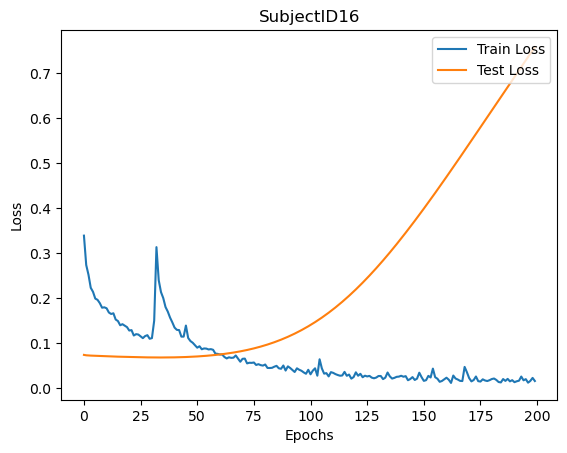

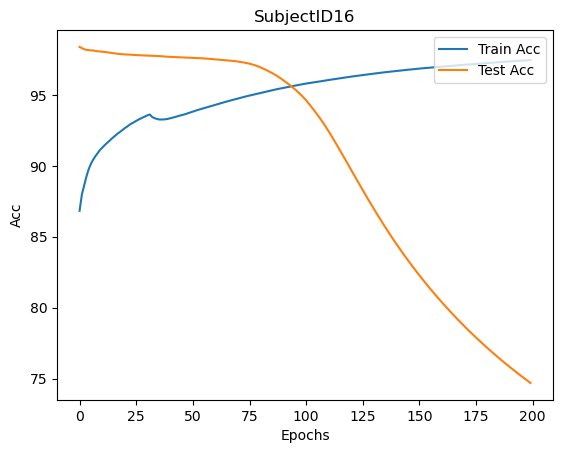

| epoch   0 | 0.0648 s/epoch | train loss 0.3989
| epoch   1 | 0.0655 s/epoch | train loss 0.3081
| epoch   2 | 0.0636 s/epoch | train loss 0.2770
| epoch   3 | 0.0645 s/epoch | train loss 0.2521
| epoch   4 | 0.0648 s/epoch | train loss 0.2387
| epoch   5 | 0.0644 s/epoch | train loss 0.2343
| epoch   6 | 0.0641 s/epoch | train loss 0.2245
| epoch   7 | 0.0650 s/epoch | train loss 0.2079
| epoch   8 | 0.0647 s/epoch | train loss 0.2033
| epoch   9 | 0.0644 s/epoch | train loss 0.2048
| epoch  10 | 0.0633 s/epoch | train loss 0.1944
| epoch  11 | 0.0646 s/epoch | train loss 0.1888
| epoch  12 | 0.0649 s/epoch | train loss 0.1863
| epoch  13 | 0.0647 s/epoch | train loss 0.1769
| epoch  14 | 0.0643 s/epoch | train loss 0.1741
| epoch  15 | 0.0648 s/epoch | train loss 0.1729
| epoch  16 | 0.0648 s/epoch | train loss 0.1686
| epoch  17 | 0.0643 s/epoch | train loss 0.1693
| epoch  18 | 0.0641 s/epoch | train loss 0.1643
| epoch  19 | 0.0643 s/epoch | train loss 0.1635
| epoch  20 | 0.0619

| epoch 168 | 0.0659 s/epoch | train loss 0.0396
| epoch 169 | 0.0659 s/epoch | train loss 0.0415
| epoch 170 | 0.0641 s/epoch | train loss 0.0400
| epoch 171 | 0.0638 s/epoch | train loss 0.0358
| epoch 172 | 0.0655 s/epoch | train loss 0.0406
| epoch 173 | 0.0649 s/epoch | train loss 0.0415
| epoch 174 | 0.0642 s/epoch | train loss 0.0405
| epoch 175 | 0.0656 s/epoch | train loss 0.0377
| epoch 176 | 0.0654 s/epoch | train loss 0.0374
| epoch 177 | 0.0643 s/epoch | train loss 0.0426
| epoch 178 | 0.0640 s/epoch | train loss 0.0408
| epoch 179 | 0.0651 s/epoch | train loss 0.0416
| epoch 180 | 0.0646 s/epoch | train loss 0.0380
| epoch 181 | 0.0657 s/epoch | train loss 0.0378
| epoch 182 | 0.0646 s/epoch | train loss 0.0390
| epoch 183 | 0.0639 s/epoch | train loss 0.0391
| epoch 184 | 0.0648 s/epoch | train loss 0.0372
| epoch 185 | 0.0649 s/epoch | train loss 0.0387
| epoch 186 | 0.0650 s/epoch | train loss 0.0405
| epoch 187 | 0.0654 s/epoch | train loss 0.0375
| epoch 188 | 0.0648

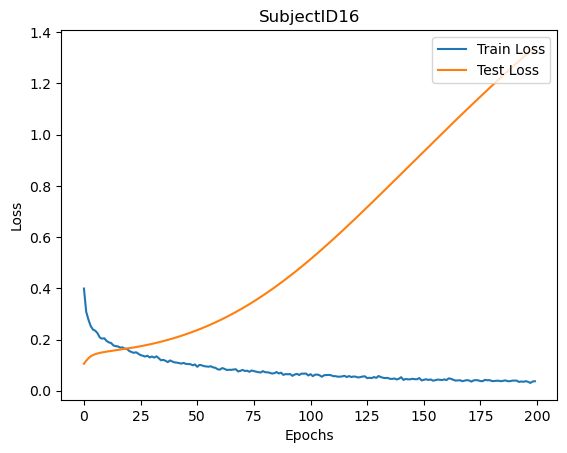

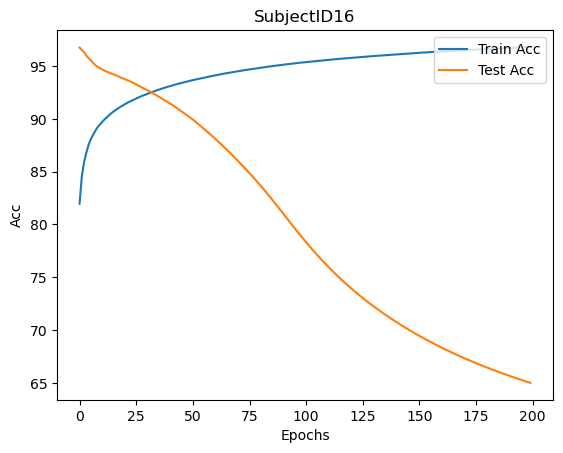


Subject 18
| epoch   0 | 0.0893 s/epoch | train loss 0.3343
| epoch   1 | 0.0900 s/epoch | train loss 0.2474
| epoch   2 | 0.0898 s/epoch | train loss 0.2203
| epoch   3 | 0.0898 s/epoch | train loss 0.2085
| epoch   4 | 0.0890 s/epoch | train loss 0.1982
| epoch   5 | 0.0906 s/epoch | train loss 0.1928
| epoch   6 | 0.0891 s/epoch | train loss 0.1885
| epoch   7 | 0.0892 s/epoch | train loss 0.1826
| epoch   8 | 0.0895 s/epoch | train loss 0.1768
| epoch   9 | 0.0891 s/epoch | train loss 0.1670
| epoch  10 | 0.0896 s/epoch | train loss 0.4384
| epoch  11 | 0.0889 s/epoch | train loss 0.3740
| epoch  12 | 0.0898 s/epoch | train loss 0.2738
| epoch  13 | 0.0891 s/epoch | train loss 0.2451
| epoch  14 | 0.0901 s/epoch | train loss 0.2419
| epoch  15 | 0.0904 s/epoch | train loss 0.2177
| epoch  16 | 0.0904 s/epoch | train loss 0.2160
| epoch  17 | 0.0897 s/epoch | train loss 0.1943
| epoch  18 | 0.0899 s/epoch | train loss 0.1994
| epoch  19 | 0.0898 s/epoch | train loss 0.1968
| epoch 

| epoch 167 | 0.0914 s/epoch | train loss 0.0212
| epoch 168 | 0.0908 s/epoch | train loss 0.0252
| epoch 169 | 0.0908 s/epoch | train loss 0.0258
| epoch 170 | 0.0916 s/epoch | train loss 0.0339
| epoch 171 | 0.0899 s/epoch | train loss 0.0255
| epoch 172 | 0.0899 s/epoch | train loss 0.0208
| epoch 173 | 0.0906 s/epoch | train loss 0.0285
| epoch 174 | 0.0905 s/epoch | train loss 0.0258
| epoch 175 | 0.0903 s/epoch | train loss 0.0286
| epoch 176 | 0.0913 s/epoch | train loss 0.0253
| epoch 177 | 0.0905 s/epoch | train loss 0.0257
| epoch 178 | 0.0902 s/epoch | train loss 0.0216
| epoch 179 | 0.0898 s/epoch | train loss 0.0217
| epoch 180 | 0.0904 s/epoch | train loss 0.0182
| epoch 181 | 0.0901 s/epoch | train loss 0.0213
| epoch 182 | 0.0903 s/epoch | train loss 0.0257
| epoch 183 | 0.0902 s/epoch | train loss 0.0182
| epoch 184 | 0.0914 s/epoch | train loss 0.0237
| epoch 185 | 0.0897 s/epoch | train loss 0.0184
| epoch 186 | 0.0907 s/epoch | train loss 0.0208
| epoch 187 | 0.0909

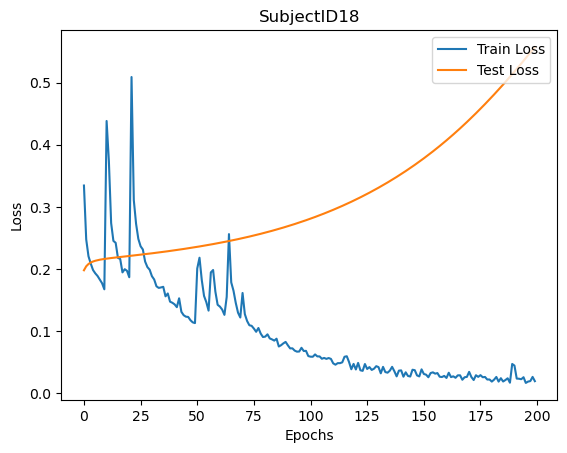

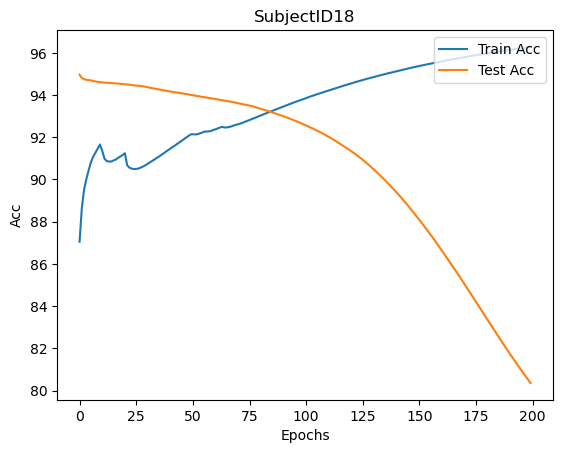

| epoch   0 | 0.0645 s/epoch | train loss 0.3948
| epoch   1 | 0.0652 s/epoch | train loss 0.2914
| epoch   2 | 0.0649 s/epoch | train loss 0.2619
| epoch   3 | 0.0644 s/epoch | train loss 0.2490
| epoch   4 | 0.0637 s/epoch | train loss 0.2359
| epoch   5 | 0.0641 s/epoch | train loss 0.2323
| epoch   6 | 0.0643 s/epoch | train loss 0.2202
| epoch   7 | 0.0647 s/epoch | train loss 0.2087
| epoch   8 | 0.0656 s/epoch | train loss 0.2003
| epoch   9 | 0.0638 s/epoch | train loss 0.1955
| epoch  10 | 0.0645 s/epoch | train loss 0.1978
| epoch  11 | 0.0638 s/epoch | train loss 0.1883
| epoch  12 | 0.0643 s/epoch | train loss 0.1868
| epoch  13 | 0.0657 s/epoch | train loss 0.1802
| epoch  14 | 0.0655 s/epoch | train loss 0.1721
| epoch  15 | 0.0645 s/epoch | train loss 0.1764
| epoch  16 | 0.0639 s/epoch | train loss 0.1681
| epoch  17 | 0.0641 s/epoch | train loss 0.1646
| epoch  18 | 0.0642 s/epoch | train loss 0.1626
| epoch  19 | 0.0655 s/epoch | train loss 0.1582
| epoch  20 | 0.0646

| epoch 168 | 0.0652 s/epoch | train loss 0.0358
| epoch 169 | 0.0648 s/epoch | train loss 0.0415
| epoch 170 | 0.0632 s/epoch | train loss 0.0365
| epoch 171 | 0.0653 s/epoch | train loss 0.0429
| epoch 172 | 0.0651 s/epoch | train loss 0.0387
| epoch 173 | 0.0647 s/epoch | train loss 0.0365
| epoch 174 | 0.0647 s/epoch | train loss 0.0405
| epoch 175 | 0.0661 s/epoch | train loss 0.0387
| epoch 176 | 0.0660 s/epoch | train loss 0.0359
| epoch 177 | 0.0636 s/epoch | train loss 0.0347
| epoch 178 | 0.0648 s/epoch | train loss 0.0390
| epoch 179 | 0.0656 s/epoch | train loss 0.0337
| epoch 180 | 0.0648 s/epoch | train loss 0.0402
| epoch 181 | 0.0645 s/epoch | train loss 0.0420
| epoch 182 | 0.0641 s/epoch | train loss 0.0364
| epoch 183 | 0.0644 s/epoch | train loss 0.0353
| epoch 184 | 0.0652 s/epoch | train loss 0.0393
| epoch 185 | 0.0649 s/epoch | train loss 0.0393
| epoch 186 | 0.0646 s/epoch | train loss 0.0353
| epoch 187 | 0.0664 s/epoch | train loss 0.0382
| epoch 188 | 0.0643

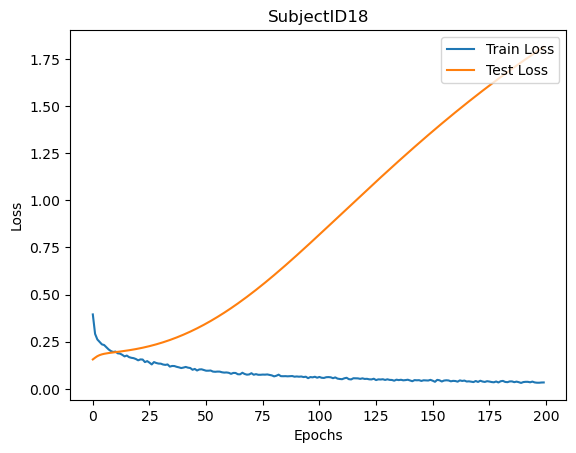

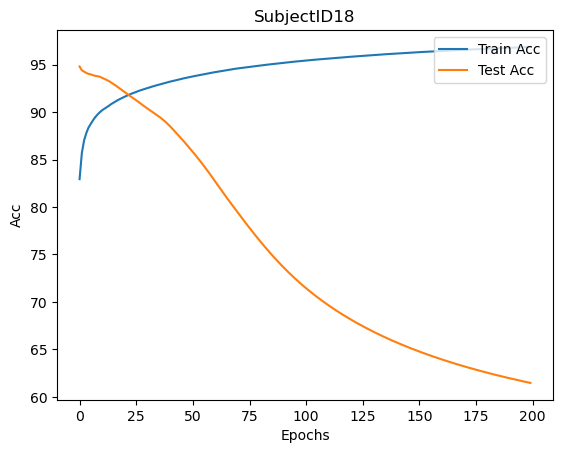


Subject 19
| epoch   0 | 0.0895 s/epoch | train loss 0.3391
| epoch   1 | 0.0897 s/epoch | train loss 0.2531
| epoch   2 | 0.0897 s/epoch | train loss 0.2214
| epoch   3 | 0.0880 s/epoch | train loss 0.2137
| epoch   4 | 0.0895 s/epoch | train loss 0.2012
| epoch   5 | 0.0896 s/epoch | train loss 0.1912
| epoch   6 | 0.0896 s/epoch | train loss 0.1837
| epoch   7 | 0.0901 s/epoch | train loss 0.1794
| epoch   8 | 0.0901 s/epoch | train loss 0.1782
| epoch   9 | 0.0891 s/epoch | train loss 0.1729
| epoch  10 | 0.0901 s/epoch | train loss 0.1629
| epoch  11 | 0.0897 s/epoch | train loss 0.1719
| epoch  12 | 0.0903 s/epoch | train loss 0.1579
| epoch  13 | 0.0894 s/epoch | train loss 0.1524
| epoch  14 | 0.0891 s/epoch | train loss 0.1442
| epoch  15 | 0.0903 s/epoch | train loss 0.1462
| epoch  16 | 0.0902 s/epoch | train loss 0.1447
| epoch  17 | 0.0895 s/epoch | train loss 0.1372
| epoch  18 | 0.0894 s/epoch | train loss 0.1334
| epoch  19 | 0.0893 s/epoch | train loss 0.1241
| epoch 

| epoch 167 | 0.0903 s/epoch | train loss 0.0274
| epoch 168 | 0.0902 s/epoch | train loss 0.0179
| epoch 169 | 0.0901 s/epoch | train loss 0.0192
| epoch 170 | 0.0895 s/epoch | train loss 0.0205
| epoch 171 | 0.0908 s/epoch | train loss 0.0258
| epoch 172 | 0.0912 s/epoch | train loss 0.0239
| epoch 173 | 0.0903 s/epoch | train loss 0.0246
| epoch 174 | 0.0901 s/epoch | train loss 0.0151
| epoch 175 | 0.0911 s/epoch | train loss 0.0219
| epoch 176 | 0.0891 s/epoch | train loss 0.0179
| epoch 177 | 0.0910 s/epoch | train loss 0.0214
| epoch 178 | 0.0913 s/epoch | train loss 0.0296
| epoch 179 | 0.0907 s/epoch | train loss 0.0201
| epoch 180 | 0.0906 s/epoch | train loss 0.0234
| epoch 181 | 0.0896 s/epoch | train loss 0.0178
| epoch 182 | 0.0896 s/epoch | train loss 0.0155
| epoch 183 | 0.0910 s/epoch | train loss 0.0165
| epoch 184 | 0.0899 s/epoch | train loss 0.0200
| epoch 185 | 0.0896 s/epoch | train loss 0.0319
| epoch 186 | 0.0906 s/epoch | train loss 0.0193
| epoch 187 | 0.0904

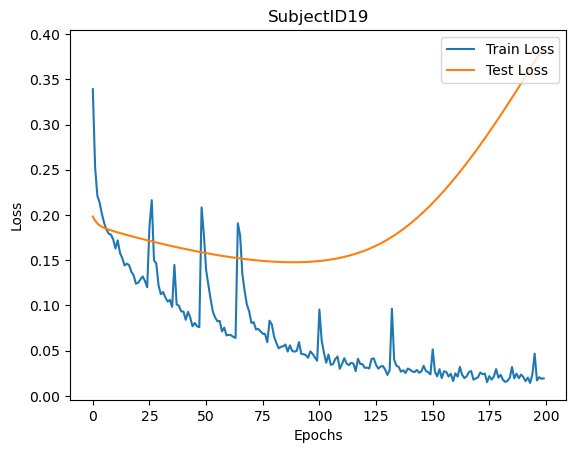

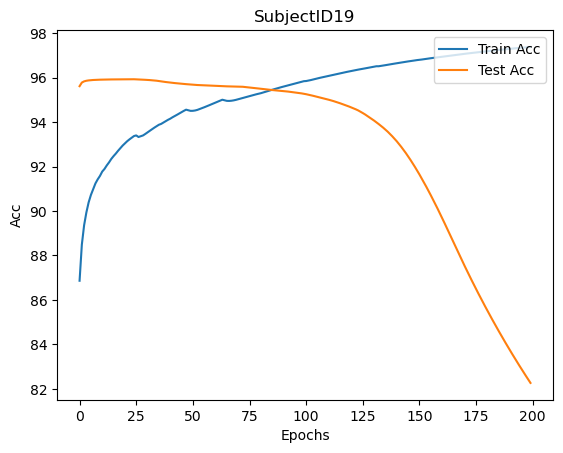

| epoch   0 | 0.0643 s/epoch | train loss 0.4416
| epoch   1 | 0.0638 s/epoch | train loss 0.3015
| epoch   2 | 0.0656 s/epoch | train loss 0.2766
| epoch   3 | 0.0640 s/epoch | train loss 0.2518
| epoch   4 | 0.0651 s/epoch | train loss 0.2469
| epoch   5 | 0.0653 s/epoch | train loss 0.2294
| epoch   6 | 0.0652 s/epoch | train loss 0.2182
| epoch   7 | 0.0645 s/epoch | train loss 0.2113
| epoch   8 | 0.0653 s/epoch | train loss 0.2083
| epoch   9 | 0.0645 s/epoch | train loss 0.2098
| epoch  10 | 0.0656 s/epoch | train loss 0.2098
| epoch  11 | 0.0647 s/epoch | train loss 0.1997
| epoch  12 | 0.0663 s/epoch | train loss 0.1838
| epoch  13 | 0.0644 s/epoch | train loss 0.1921
| epoch  14 | 0.0655 s/epoch | train loss 0.1870
| epoch  15 | 0.0652 s/epoch | train loss 0.1833
| epoch  16 | 0.0640 s/epoch | train loss 0.1775
| epoch  17 | 0.0651 s/epoch | train loss 0.1745
| epoch  18 | 0.0649 s/epoch | train loss 0.1739
| epoch  19 | 0.0648 s/epoch | train loss 0.1690
| epoch  20 | 0.0641

| epoch 168 | 0.0657 s/epoch | train loss 0.0395
| epoch 169 | 0.0658 s/epoch | train loss 0.0385
| epoch 170 | 0.0650 s/epoch | train loss 0.0386
| epoch 171 | 0.0667 s/epoch | train loss 0.0380
| epoch 172 | 0.0637 s/epoch | train loss 0.0378
| epoch 173 | 0.0653 s/epoch | train loss 0.0392
| epoch 174 | 0.0657 s/epoch | train loss 0.0351
| epoch 175 | 0.0642 s/epoch | train loss 0.0374
| epoch 176 | 0.0635 s/epoch | train loss 0.0372
| epoch 177 | 0.0650 s/epoch | train loss 0.0392
| epoch 178 | 0.0648 s/epoch | train loss 0.0385
| epoch 179 | 0.0646 s/epoch | train loss 0.0348
| epoch 180 | 0.0650 s/epoch | train loss 0.0388
| epoch 181 | 0.0653 s/epoch | train loss 0.0359
| epoch 182 | 0.0665 s/epoch | train loss 0.0314
| epoch 183 | 0.0646 s/epoch | train loss 0.0398
| epoch 184 | 0.0644 s/epoch | train loss 0.0387
| epoch 185 | 0.0655 s/epoch | train loss 0.0370
| epoch 186 | 0.0659 s/epoch | train loss 0.0331
| epoch 187 | 0.0668 s/epoch | train loss 0.0340
| epoch 188 | 0.0651

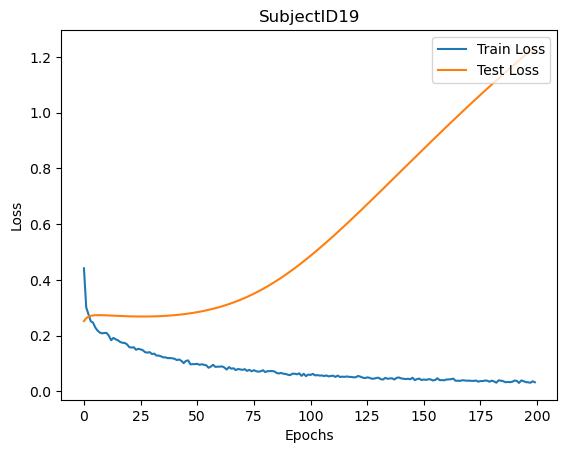

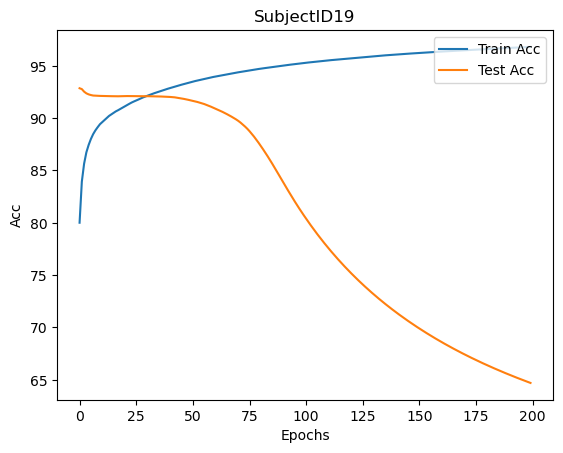


Subject 21
| epoch   0 | 0.0898 s/epoch | train loss 0.4220
| epoch   1 | 0.0904 s/epoch | train loss 0.3339
| epoch   2 | 0.0902 s/epoch | train loss 0.2745
| epoch   3 | 0.0903 s/epoch | train loss 0.2334
| epoch   4 | 0.0905 s/epoch | train loss 0.2110
| epoch   5 | 0.0875 s/epoch | train loss 0.2116
| epoch   6 | 0.0815 s/epoch | train loss 0.1954
| epoch   7 | 0.0811 s/epoch | train loss 0.1845
| epoch   8 | 0.0813 s/epoch | train loss 0.1861
| epoch   9 | 0.0811 s/epoch | train loss 0.1762
| epoch  10 | 0.0847 s/epoch | train loss 0.1671
| epoch  11 | 0.0876 s/epoch | train loss 0.1652
| epoch  12 | 0.0887 s/epoch | train loss 0.1827
| epoch  13 | 0.0892 s/epoch | train loss 0.4812
| epoch  14 | 0.0884 s/epoch | train loss 0.2820
| epoch  15 | 0.0888 s/epoch | train loss 0.2422
| epoch  16 | 0.0881 s/epoch | train loss 0.2575
| epoch  17 | 0.0886 s/epoch | train loss 0.3283
| epoch  18 | 0.0880 s/epoch | train loss 0.3122
| epoch  19 | 0.0872 s/epoch | train loss 0.3093
| epoch 

| epoch 167 | 0.0891 s/epoch | train loss 0.0241
| epoch 168 | 0.0891 s/epoch | train loss 0.0256
| epoch 169 | 0.0880 s/epoch | train loss 0.0237
| epoch 170 | 0.0890 s/epoch | train loss 0.0212
| epoch 171 | 0.0896 s/epoch | train loss 0.0294
| epoch 172 | 0.0899 s/epoch | train loss 0.0400
| epoch 173 | 0.0885 s/epoch | train loss 0.0208
| epoch 174 | 0.0891 s/epoch | train loss 0.0223
| epoch 175 | 0.0898 s/epoch | train loss 0.0673
| epoch 176 | 0.0896 s/epoch | train loss 0.0919
| epoch 177 | 0.0884 s/epoch | train loss 0.0338
| epoch 178 | 0.0878 s/epoch | train loss 0.0268
| epoch 179 | 0.0881 s/epoch | train loss 0.0235
| epoch 180 | 0.0892 s/epoch | train loss 0.0249
| epoch 181 | 0.0886 s/epoch | train loss 0.0213
| epoch 182 | 0.0893 s/epoch | train loss 0.0222
| epoch 183 | 0.0889 s/epoch | train loss 0.0183
| epoch 184 | 0.0893 s/epoch | train loss 0.0173
| epoch 185 | 0.0877 s/epoch | train loss 0.0253
| epoch 186 | 0.0879 s/epoch | train loss 0.0207
| epoch 187 | 0.0892

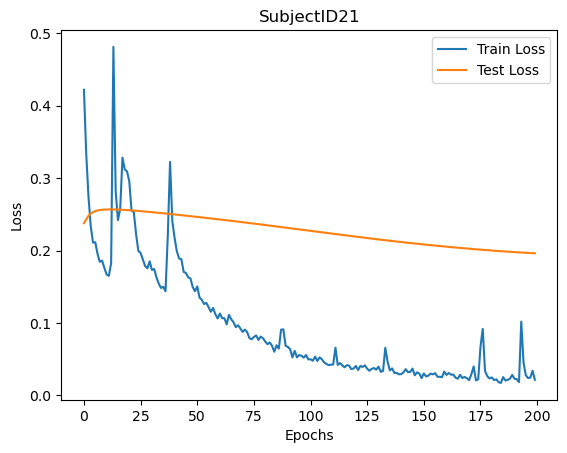

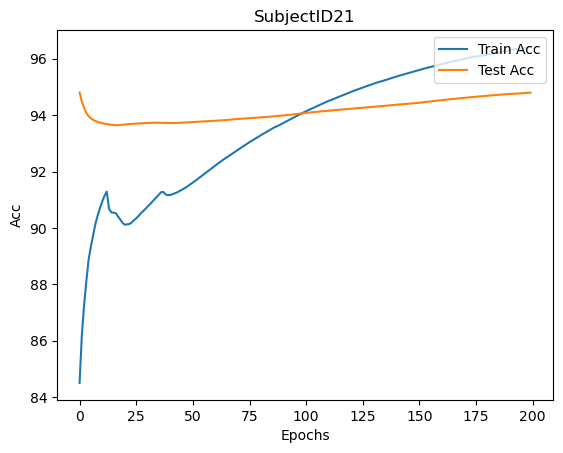

| epoch   0 | 0.0639 s/epoch | train loss 0.3817
| epoch   1 | 0.0629 s/epoch | train loss 0.2813
| epoch   2 | 0.0635 s/epoch | train loss 0.2683
| epoch   3 | 0.0639 s/epoch | train loss 0.2463
| epoch   4 | 0.0635 s/epoch | train loss 0.2357
| epoch   5 | 0.0631 s/epoch | train loss 0.2322
| epoch   6 | 0.0639 s/epoch | train loss 0.2155
| epoch   7 | 0.0638 s/epoch | train loss 0.2054
| epoch   8 | 0.0645 s/epoch | train loss 0.2013
| epoch   9 | 0.0635 s/epoch | train loss 0.1920
| epoch  10 | 0.0650 s/epoch | train loss 0.1894
| epoch  11 | 0.0640 s/epoch | train loss 0.1903
| epoch  12 | 0.0655 s/epoch | train loss 0.1787
| epoch  13 | 0.0656 s/epoch | train loss 0.1761
| epoch  14 | 0.0645 s/epoch | train loss 0.1719
| epoch  15 | 0.0642 s/epoch | train loss 0.1702
| epoch  16 | 0.0654 s/epoch | train loss 0.1694
| epoch  17 | 0.0650 s/epoch | train loss 0.1640
| epoch  18 | 0.0641 s/epoch | train loss 0.1623
| epoch  19 | 0.0647 s/epoch | train loss 0.1617
| epoch  20 | 0.0644

| epoch 168 | 0.0646 s/epoch | train loss 0.0381
| epoch 169 | 0.0654 s/epoch | train loss 0.0405
| epoch 170 | 0.0657 s/epoch | train loss 0.0408
| epoch 171 | 0.0639 s/epoch | train loss 0.0423
| epoch 172 | 0.0642 s/epoch | train loss 0.0387
| epoch 173 | 0.0637 s/epoch | train loss 0.0428
| epoch 174 | 0.0646 s/epoch | train loss 0.0396
| epoch 175 | 0.0638 s/epoch | train loss 0.0366
| epoch 176 | 0.0629 s/epoch | train loss 0.0400
| epoch 177 | 0.0648 s/epoch | train loss 0.0404
| epoch 178 | 0.0647 s/epoch | train loss 0.0409
| epoch 179 | 0.0645 s/epoch | train loss 0.0448
| epoch 180 | 0.0656 s/epoch | train loss 0.0369
| epoch 181 | 0.0639 s/epoch | train loss 0.0349
| epoch 182 | 0.0638 s/epoch | train loss 0.0379
| epoch 183 | 0.0641 s/epoch | train loss 0.0384
| epoch 184 | 0.0639 s/epoch | train loss 0.0401
| epoch 185 | 0.0641 s/epoch | train loss 0.0372
| epoch 186 | 0.0649 s/epoch | train loss 0.0390
| epoch 187 | 0.0656 s/epoch | train loss 0.0347
| epoch 188 | 0.0638

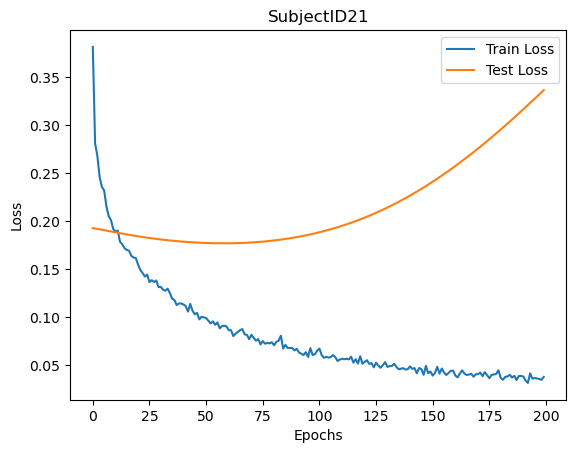

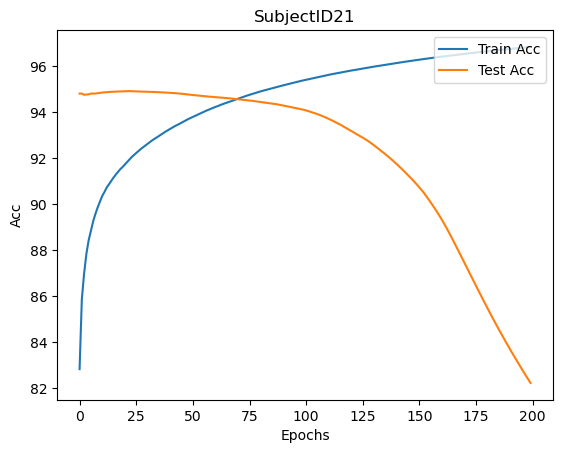


Subject 22
| epoch   0 | 0.0884 s/epoch | train loss 0.3654
| epoch   1 | 0.0889 s/epoch | train loss 0.3321
| epoch   2 | 0.0882 s/epoch | train loss 0.2890
| epoch   3 | 0.0876 s/epoch | train loss 0.2780
| epoch   4 | 0.0884 s/epoch | train loss 0.2721
| epoch   5 | 0.0889 s/epoch | train loss 0.2486
| epoch   6 | 0.0890 s/epoch | train loss 0.2437
| epoch   7 | 0.0886 s/epoch | train loss 0.2704
| epoch   8 | 0.0877 s/epoch | train loss 0.2055
| epoch   9 | 0.0880 s/epoch | train loss 0.1993
| epoch  10 | 0.0879 s/epoch | train loss 0.2363
| epoch  11 | 0.0884 s/epoch | train loss 0.2015
| epoch  12 | 0.0885 s/epoch | train loss 0.1752
| epoch  13 | 0.0883 s/epoch | train loss 0.1690
| epoch  14 | 0.0880 s/epoch | train loss 0.2171
| epoch  15 | 0.0882 s/epoch | train loss 0.1856
| epoch  16 | 0.0886 s/epoch | train loss 0.2049
| epoch  17 | 0.0883 s/epoch | train loss 0.2991
| epoch  18 | 0.0895 s/epoch | train loss 0.2134
| epoch  19 | 0.0883 s/epoch | train loss 0.2052
| epoch 

| epoch 167 | 0.0888 s/epoch | train loss 0.0223
| epoch 168 | 0.0882 s/epoch | train loss 0.0216
| epoch 169 | 0.0906 s/epoch | train loss 0.0267
| epoch 170 | 0.0889 s/epoch | train loss 0.0194
| epoch 171 | 0.0885 s/epoch | train loss 0.0253
| epoch 172 | 0.0898 s/epoch | train loss 0.0224
| epoch 173 | 0.0887 s/epoch | train loss 0.0178
| epoch 174 | 0.0891 s/epoch | train loss 0.0180
| epoch 175 | 0.0895 s/epoch | train loss 0.0198
| epoch 176 | 0.0892 s/epoch | train loss 0.0277
| epoch 177 | 0.0887 s/epoch | train loss 0.0174
| epoch 178 | 0.0894 s/epoch | train loss 0.0250
| epoch 179 | 0.0873 s/epoch | train loss 0.0221
| epoch 180 | 0.0888 s/epoch | train loss 0.0228
| epoch 181 | 0.0896 s/epoch | train loss 0.0184
| epoch 182 | 0.0887 s/epoch | train loss 0.0147
| epoch 183 | 0.0886 s/epoch | train loss 0.0286
| epoch 184 | 0.0880 s/epoch | train loss 0.0207
| epoch 185 | 0.0884 s/epoch | train loss 0.0194
| epoch 186 | 0.0890 s/epoch | train loss 0.0199
| epoch 187 | 0.0888

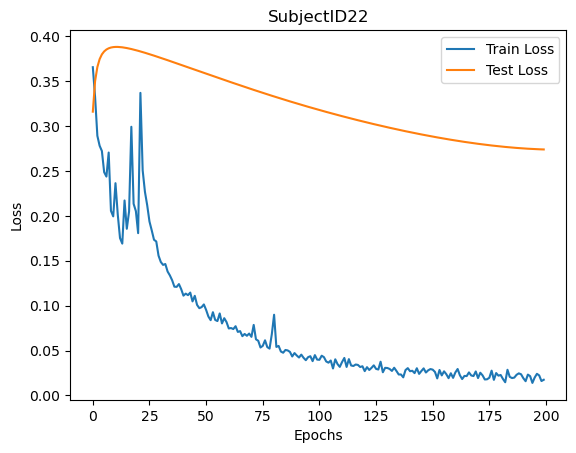

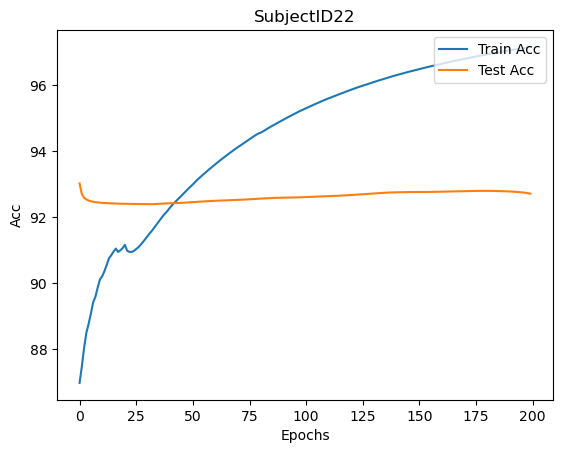

| epoch   0 | 0.0644 s/epoch | train loss 0.3994
| epoch   1 | 0.0635 s/epoch | train loss 0.2900
| epoch   2 | 0.0645 s/epoch | train loss 0.2668
| epoch   3 | 0.0630 s/epoch | train loss 0.2463
| epoch   4 | 0.0637 s/epoch | train loss 0.2266
| epoch   5 | 0.0627 s/epoch | train loss 0.2216
| epoch   6 | 0.0639 s/epoch | train loss 0.2133
| epoch   7 | 0.0644 s/epoch | train loss 0.2048
| epoch   8 | 0.0641 s/epoch | train loss 0.1988
| epoch   9 | 0.0634 s/epoch | train loss 0.1962
| epoch  10 | 0.0634 s/epoch | train loss 0.1888
| epoch  11 | 0.0627 s/epoch | train loss 0.1869
| epoch  12 | 0.0626 s/epoch | train loss 0.1843
| epoch  13 | 0.0641 s/epoch | train loss 0.1763
| epoch  14 | 0.0638 s/epoch | train loss 0.1735
| epoch  15 | 0.0634 s/epoch | train loss 0.1686
| epoch  16 | 0.0628 s/epoch | train loss 0.1630
| epoch  17 | 0.0637 s/epoch | train loss 0.1589
| epoch  18 | 0.0647 s/epoch | train loss 0.1630
| epoch  19 | 0.0627 s/epoch | train loss 0.1572
| epoch  20 | 0.0628

| epoch 168 | 0.0622 s/epoch | train loss 0.0365
| epoch 169 | 0.0647 s/epoch | train loss 0.0378
| epoch 170 | 0.0644 s/epoch | train loss 0.0393
| epoch 171 | 0.0635 s/epoch | train loss 0.0371
| epoch 172 | 0.0641 s/epoch | train loss 0.0342
| epoch 173 | 0.0650 s/epoch | train loss 0.0351
| epoch 174 | 0.0640 s/epoch | train loss 0.0353
| epoch 175 | 0.0641 s/epoch | train loss 0.0381
| epoch 176 | 0.0632 s/epoch | train loss 0.0334
| epoch 177 | 0.0623 s/epoch | train loss 0.0318
| epoch 178 | 0.0640 s/epoch | train loss 0.0337
| epoch 179 | 0.0636 s/epoch | train loss 0.0381
| epoch 180 | 0.0635 s/epoch | train loss 0.0362
| epoch 181 | 0.0647 s/epoch | train loss 0.0351
| epoch 182 | 0.0636 s/epoch | train loss 0.0359
| epoch 183 | 0.0634 s/epoch | train loss 0.0291
| epoch 184 | 0.0646 s/epoch | train loss 0.0320
| epoch 185 | 0.0642 s/epoch | train loss 0.0322
| epoch 186 | 0.0658 s/epoch | train loss 0.0341
| epoch 187 | 0.0628 s/epoch | train loss 0.0349
| epoch 188 | 0.0639

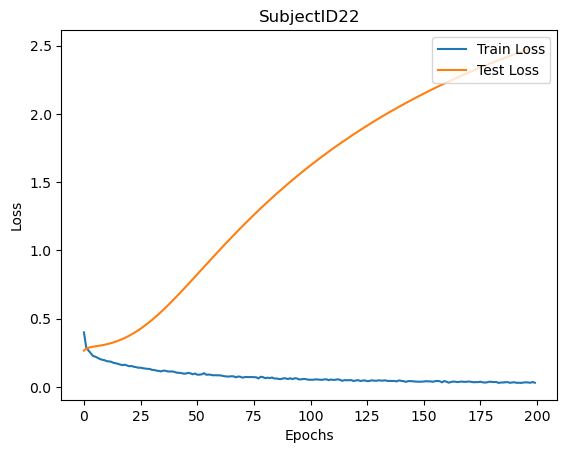

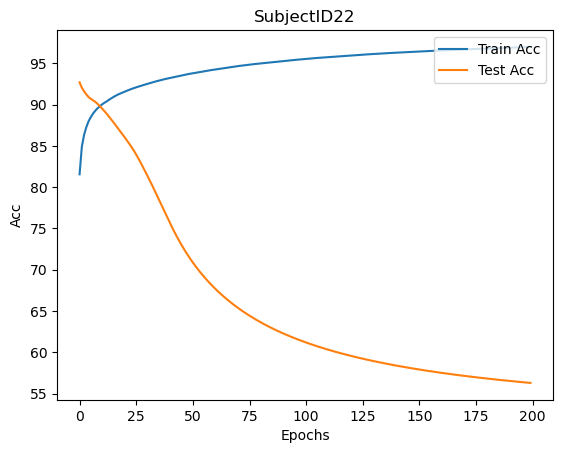


Subject 23
| epoch   0 | 0.0885 s/epoch | train loss 0.3366
| epoch   1 | 0.0889 s/epoch | train loss 0.2337
| epoch   2 | 0.0885 s/epoch | train loss 0.2172
| epoch   3 | 0.0886 s/epoch | train loss 0.2024
| epoch   4 | 0.0884 s/epoch | train loss 0.1953
| epoch   5 | 0.0884 s/epoch | train loss 0.1867
| epoch   6 | 0.0887 s/epoch | train loss 0.2296
| epoch   7 | 0.0887 s/epoch | train loss 0.2013
| epoch   8 | 0.0883 s/epoch | train loss 0.1843
| epoch   9 | 0.0883 s/epoch | train loss 0.1646
| epoch  10 | 0.0884 s/epoch | train loss 0.1655
| epoch  11 | 0.0895 s/epoch | train loss 0.1552
| epoch  12 | 0.0883 s/epoch | train loss 0.2143
| epoch  13 | 0.0887 s/epoch | train loss 0.4258
| epoch  14 | 0.0883 s/epoch | train loss 0.2421
| epoch  15 | 0.0889 s/epoch | train loss 0.2130
| epoch  16 | 0.0885 s/epoch | train loss 0.1995
| epoch  17 | 0.0896 s/epoch | train loss 0.1920
| epoch  18 | 0.0891 s/epoch | train loss 0.1820
| epoch  19 | 0.0883 s/epoch | train loss 0.1689
| epoch 

| epoch 167 | 0.0885 s/epoch | train loss 0.0227
| epoch 168 | 0.0876 s/epoch | train loss 0.0216
| epoch 169 | 0.0884 s/epoch | train loss 0.0180
| epoch 170 | 0.0881 s/epoch | train loss 0.0201
| epoch 171 | 0.0886 s/epoch | train loss 0.0215
| epoch 172 | 0.0890 s/epoch | train loss 0.0176
| epoch 173 | 0.0900 s/epoch | train loss 0.0135
| epoch 174 | 0.0890 s/epoch | train loss 0.0239
| epoch 175 | 0.0892 s/epoch | train loss 0.0168
| epoch 176 | 0.0888 s/epoch | train loss 0.0195
| epoch 177 | 0.0892 s/epoch | train loss 0.0197
| epoch 178 | 0.0901 s/epoch | train loss 0.0184
| epoch 179 | 0.0883 s/epoch | train loss 0.0154
| epoch 180 | 0.0888 s/epoch | train loss 0.0176
| epoch 181 | 0.0894 s/epoch | train loss 0.0187
| epoch 182 | 0.0892 s/epoch | train loss 0.0164
| epoch 183 | 0.0894 s/epoch | train loss 0.0199
| epoch 184 | 0.0885 s/epoch | train loss 0.0178
| epoch 185 | 0.0888 s/epoch | train loss 0.0113
| epoch 186 | 0.0894 s/epoch | train loss 0.0203
| epoch 187 | 0.0892

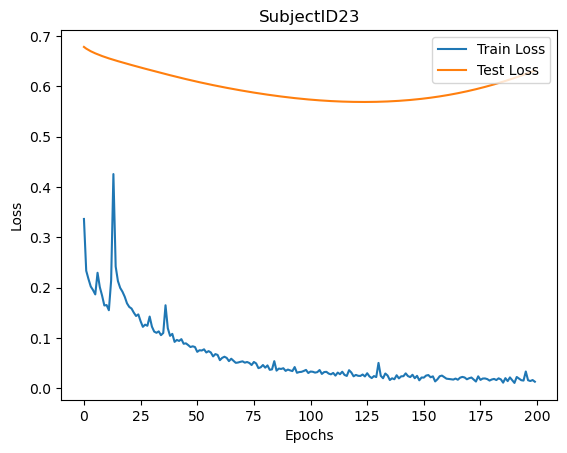

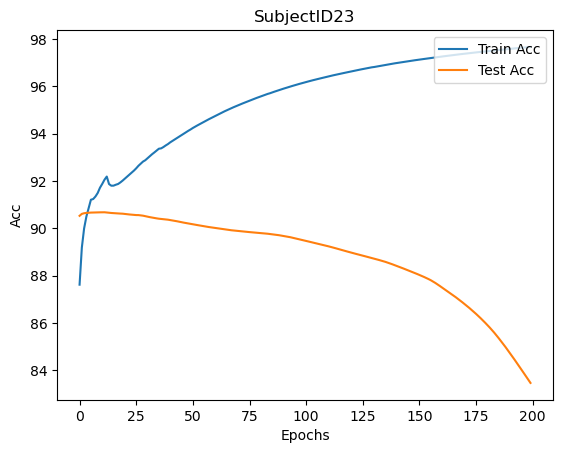

| epoch   0 | 0.0631 s/epoch | train loss 0.3816
| epoch   1 | 0.0615 s/epoch | train loss 0.2886
| epoch   2 | 0.0630 s/epoch | train loss 0.2574
| epoch   3 | 0.0640 s/epoch | train loss 0.2425
| epoch   4 | 0.0633 s/epoch | train loss 0.2353
| epoch   5 | 0.0630 s/epoch | train loss 0.2259
| epoch   6 | 0.0636 s/epoch | train loss 0.2191
| epoch   7 | 0.0642 s/epoch | train loss 0.1979
| epoch   8 | 0.0622 s/epoch | train loss 0.1981
| epoch   9 | 0.0631 s/epoch | train loss 0.1947
| epoch  10 | 0.0623 s/epoch | train loss 0.1833
| epoch  11 | 0.0624 s/epoch | train loss 0.1810
| epoch  12 | 0.0622 s/epoch | train loss 0.1707
| epoch  13 | 0.0633 s/epoch | train loss 0.1652
| epoch  14 | 0.0641 s/epoch | train loss 0.1699
| epoch  15 | 0.0644 s/epoch | train loss 0.1576
| epoch  16 | 0.0631 s/epoch | train loss 0.1562
| epoch  17 | 0.0630 s/epoch | train loss 0.1575
| epoch  18 | 0.0638 s/epoch | train loss 0.1521
| epoch  19 | 0.0632 s/epoch | train loss 0.1534
| epoch  20 | 0.0631

| epoch 168 | 0.0636 s/epoch | train loss 0.0350
| epoch 169 | 0.0640 s/epoch | train loss 0.0338
| epoch 170 | 0.0634 s/epoch | train loss 0.0377
| epoch 171 | 0.0636 s/epoch | train loss 0.0368
| epoch 172 | 0.0631 s/epoch | train loss 0.0349
| epoch 173 | 0.0638 s/epoch | train loss 0.0366
| epoch 174 | 0.0636 s/epoch | train loss 0.0363
| epoch 175 | 0.0629 s/epoch | train loss 0.0347
| epoch 176 | 0.0626 s/epoch | train loss 0.0342
| epoch 177 | 0.0641 s/epoch | train loss 0.0350
| epoch 178 | 0.0632 s/epoch | train loss 0.0322
| epoch 179 | 0.0624 s/epoch | train loss 0.0357
| epoch 180 | 0.0640 s/epoch | train loss 0.0352
| epoch 181 | 0.0630 s/epoch | train loss 0.0335
| epoch 182 | 0.0644 s/epoch | train loss 0.0314
| epoch 183 | 0.0634 s/epoch | train loss 0.0339
| epoch 184 | 0.0645 s/epoch | train loss 0.0323
| epoch 185 | 0.0647 s/epoch | train loss 0.0307
| epoch 186 | 0.0640 s/epoch | train loss 0.0337
| epoch 187 | 0.0632 s/epoch | train loss 0.0359
| epoch 188 | 0.0634

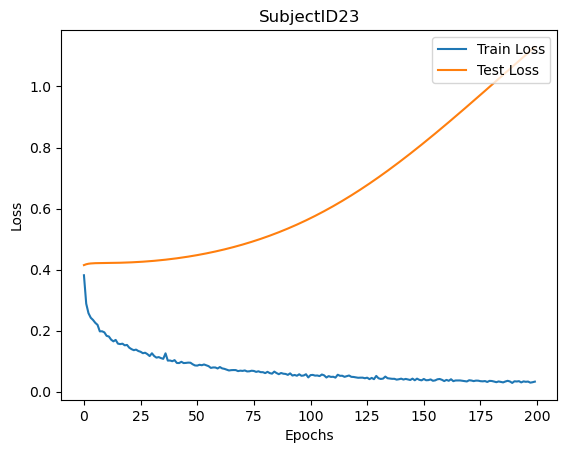

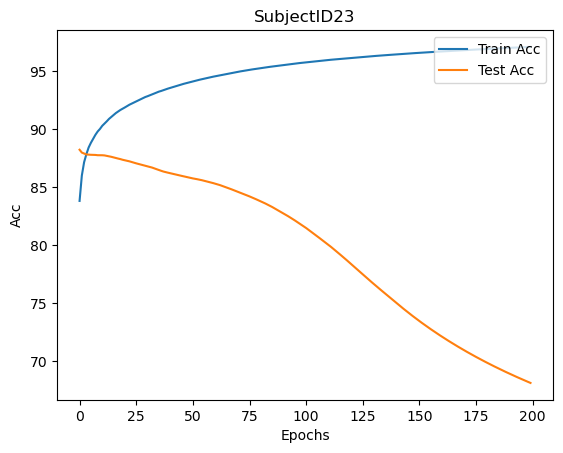

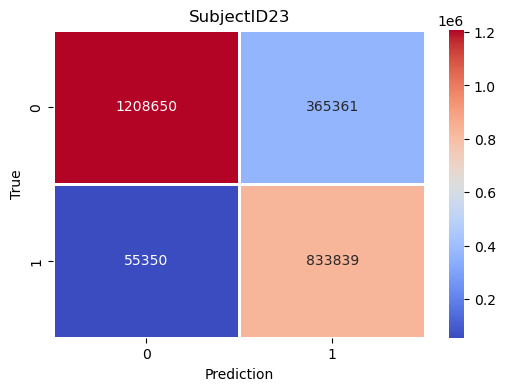

<Figure size 640x480 with 0 Axes>

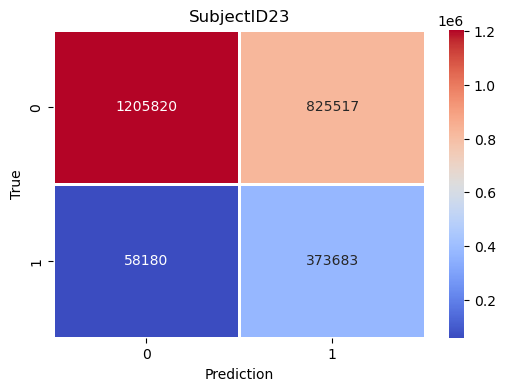

Teacher(RestNet18)_Acc: 0.8292014452744397
Teacher(RestNet18)_Rec: 0.9377522663910597
Teacher(RestNet18)_Pre: 0.695329386257505
Teacher(RestNet18)_F1: 0.7985475885958027
Original_Student(Mobilnet)_Acc: 0.6412402565768106
Original_Student(Mobilnet)_Rec: 0.8652813507987487
Original_Student(Mobilnet)_Pre: 0.31161024016010674
Original_Student(Mobilnet)_F1: 0.45820792943007105


<Figure size 640x480 with 0 Axes>

In [15]:
#%% Evaluation
def evaluation(pred,target):
    acu = accuracy_score(pred, target)
    rec = recall_score(pred, target)
    pre = precision_score(pred, target)
    f1 = f1_score(pred, target)  
    return np.array([acu, rec, pre, f1])

#%% Train
Accuracy_teacher = []
Recall_teacher = []
Precision_teacher = []
F1score_teacher = []

Accuracy_student = []
Recall_student = []
Precision_student = []
F1score_student = []


Accuracy_teacher_student = []
Recall_teacher_student = []
Precision_teacher_student = []
F1score_teacher_student = []


teacher_train_preds = []
teacher_train_gt = []


student_train_preds = []
student_train_gt = []



#for i in range(Average_times):
lis = [1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,18,19,21,22,23]
for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float64'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float64'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float64'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float64'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            if len(norm_sliding_waist_data[i]) > 0:
                e1 = np.max(norm_sliding_waist_data[i])
                max_norm_value.append(e1)
                e2 = np.argmax(norm_sliding_waist_data[i])
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
            else:
                e1 = 0
                max_norm_value.append(e1)
                e2 = 0
                max_norm_index.append(e2)

                e3 = np.max(hori_sliding_waist_data[i])
                max_hori_value.append(e3)
                e4 = np.argmax(hori_sliding_waist_data[i])
                max_hori_index.append(e4)
                

            

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float64')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float64')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
        
    # Sends network to the GPU and sets it to training mode
    ResNet = Net_Teacher(block, [3, 4, 6, 3], 1, 2)
    model_teacher = ResNet.to(device)
    #model_teacher = ResNet.cuda()
    #model_teacher = MobileNetV3_Large().to(device)
    model_teacher.train()
    
    #model_student = Net_Student(config).to(device) 
    model_student = MobileNetV3_Small().to(device)
    #model_student = MobileNetV3_Small().cuda()
    #ResNet_S = Net_Student(block, [3, 4, 6, 3], 1, 2)
    #model_student = ResNet_S.to(device)
    model_student.train()
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher = torch.optim.Adam(model_teacher.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    optimizer_student = torch.optim.Adam(model_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Start training and testing Teacher and Student Model
    training_teacher(trainloader,optimizer_teacher,criterion,model_teacher,testloader)
    #testing_teacher(testloader,optimizer_teacher,criterion,model_teacher)
  
    training_student(trainloader,optimizer_student,criterion,model_student,testloader)    
    #testing_student(testloader,optimizer_student,criterion,model_student)

Teacher_eval_table = evaluation(teacher_train_preds, teacher_train_gt)

Student_eval_table = evaluation(student_train_preds, student_train_gt)

show_CM_teacher(teacher_train_preds, teacher_train_gt)
show_CM_student(student_train_preds, student_train_gt)

print("Teacher(RestNet18)_Acc:",Teacher_eval_table[0])
print("Teacher(RestNet18)_Rec:",Teacher_eval_table[1])
print("Teacher(RestNet18)_Pre:",Teacher_eval_table[2])
print("Teacher(RestNet18)_F1:",Teacher_eval_table[3])

print("Original_Student(Mobilnet)_Acc:",Student_eval_table[0])
print("Original_Student(Mobilnet)_Rec:",Student_eval_table[1])
print("Original_Student(Mobilnet)_Pre:",Student_eval_table[2])
print("Original_Student(Mobilnet)_F1:",Student_eval_table[3]) 



Subject 1
| epoch   0 | 0.1185 s/epoch | train loss 0.9103
| epoch   1 | 0.1173 s/epoch | train loss 0.6068
| epoch   2 | 0.1164 s/epoch | train loss 0.5636
| epoch   3 | 0.1176 s/epoch | train loss 0.5271
| epoch   4 | 0.1178 s/epoch | train loss 0.5163
| epoch   5 | 0.1146 s/epoch | train loss 0.4934
| epoch   6 | 0.1083 s/epoch | train loss 0.4764
| epoch   7 | 0.1073 s/epoch | train loss 0.4573
| epoch   8 | 0.1083 s/epoch | train loss 0.4574
| epoch   9 | 0.1155 s/epoch | train loss 0.4561
| epoch  10 | 0.1169 s/epoch | train loss 0.4381
| epoch  11 | 0.1167 s/epoch | train loss 0.4419
| epoch  12 | 0.1168 s/epoch | train loss 0.4406
| epoch  13 | 0.1164 s/epoch | train loss 0.4160
| epoch  14 | 0.1166 s/epoch | train loss 0.4195
| epoch  15 | 0.1167 s/epoch | train loss 0.4030
| epoch  16 | 0.1166 s/epoch | train loss 0.4023
| epoch  17 | 0.1177 s/epoch | train loss 0.3993
| epoch  18 | 0.1166 s/epoch | train loss 0.3747
| epoch  19 | 0.1188 s/epoch | train loss 0.3759
| epoch  

| epoch 167 | 0.1186 s/epoch | train loss 0.2459
| epoch 168 | 0.1169 s/epoch | train loss 0.2471
| epoch 169 | 0.1184 s/epoch | train loss 0.2440
| epoch 170 | 0.1165 s/epoch | train loss 0.2396
| epoch 171 | 0.1147 s/epoch | train loss 0.2481
| epoch 172 | 0.1077 s/epoch | train loss 0.2549
| epoch 173 | 0.1103 s/epoch | train loss 0.2427
| epoch 174 | 0.1093 s/epoch | train loss 0.2674
| epoch 175 | 0.1147 s/epoch | train loss 0.2432
| epoch 176 | 0.1173 s/epoch | train loss 0.2410
| epoch 177 | 0.1169 s/epoch | train loss 0.2454
| epoch 178 | 0.1164 s/epoch | train loss 0.2381
| epoch 179 | 0.1178 s/epoch | train loss 0.2403
| epoch 180 | 0.1154 s/epoch | train loss 0.2547
| epoch 181 | 0.1177 s/epoch | train loss 0.2502
| epoch 182 | 0.1170 s/epoch | train loss 0.2384
| epoch 183 | 0.1178 s/epoch | train loss 0.2511
| epoch 184 | 0.1173 s/epoch | train loss 0.2425
| epoch 185 | 0.1176 s/epoch | train loss 0.2517
| epoch 186 | 0.1173 s/epoch | train loss 0.2410
| epoch 187 | 0.1164

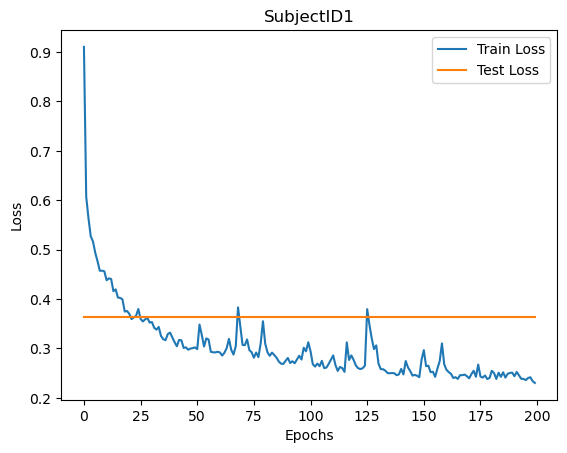

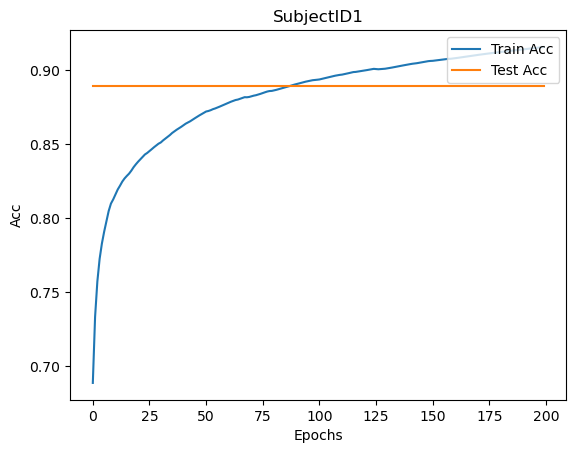


Subject 2
| epoch   0 | 0.1157 s/epoch | train loss 0.8330
| epoch   1 | 0.1166 s/epoch | train loss 0.5769
| epoch   2 | 0.1170 s/epoch | train loss 0.5305
| epoch   3 | 0.1164 s/epoch | train loss 0.5041
| epoch   4 | 0.1167 s/epoch | train loss 0.4768
| epoch   5 | 0.1167 s/epoch | train loss 0.4721
| epoch   6 | 0.1180 s/epoch | train loss 0.4596
| epoch   7 | 0.1179 s/epoch | train loss 0.4518
| epoch   8 | 0.1154 s/epoch | train loss 0.4520
| epoch   9 | 0.1168 s/epoch | train loss 0.4404
| epoch  10 | 0.1171 s/epoch | train loss 0.4191
| epoch  11 | 0.1163 s/epoch | train loss 0.4204
| epoch  12 | 0.1168 s/epoch | train loss 0.3978
| epoch  13 | 0.1164 s/epoch | train loss 0.4042
| epoch  14 | 0.1181 s/epoch | train loss 0.3924
| epoch  15 | 0.1151 s/epoch | train loss 0.3979
| epoch  16 | 0.1170 s/epoch | train loss 0.3974
| epoch  17 | 0.1152 s/epoch | train loss 0.3810
| epoch  18 | 0.1155 s/epoch | train loss 0.3751
| epoch  19 | 0.1175 s/epoch | train loss 0.3703
| epoch  

| epoch 167 | 0.1139 s/epoch | train loss 0.2421
| epoch 168 | 0.1148 s/epoch | train loss 0.3749
| epoch 169 | 0.1154 s/epoch | train loss 0.3087
| epoch 170 | 0.1138 s/epoch | train loss 0.2842
| epoch 171 | 0.1152 s/epoch | train loss 0.2786
| epoch 172 | 0.1141 s/epoch | train loss 0.2658
| epoch 173 | 0.1137 s/epoch | train loss 0.2566
| epoch 174 | 0.1139 s/epoch | train loss 0.2542
| epoch 175 | 0.1145 s/epoch | train loss 0.2425
| epoch 176 | 0.1146 s/epoch | train loss 0.2470
| epoch 177 | 0.1145 s/epoch | train loss 0.2487
| epoch 178 | 0.1152 s/epoch | train loss 0.2468
| epoch 179 | 0.1141 s/epoch | train loss 0.2391
| epoch 180 | 0.1144 s/epoch | train loss 0.2524
| epoch 181 | 0.1155 s/epoch | train loss 0.2417
| epoch 182 | 0.1146 s/epoch | train loss 0.2403
| epoch 183 | 0.1146 s/epoch | train loss 0.2370
| epoch 184 | 0.1148 s/epoch | train loss 0.2375
| epoch 185 | 0.1143 s/epoch | train loss 0.2324
| epoch 186 | 0.1152 s/epoch | train loss 0.2342
| epoch 187 | 0.1149

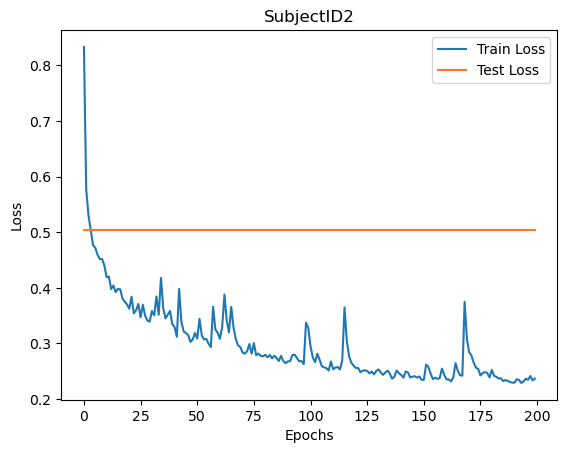

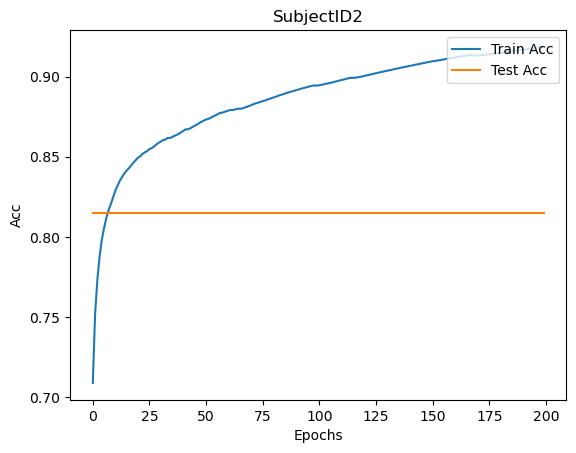


Subject 3
| epoch   0 | 0.1131 s/epoch | train loss 0.8227
| epoch   1 | 0.1148 s/epoch | train loss 0.5872
| epoch   2 | 0.1130 s/epoch | train loss 0.5375
| epoch   3 | 0.1147 s/epoch | train loss 0.5263
| epoch   4 | 0.1151 s/epoch | train loss 0.5020
| epoch   5 | 0.1150 s/epoch | train loss 0.5047
| epoch   6 | 0.1154 s/epoch | train loss 0.4764
| epoch   7 | 0.1140 s/epoch | train loss 0.4669
| epoch   8 | 0.1143 s/epoch | train loss 0.4513
| epoch   9 | 0.1147 s/epoch | train loss 0.4421
| epoch  10 | 0.1145 s/epoch | train loss 0.4514
| epoch  11 | 0.1152 s/epoch | train loss 0.4470
| epoch  12 | 0.1152 s/epoch | train loss 0.4372
| epoch  13 | 0.1151 s/epoch | train loss 0.4226
| epoch  14 | 0.1137 s/epoch | train loss 0.4050
| epoch  15 | 0.1144 s/epoch | train loss 0.4211
| epoch  16 | 0.1140 s/epoch | train loss 0.4025
| epoch  17 | 0.1148 s/epoch | train loss 0.3875
| epoch  18 | 0.1152 s/epoch | train loss 0.3903
| epoch  19 | 0.1144 s/epoch | train loss 0.4026
| epoch  

| epoch 167 | 0.1418 s/epoch | train loss 0.2429
| epoch 168 | 0.1414 s/epoch | train loss 0.2399
| epoch 169 | 0.1334 s/epoch | train loss 0.2505
| epoch 170 | 0.1335 s/epoch | train loss 0.2581
| epoch 171 | 0.1346 s/epoch | train loss 0.2420
| epoch 172 | 0.1392 s/epoch | train loss 0.2449
| epoch 173 | 0.1440 s/epoch | train loss 0.2403
| epoch 174 | 0.1324 s/epoch | train loss 0.2435
| epoch 175 | 0.1364 s/epoch | train loss 0.2453
| epoch 176 | 0.1360 s/epoch | train loss 0.2380
| epoch 177 | 0.1363 s/epoch | train loss 0.2384
| epoch 178 | 0.1370 s/epoch | train loss 0.2368
| epoch 179 | 0.1304 s/epoch | train loss 0.2491
| epoch 180 | 0.1357 s/epoch | train loss 0.2415
| epoch 181 | 0.1377 s/epoch | train loss 0.2551
| epoch 182 | 0.1416 s/epoch | train loss 0.2538
| epoch 183 | 0.1424 s/epoch | train loss 0.2419
| epoch 184 | 0.1376 s/epoch | train loss 0.2401
| epoch 185 | 0.1380 s/epoch | train loss 0.2362
| epoch 186 | 0.1417 s/epoch | train loss 0.2314
| epoch 187 | 0.1403

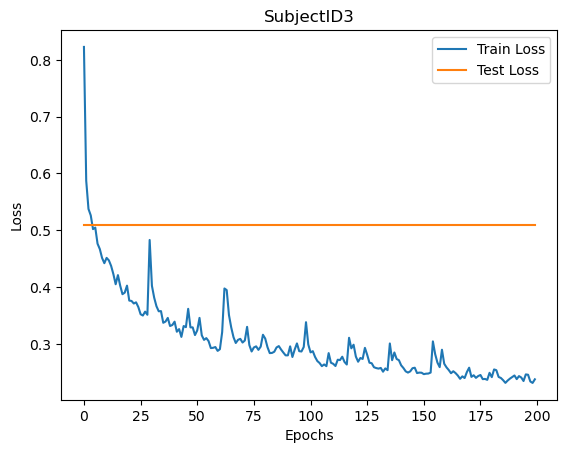

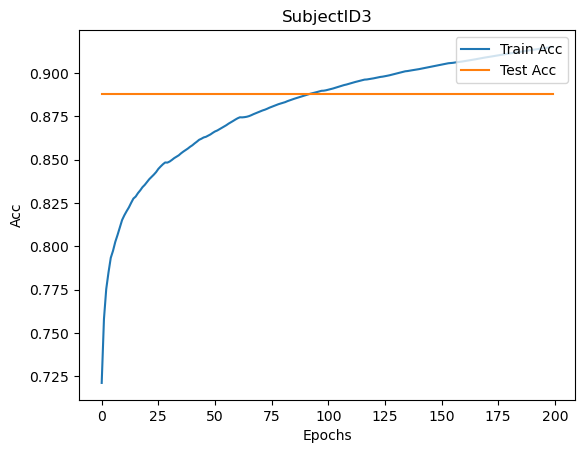


Subject 4
| epoch   0 | 0.1363 s/epoch | train loss 0.8605
| epoch   1 | 0.1358 s/epoch | train loss 0.6063
| epoch   2 | 0.1363 s/epoch | train loss 0.5635
| epoch   3 | 0.1349 s/epoch | train loss 0.5361
| epoch   4 | 0.1376 s/epoch | train loss 0.5007
| epoch   5 | 0.1397 s/epoch | train loss 0.4886
| epoch   6 | 0.1344 s/epoch | train loss 0.5024
| epoch   7 | 0.1381 s/epoch | train loss 0.4919
| epoch   8 | 0.1314 s/epoch | train loss 0.4652
| epoch   9 | 0.1408 s/epoch | train loss 0.4642
| epoch  10 | 0.1454 s/epoch | train loss 0.4557
| epoch  11 | 0.1431 s/epoch | train loss 0.4432
| epoch  12 | 0.1443 s/epoch | train loss 0.4353
| epoch  13 | 0.1414 s/epoch | train loss 0.4419
| epoch  14 | 0.1462 s/epoch | train loss 0.4201
| epoch  15 | 0.1466 s/epoch | train loss 0.4206
| epoch  16 | 0.1398 s/epoch | train loss 0.4294
| epoch  17 | 0.1368 s/epoch | train loss 0.4112
| epoch  18 | 0.1409 s/epoch | train loss 0.4036
| epoch  19 | 0.1410 s/epoch | train loss 0.3914
| epoch  

In [ ]:
teacher_student_train_preds = []
teacher_student_train_gt = []

for sub in lis:
    print("\nSubject",sub)
    test = (sliding_waist_subject == sub)
    train = ~test

    norm_sliding_waist_data = []
    norm_sliding_waist_test = []
    min_norm_value = []
    min_norm_index = []
    max_norm_value = []
    max_norm_index = []
    hori_sliding_waist_data = []
    hori_sliding_waist_test = []
    sliding_waist_data_hori = sliding_waist_data
    sliding_waist_data_hori[:,:,0] = sliding_waist_data_hori[:,:,0]*0
    min_hori_value = []
    min_hori_index = []
    max_hori_value = []
    max_hori_index = []
    
    X_train = sliding_waist_data[train]
    Y_train_gd = sliding_waist_label[train]
    X_test = sliding_waist_data[test]
    Y_test_gd = sliding_waist_label[test]

    X_train_hori = sliding_waist_data_hori[train]
    X_test_hori = sliding_waist_data_hori[test]


    for i in range(len(X_train)):
        c1 = np.linalg.norm(X_train[i].astype('float64'), axis=1)
        norm_sliding_waist_data.append(c1)

    for i in range(len(X_test)):
        c2 = np.linalg.norm(X_test[i].astype('float64'), axis=1)
        norm_sliding_waist_test.append(c2)

    for i in range(len(X_train_hori)):
        c1 = np.linalg.norm(X_train_hori[i].astype('float64'), axis=1)
        hori_sliding_waist_data.append(c1)

    for i in range(len(X_test_hori)):
        c2 = np.linalg.norm(X_test_hori[i].astype('float64'), axis=1)
        hori_sliding_waist_test.append(c2)

    
    for i in range(len(Y_train_gd)):
        if Y_train_gd[i] ==1:
            d1 = np.min(norm_sliding_waist_data[i])
            min_norm_value.append(d1)
            d2 = np.argmin(norm_sliding_waist_data[i])
            min_norm_index.append(d2)

            d3 = np.min(hori_sliding_waist_data[i])
            min_hori_value.append(d3)
            d4 = np.argmin(hori_sliding_waist_data[i])
            min_hori_index.append(d4)
            
        else:
            e1 = np.max(norm_sliding_waist_data[i])
            max_norm_value.append(e1)
            e2 = np.argmax(norm_sliding_waist_data[i])
            max_norm_index.append(e2)

            e3 = np.max(hori_sliding_waist_data[i])
            max_hori_value.append(e3)
            e4 = np.argmax(hori_sliding_waist_data[i])
            max_hori_index.append(e4)
        

    MIN_train = np.min(min_norm_value)
    MAX_train = np.max(max_norm_value)

    MIN_train_hori = np.min(min_hori_value)
    MAX_train_hori = np.max(max_hori_value)

    unidentified_data = []
    unidentified_label = []

    for i in range(len(norm_sliding_waist_test)):
       if max(norm_sliding_waist_test[i]) > MIN_train and max(norm_sliding_waist_test[i]) < MAX_train\
          and max(hori_sliding_waist_test[i]) > MIN_train_hori and max(hori_sliding_waist_test[i]) < MAX_train_hori:
            unidentified_data.append(X_test[i])
            unidentified_label.append(Y_test_gd[i])

    unidentified_data = np.array(unidentified_data)
    unidentified_label = np.array(unidentified_label)

    #breakpoint() # insert breakpoint   
    
    # Initializes the train and validation dataset in Torch format
    x_train_tensor = torch.from_numpy(X_train.astype('float64')).to(device) 
    x_train_tensor = x_train_tensor.reshape([-1,1,14,3]) 
    x_test_tensor = torch.from_numpy(unidentified_data.astype('float64')).to(device)
    x_test_tensor = x_test_tensor.reshape([-1,1,14,3])
    
    y_train_gd_tensor =  torch.from_numpy(Y_train_gd).to(device)
    y_test_gd_tensor =  torch.from_numpy(unidentified_label).to(device)
    
    # Dataset wrapping tensors.Each sample will be retrieved by indexing tensors along the first dimension.
    deal_dataset = TensorDataset(x_train_tensor, y_train_gd_tensor) 
    test_dataset = TensorDataset(x_test_tensor,y_test_gd_tensor)
    
    config['window_size'] = X_train.shape[1]
    config['nb_channels'] = X_train.shape[2]
    config['nb_classes'] = 2
    
    # Sends network to the GPU and sets it to training mode

    #model_teacher_student = Net_Teacher_Student(config).to(device) 
    model_teacher_student = MobileNetV3_Small_KD().to(device)
    #ResNet_TS = Net_Teacher_Student(block, [3, 4, 6, 3], 1, 2)
    #model_teacher_student = ResNet_TS.to(device)
    model_teacher_student.train() 
    
    # DataLoader represents a Python iterable over a dataset
    trainloader = DataLoader(deal_dataset, batch_size=config['batch_size'],shuffle=True) 
    testloader = DataLoader(test_dataset, batch_size=config['batch_size'],shuffle=False)
    # Initialize the optimizer and loss
    optimizer_teacher_student = torch.optim.Adam(model_teacher_student.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    criterion = nn.CrossEntropyLoss().to(device)

    # Establishing Teacher-Student Model
    alpha = 0.5
    training_teacher_student(trainloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student,alpha,testloader)
    #testing_teacher_student(testloader,optimizer_teacher_student,criterion,model_teacher,model_teacher_student)
    
show_CM_teacher_student(teacher_student_train_preds, teacher_student_train_gt)
teacher_Student_eval_table = evaluation(teacher_student_train_preds, teacher_student_train_gt)    

print("Distillation_Student(Mobilnet)_Acc:",teacher_Student_eval_table[0])
print("Distillation_Student(Mobilnet)_Rec:",teacher_Student_eval_table[1])
print("Distillation_Student(Mobilnet)_Pre:",teacher_Student_eval_table[2])
print("Distillation_Student(Mobilnet)_F1:",teacher_Student_eval_table[3])



In [ ]:
# print("Teacher(MobileNetV3_Large)_Acc:",sum(Accuracy_teacher)/14)
# print("Teacher(MobileNetV3_Large)_Rec:",sum(Recall_teacher)/11)
# print("Teacher(MobileNetV3_Large)_Pre:",sum(Precision_teacher)/11)
# print("Teacher(MobileNetV3_Large)_F1:",sum(F1score_teacher)/11)

# print("Original_Student(MobileNetV3_Small)_Acc:",sum(Accuracy_student)/14)
# print("Original_Student(MobileNetV3_Small)_Rec:",sum(Recall_student)/11)
# print("Original_Student(MobileNetV3_Small)_Pre:",sum(Precision_student)/11)
# print("Original_Student(MobileNetV3_Small)_F1:",sum(F1score_student)/11)

# print("Distillation_Student(MobileNetV3_Small_KD)_Acc:",sum(Accuracy_teacher_student)/14)
# print("Distillation_Student(MobileNetV3_Small_KD)_Rec:",sum(Recall_teacher_student)/11)
# print("Distillation_Student(MobileNetV3_Small_KD)_Pre:",sum(Precision_teacher_student)/11)
# print("Distillation_Student(MobileNetV3_Small_KD)_F1:",sum(F1score_teacher_student)/11,'\n')

dummy_input = torch.randn(64,1,14,3,device=device)
flops_teacher, params_teachar = profile(model_teacher,(dummy_input,))
print('\n\nflops_teacher: %.3f M, params_teachar: %.3f M' % (flops_teacher / 1000000.0, params_teachar / 1000000.0))
flops_student, params_student = profile(model_student,(dummy_input,))
print('flops_student: %.3f M, params_student: %.3f M' % (flops_student / 1000000.0, params_student / 1000000.0))
flops_teacher_student, params_teacher_student = profile(model_teacher_student,(dummy_input,))
print('flops_teacher_student: %.3f M, params_teacher_student: %.3f M' % (flops_teacher_student / 1000000.0, params_teacher_student / 1000000.0))